# Loss function

### Description
This file is for the implementation of the knowledge into the loss function. We therefor use a loss function consisting of two tasks. First we use state-of-the-art ML loss function (ADAM) for the prediction of the output. Secondly, we use a new designed loss function using ReLU to limit the boundaries of the differences. The same is proposed by [1].

[1]: Incorporating Prior Domain Knowledge into Deep Neural Networks, Muralidhar et al, 2018 - https://par.nsf.gov/servlets/purl/10086794



## Prelimaries

### Import Libraries

In [1]:
# homemade files
import Global_Functions as gf
import Neuronal_Networks as nn
# Processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# ML libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import time
timestr = time.strftime("%Y-%m-%d_%H-%M_")

In [2]:
np.random.seed(123)

### Load Data

In [3]:
OPEN_FOLDER = '../Data/Preped_Data/'

In [4]:
ex_1 = gf.open_CSV_file('experiment_1_short.csv', OPEN_FOLDER)
ex_4 = gf.open_CSV_file('experiment_4_short.csv', OPEN_FOLDER)
ex_9 = gf.open_CSV_file('experiment_9_short.csv', OPEN_FOLDER)
ex_20 = gf.open_CSV_file('experiment_20_short.csv', OPEN_FOLDER)
ex_21 = gf.open_CSV_file('experiment_21_short.csv', OPEN_FOLDER)
ex_22 = gf.open_CSV_file('experiment_22_short.csv', OPEN_FOLDER)
ex_23 = gf.open_CSV_file('experiment_23_short.csv', OPEN_FOLDER)
ex_24 = gf.open_CSV_file('experiment_24_short.csv', OPEN_FOLDER)

In [5]:
experiments = [ex_1, ex_4, ex_9, ex_20, ex_21, ex_22, ex_23, ex_24]
names = ['1', '4', '9', '20', '21','22', '23', '24']

In [6]:
OPEN_SYNTHETIC = 'C:/Users/FlorianLeiser/Documents/Masterarbeit/Data/Synthetic_Data/Without_Noise/Sample_Ratio_1/quadratic_12_34_linear_1'

In [7]:
experiments = gf.load_synthetic(OPEN_SYNTHETIC, length = 50)
names = [str(x+1) for x in range(len(experiments)-1)]
names.append("hand")

### Specify Parameters and Folder for Images

In [8]:
NEUR = 128
EPOCH = 500
LAG = 60
BATCH_SIZE = 512

In [9]:
train = "30"
val = "10"

train_exs = experiments[:30]
ex_train = gf.use_multiple_experiments(train_exs)
ex_val = gf.use_multiple_experiments(experiments[30:40])
ex_test = gf.use_multiple_experiments(experiments[40:50])
# ex_train = ex_20
# ex_val = ex_21

In [10]:
#saving folder for images
image_path = "../Images/Loss_function/" + timestr
specs = "training_{0} val_{1} {2}_neurons__{3}_epochs__lag_{4}/" 
image_folder = image_path + specs.format(train, val, NEUR, EPOCH, LAG)

gf.check_folder(image_folder)

Creation of directory ../Images/Loss_function/2021-05-18_16-58_training_30 val_10 128_neurons__500_epochs__lag_60/ successful.


In [11]:
#saving folder for models
model_path = "../Models/Loss_function/" + timestr
specs = "training_{0} val_{1} {2}_neurons__{3}_epochs__lag_{4}/" 
model_folder = model_path + specs.format(train, val, NEUR, EPOCH, LAG)

gf.check_folder(model_folder)

Creation of directory ../Models/Loss_function/2021-05-18_16-58_training_30 val_10 128_neurons__500_epochs__lag_60/ successful.


## Training the model

In [12]:
def loss_func(prm_diff, prm_tgds, diff_value):
    def loss_function_diff(y_true, y_predicted):
        known_diff_trans = np.full(len(y_predicted), diff_value)
        known_tensor_trans = tf.convert_to_tensor(known_diff_trans, dtype = 'float32')
        known_diff_static = np.full(len(y_predicted), 0)
        known_tensor_static = tf.convert_to_tensor(known_diff_static, dtype = 'float32')
        
        criterion = tf.keras.losses.MeanSquaredError()
        
        loss1 = criterion(y_true[:,0], y_predicted[:,0])
        diff_loss = criterion(y_true[:,0], y_predicted[:,0])
        tgds_loss_trans = criterion(abs(y_predicted[:,0][:,1]), known_tensor_trans)
        tgds_loss_static = criterion(abs(y_predicted[:,0][:,1]), known_tensor_static)
        tgds_loss = tf.math.minimum(tgds_loss_static, tgds_loss_trans)
        
        loss = loss1 + prm_diff * diff_loss + prm_tgds * tgds_loss
        return loss
    return loss_function_diff

In [13]:
# model, history, scaler_train, X_train, y_train, _, X_val, y_val = nn.train_model(ex_train, ex_val, save_folder = model_folder,
#                                                                                   difference_chosen = "predict", loss_function = loss_func(1, 0.1, 1),
#                                                                                  lag_chosen = LAG, nmb_epochs = EPOCH, neurons_chosen=NEUR)

## Hyperparameter optimization
Try to fit appropriate hyperparameters for the loss function

In [14]:
parameters_diff = [0]
parameters_tgds = [0.01, 0.1, 1, 10, 100]

In [15]:
def hyperparameter_opt(parameters_diff, parameters_tgds, image_folder):
    multi_index = pd.MultiIndex.from_product([parameters_diff, parameters_tgds], names = ['diff', 'tgds'])
    results = pd.DataFrame(index = multi_index, columns = ['rmse', 'r2', 'mae', 'maxae', 'rmse_diff', 'r2_diff', 'mae_diff', 'maxae_diff'])
    limit = max(ex_train['el_power'].diff(periods = LAG)[LAG:])
    for p in parameters_diff:
        for p_t in parameters_tgds:
            rms, r2, mae, maxae = [], [], [], []
            rms_diff, r2_diff, mae_diff, maxae_diff = [], [], [], []
            IMAGE_FOLDER = image_folder + "Diff_weight_{}_TGDS_weight_{}/".format(p, p_t)
            gf.check_folder(IMAGE_FOLDER)
            model, history, scaler_train, X_train, y_train, _, X_val, y_val = nn.train_model(ex_train, ex_val, batch_size = BATCH_SIZE,
                                                                                save_folder = model_folder + "Diff_weight_{}_TGDS_weight_{}/".format(p, p_t),
                                                                                difference_chosen = "predict", loss_function = loss_func(p, p_t, limit),
                                                                                lag_chosen = LAG, nmb_epochs = EPOCH, neurons_chosen=NEUR)
            for i in range(len(experiments)):
                scaler, X, y, preds_scaled, preds = nn.predictions(experiments[i], model, difference_chosen = "predict", lag_chosen = LAG, batch_size = BATCH_SIZE)
                
                results_ex = gf.measure_difference(y, preds, should_print = False)
                
                gf.create_prediction_plot(experiments[i]['el_power'], preds, IMAGE_FOLDER,
                              title = 'Predictions using loss function ',
                             specs = 'on ex_{0} with model trained on {1}'.format(names[i], train))
                gf.create_prediction_plot(y, preds_scaled, IMAGE_FOLDER,
                              title = 'Predictions of Differences using loss function ',
                             specs = 'differences_on ex_{0} with model trained on {1}'.format(names[i], train))
                
                rms.append(results_ex['RMSE'][0])
                r2.append(results_ex['R2'][0])
                mae.append(results_ex['MAE'][0])
                maxae.append(results_ex['MaxAE'][0])
                
            results.loc[(p, p_t), 'rmse'] = rms
            results.loc[(p, p_t), 'r2'] = r2
            results.loc[(p, p_t), 'mae'] = mae
            results.loc[(p, p_t), 'maxae'] = maxae
            results.to_csv(image_folder + "results.csv", sep = "|", encoding = 'utf-8')
    return results

Creation of directory ../Images/Loss_function/2021-05-18_16-58_training_30 val_10 128_neurons__500_epochs__lag_60/Diff_weight_0_TGDS_weight_0.01/ successful.
Creation of directory ../Models/Loss_function/2021-05-18_16-58_training_30 val_10 128_neurons__500_epochs__lag_60/Diff_weight_0_TGDS_weight_0.01/ successful.


C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs
C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


Epoch 10 of 500 is done.
Epoch 20 of 500 is done.
Epoch 30 of 500 is done.
Epoch 40 of 500 is done.
Epoch 50 of 500 is done.
Epoch 60 of 500 is done.
Epoch 70 of 500 is done.
Epoch 80 of 500 is done.
Epoch 90 of 500 is done.
Epoch 100 of 500 is done.
Epoch 110 of 500 is done.
Epoch 120 of 500 is done.
Epoch 130 of 500 is done.
Epoch 140 of 500 is done.
Epoch 150 of 500 is done.
Epoch 160 of 500 is done.
Epoch 170 of 500 is done.
Epoch 180 of 500 is done.
Epoch 190 of 500 is done.
Epoch 200 of 500 is done.
Epoch 210 of 500 is done.
Epoch 220 of 500 is done.
Epoch 230 of 500 is done.
Epoch 240 of 500 is done.
Epoch 250 of 500 is done.
Epoch 260 of 500 is done.
Epoch 270 of 500 is done.
Epoch 280 of 500 is done.
Epoch 290 of 500 is done.
Epoch 300 of 500 is done.
Epoch 310 of 500 is done.
Epoch 320 of 500 is done.
Epoch 330 of 500 is done.
Epoch 340 of 500 is done.
Epoch 350 of 500 is done.
Epoch 360 of 500 is done.
Epoch 370 of 500 is done.
Epoch 380 of 500 is done.
Epoch 390 of 500 is d

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


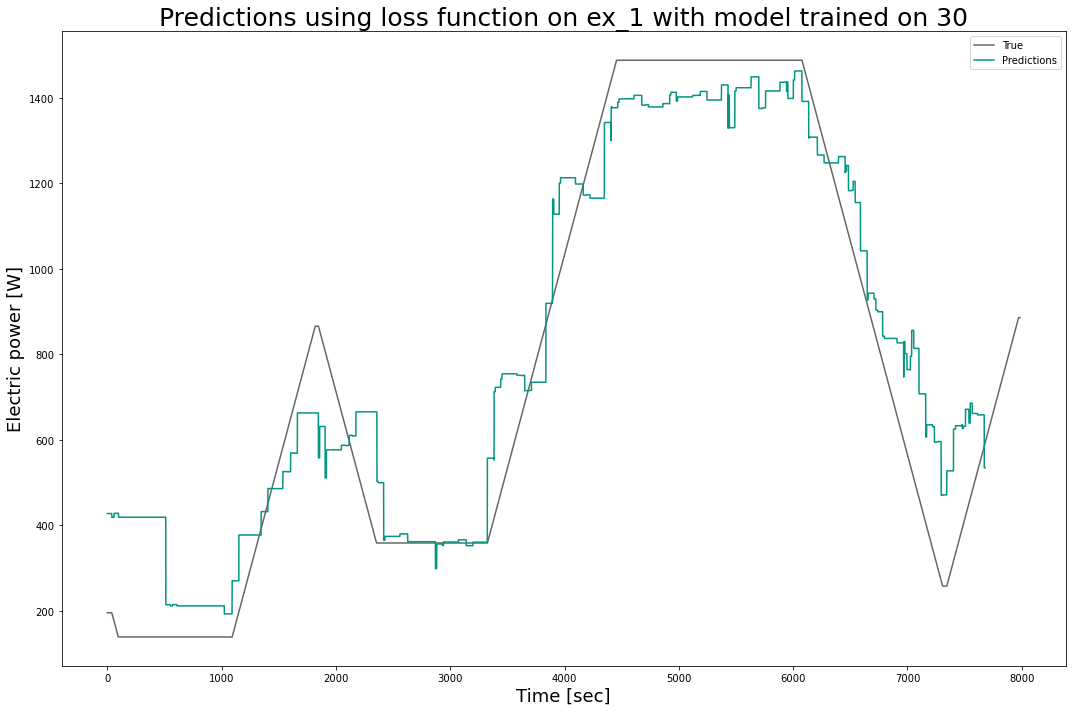

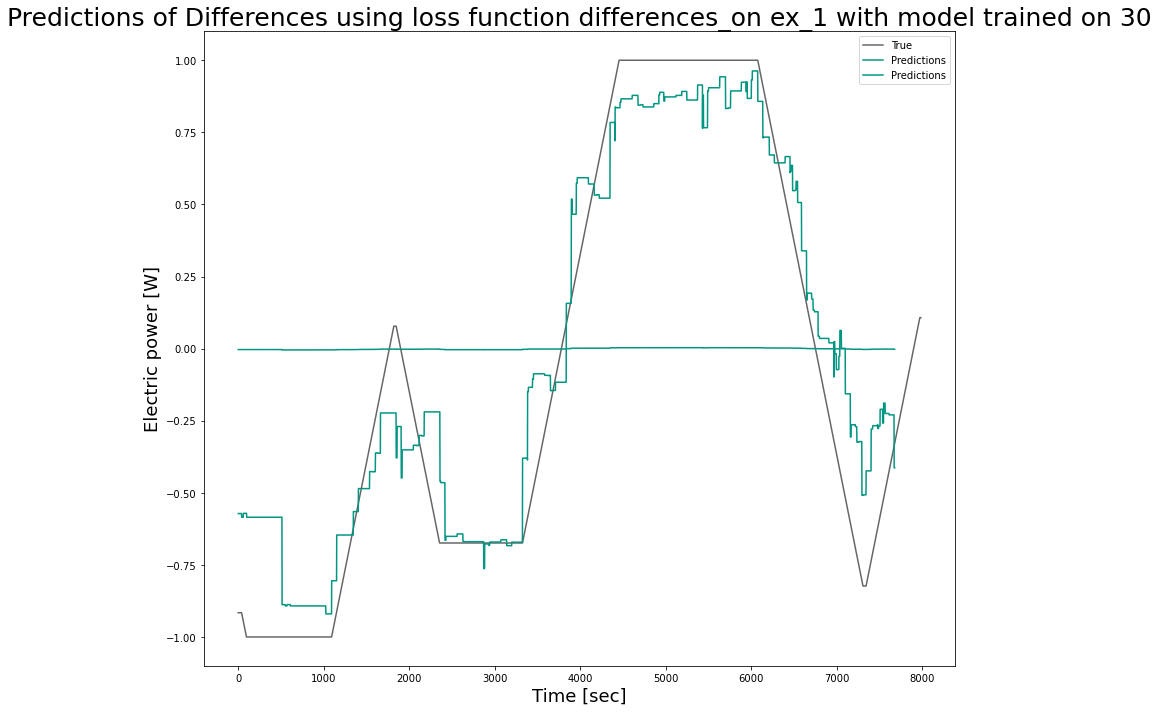

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


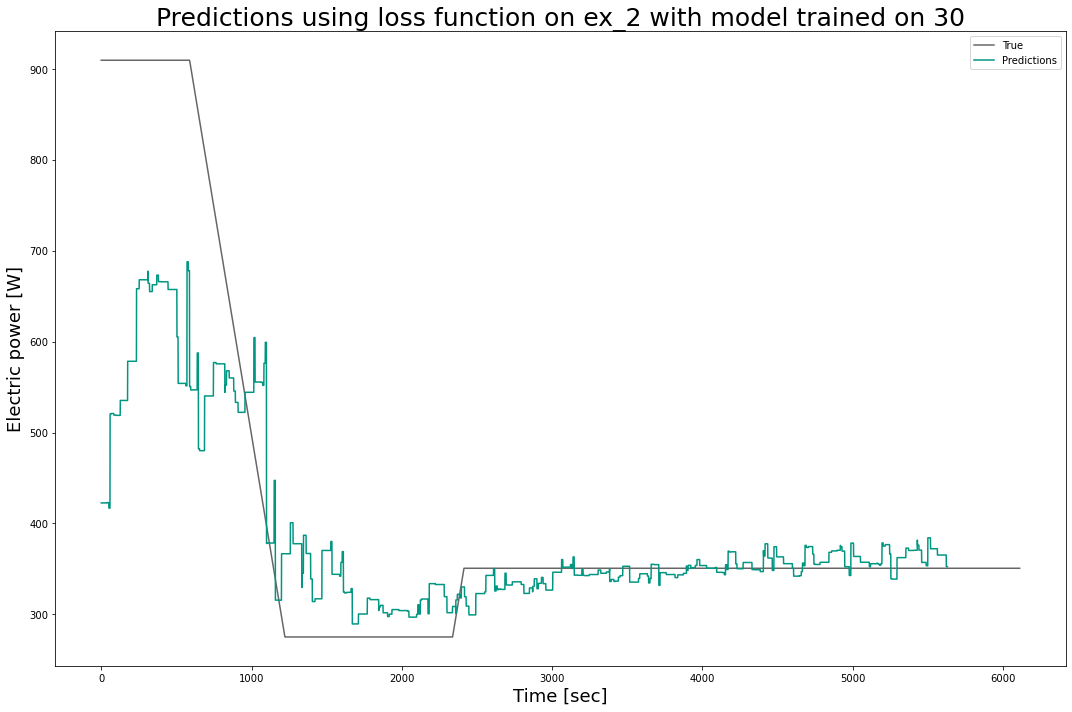

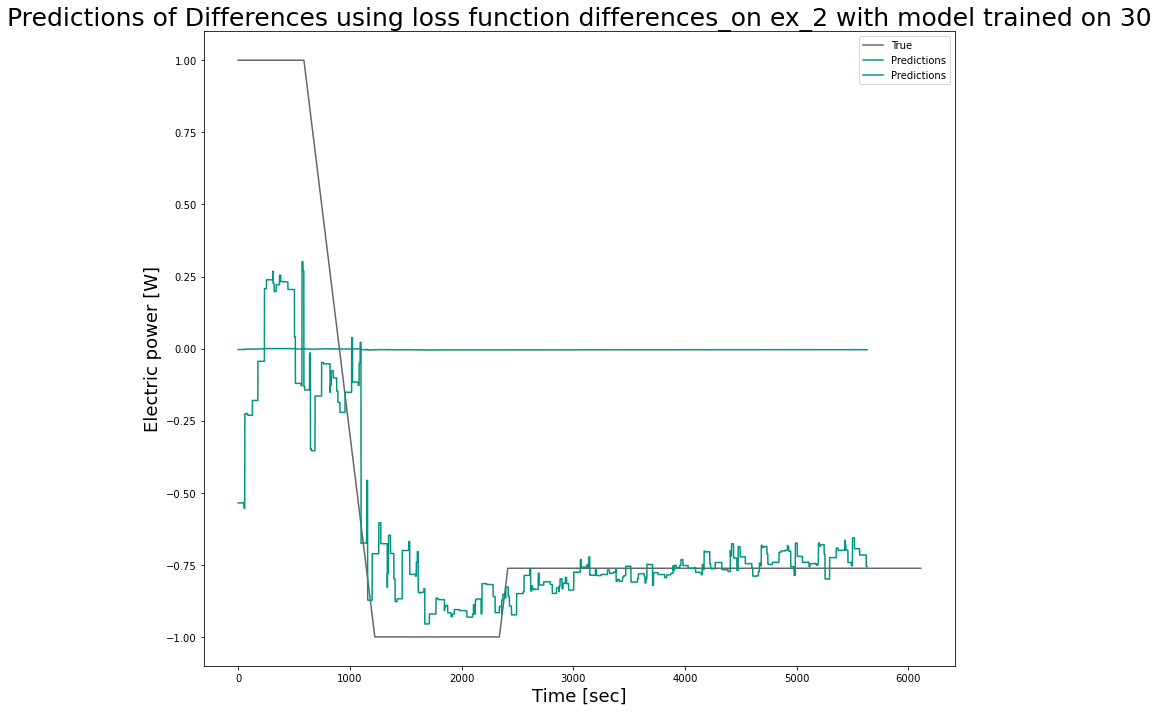

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


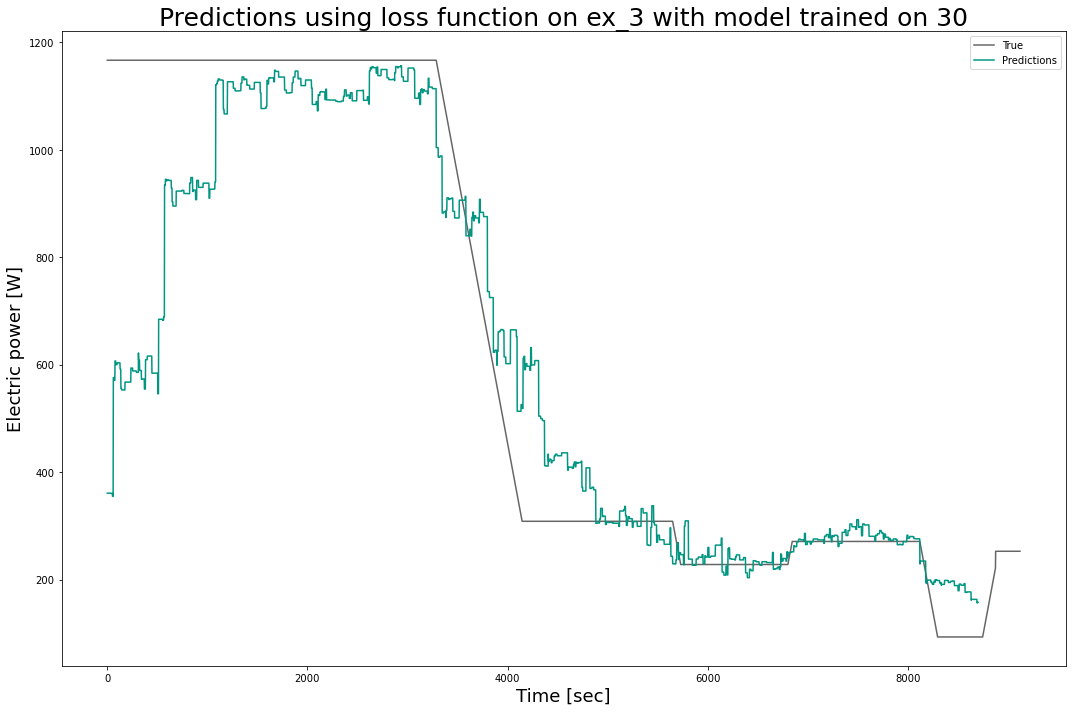

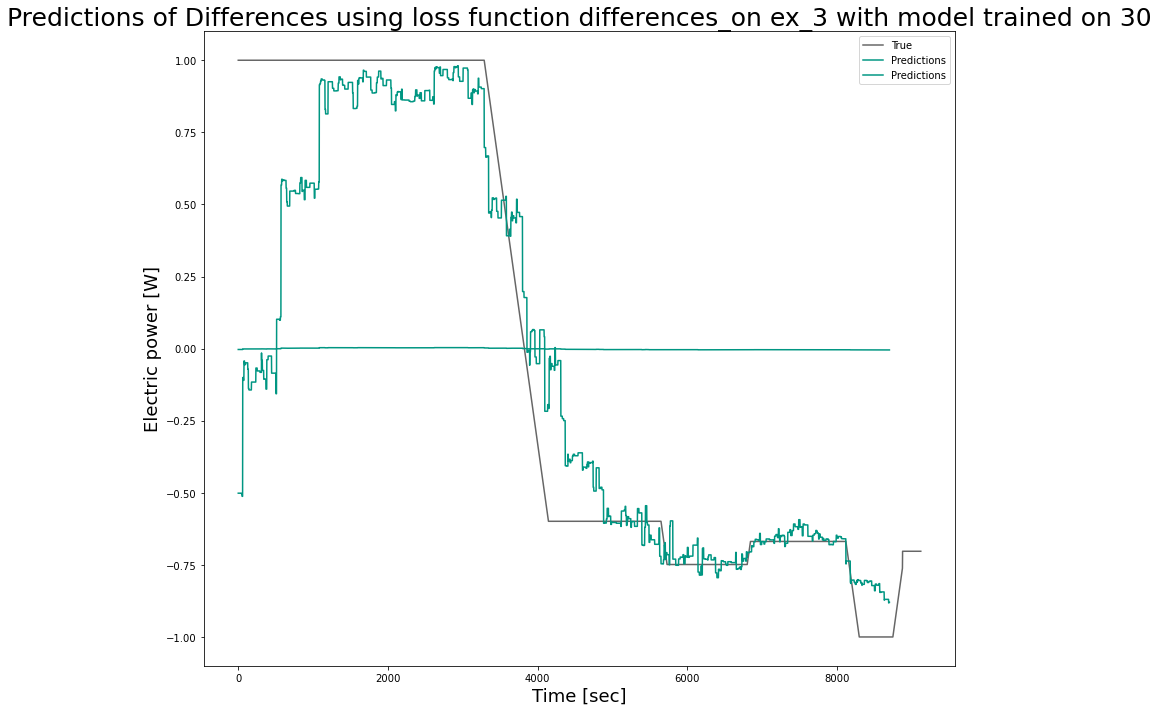

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


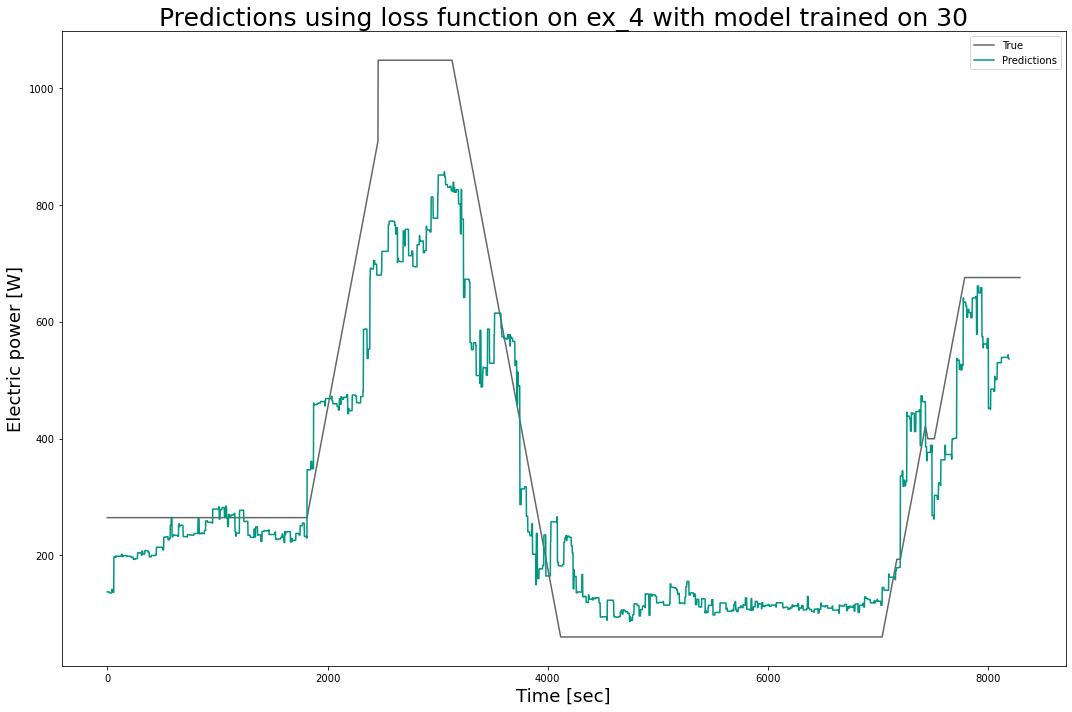

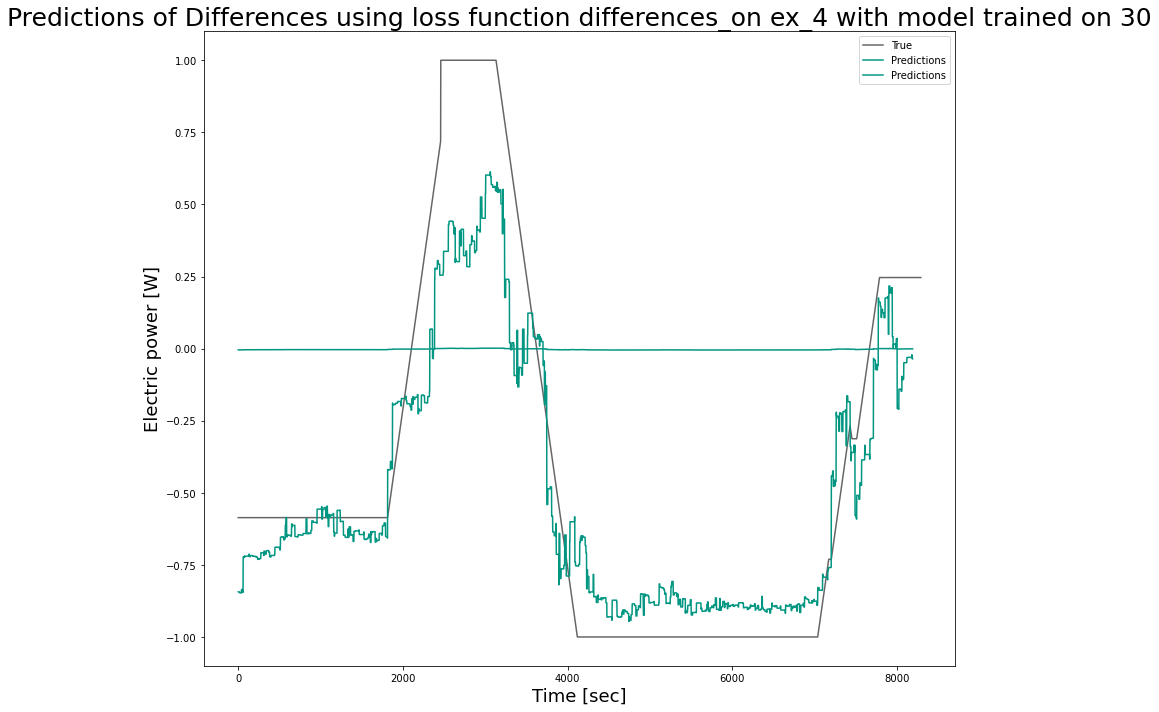

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


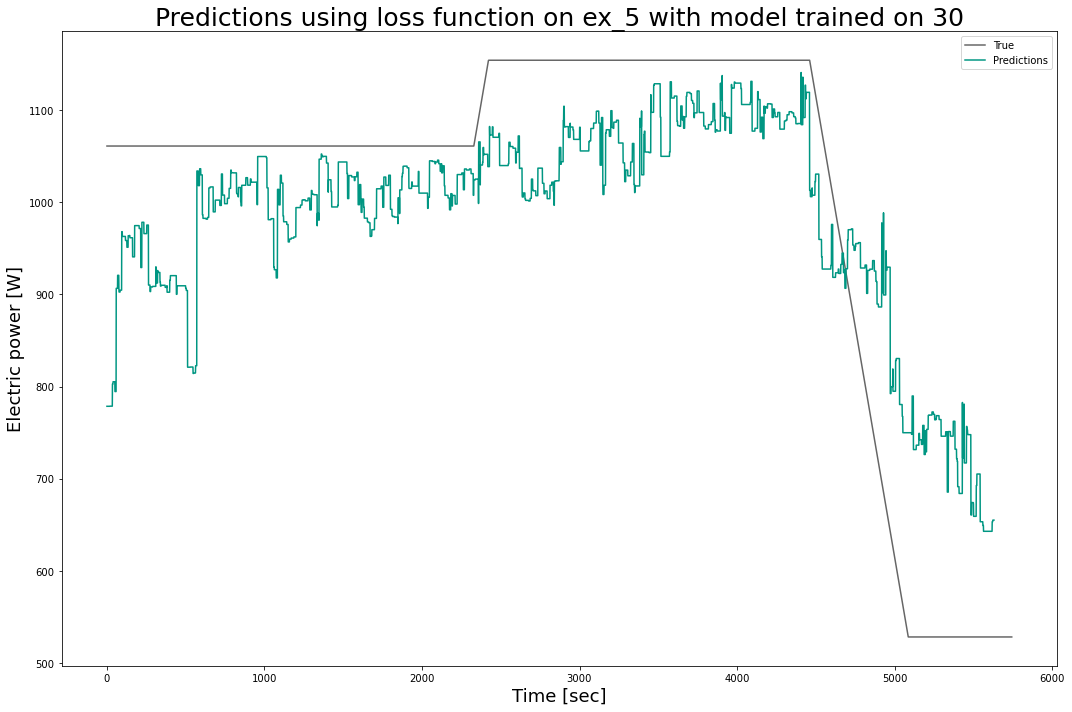

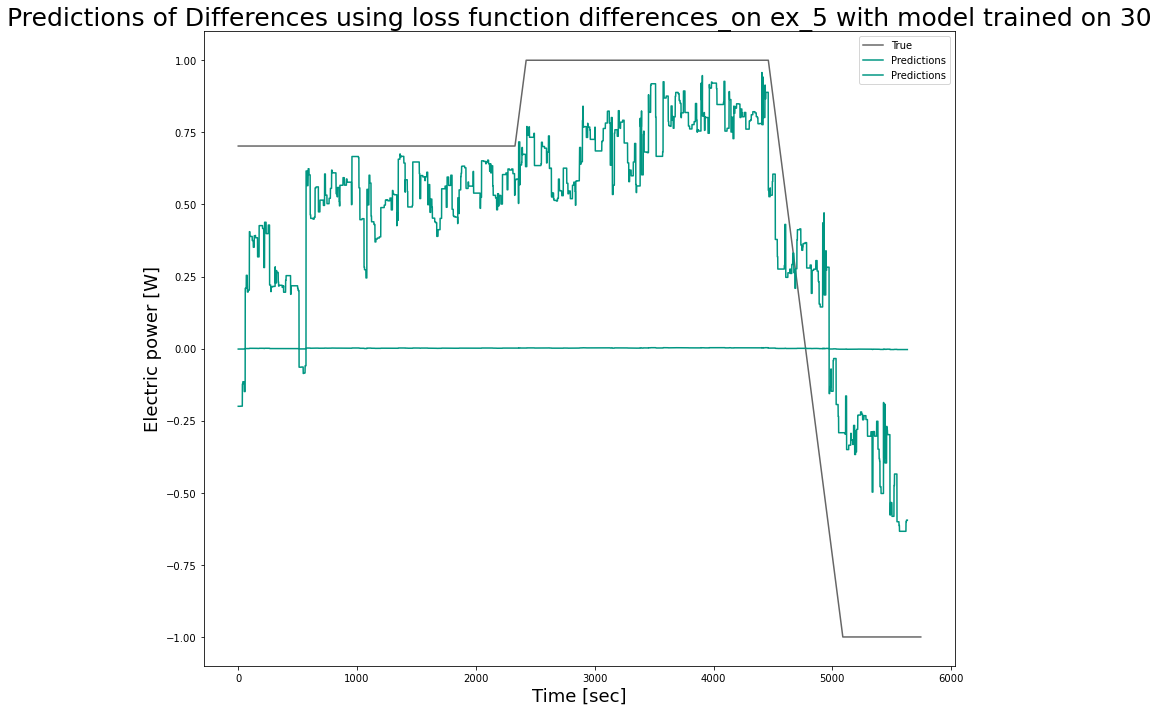

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


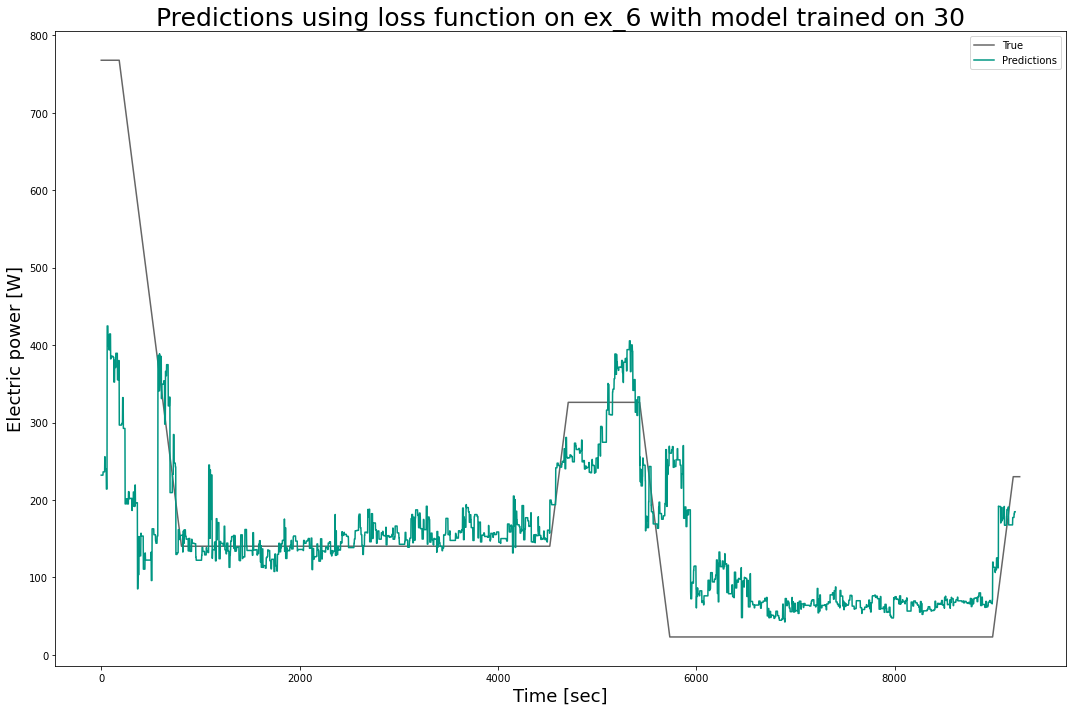

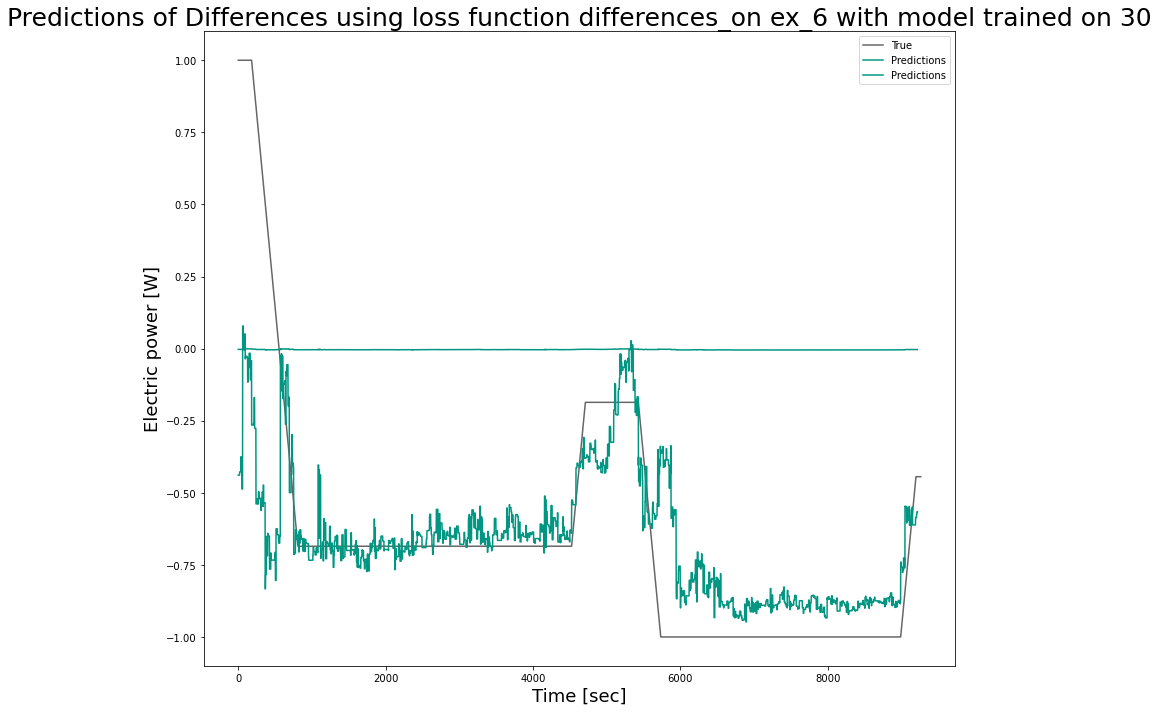

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


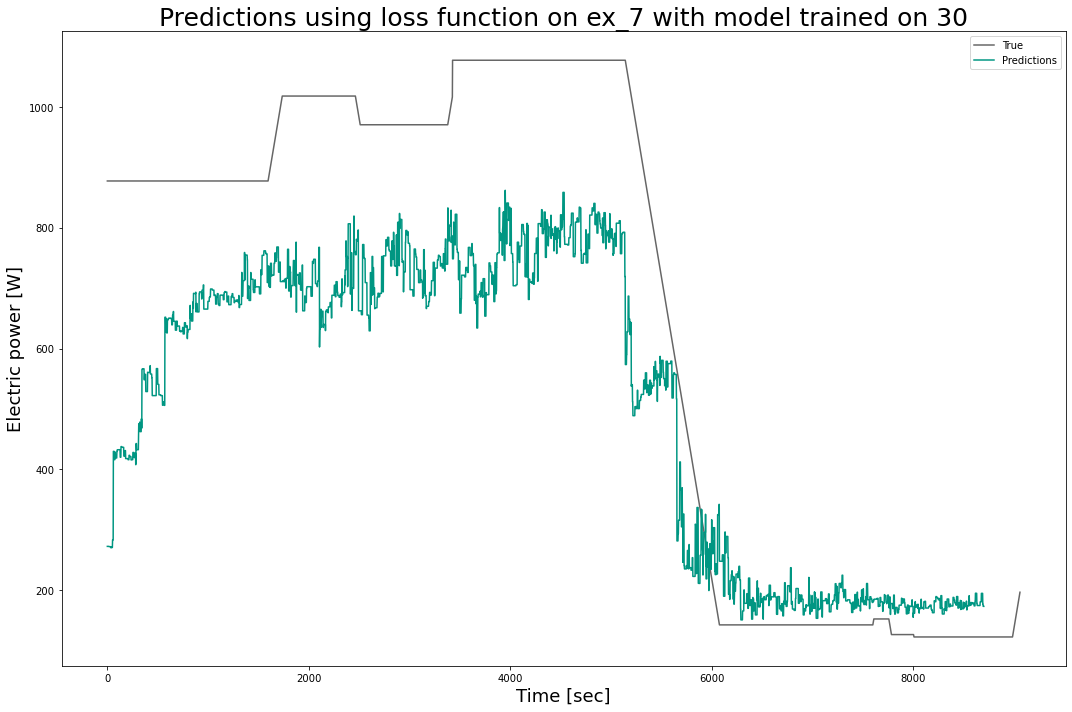

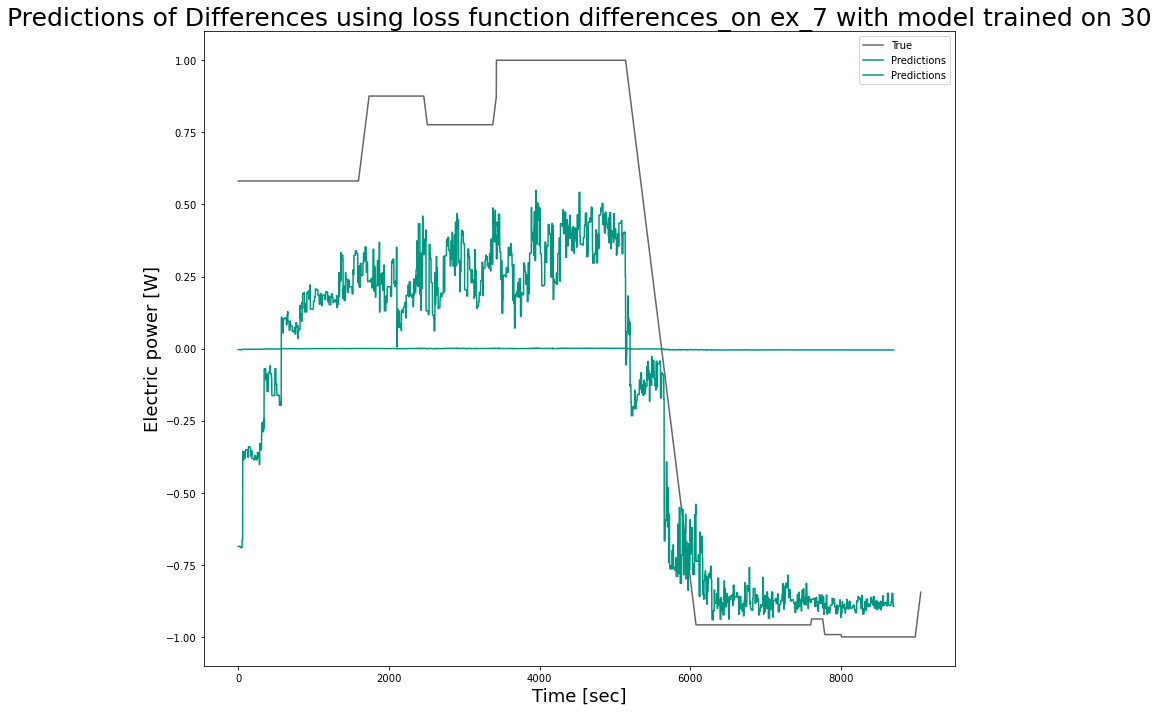

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


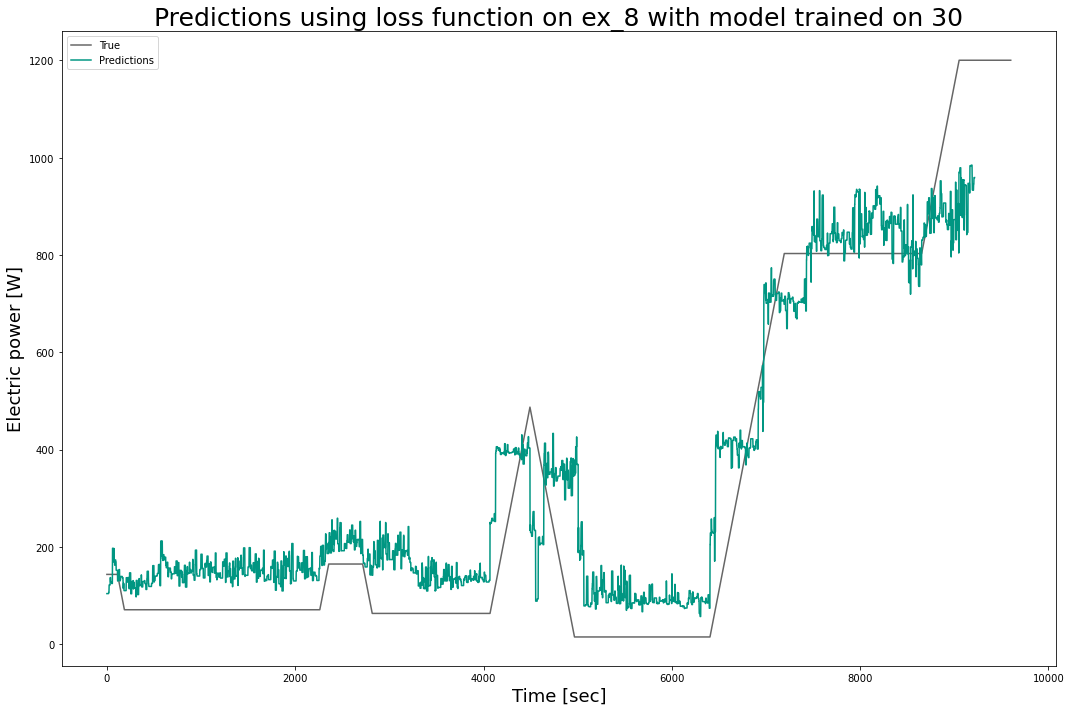

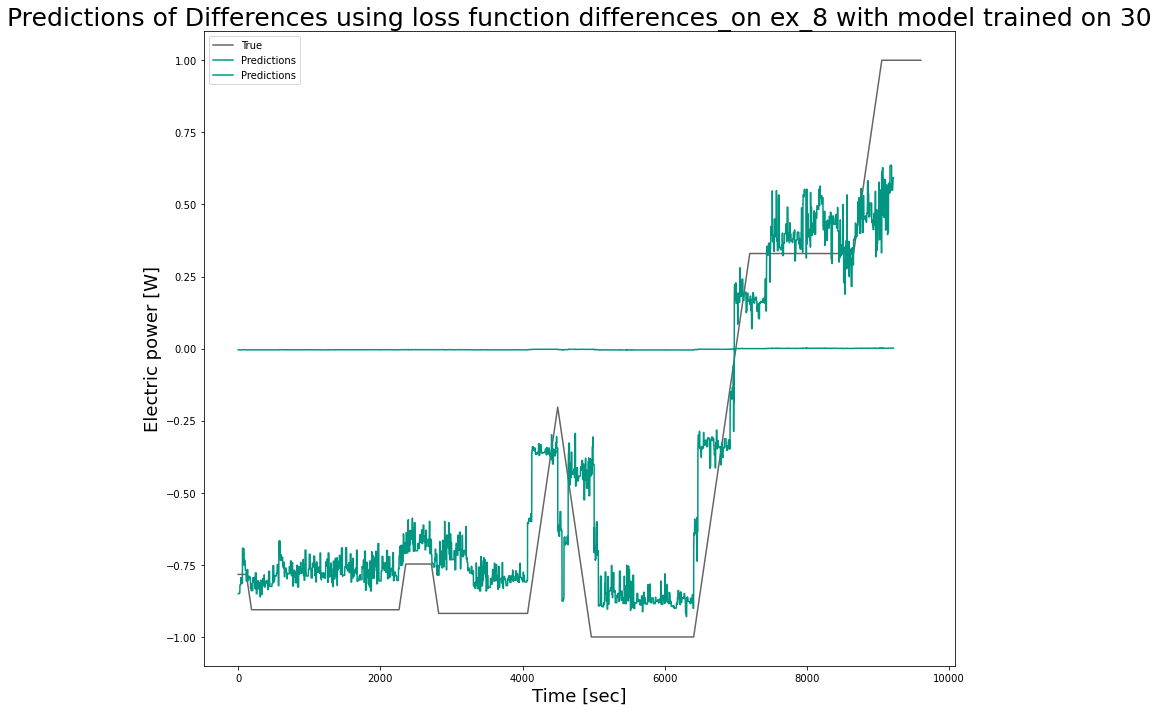

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


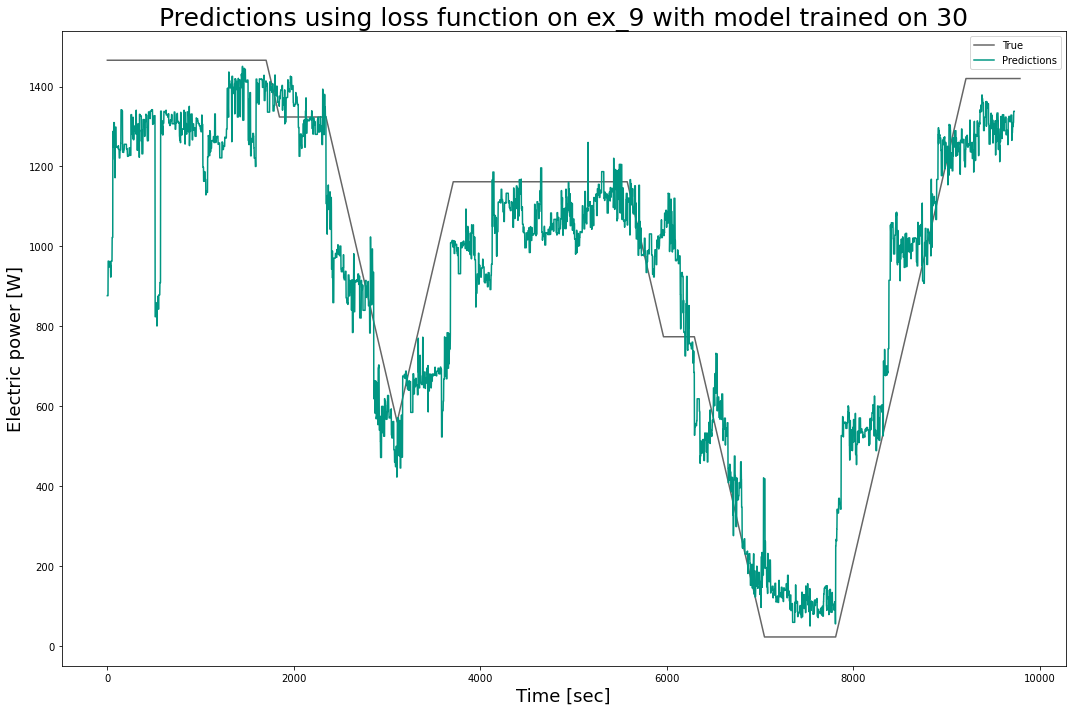

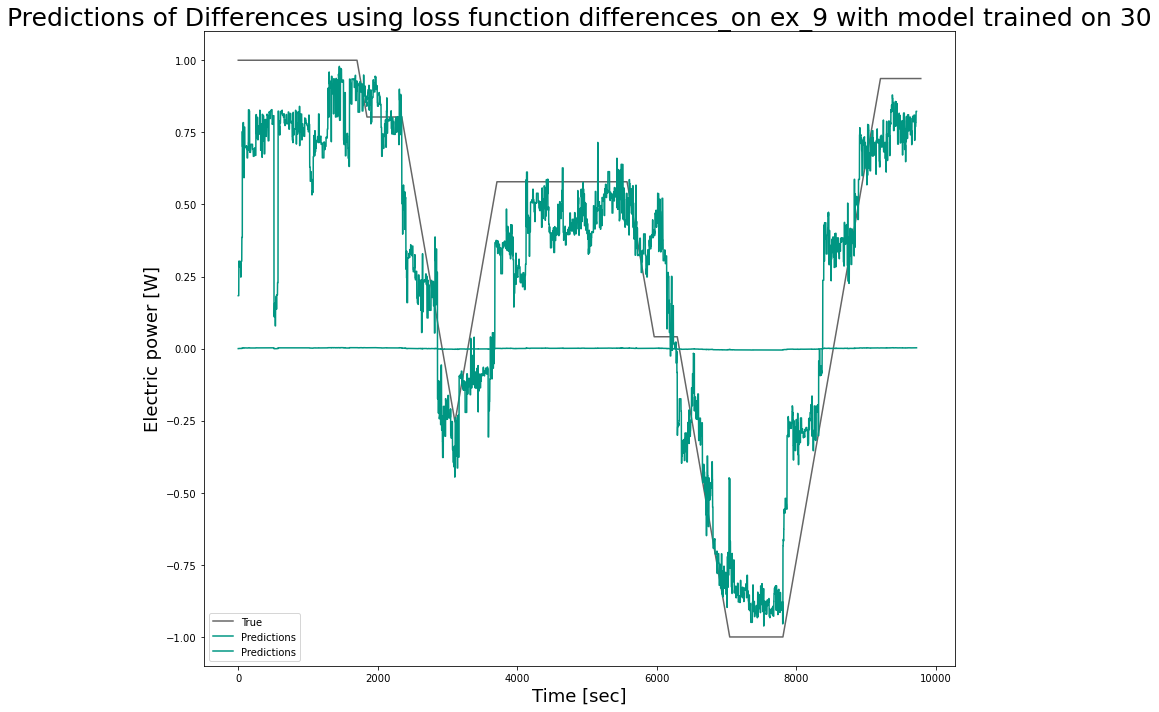

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


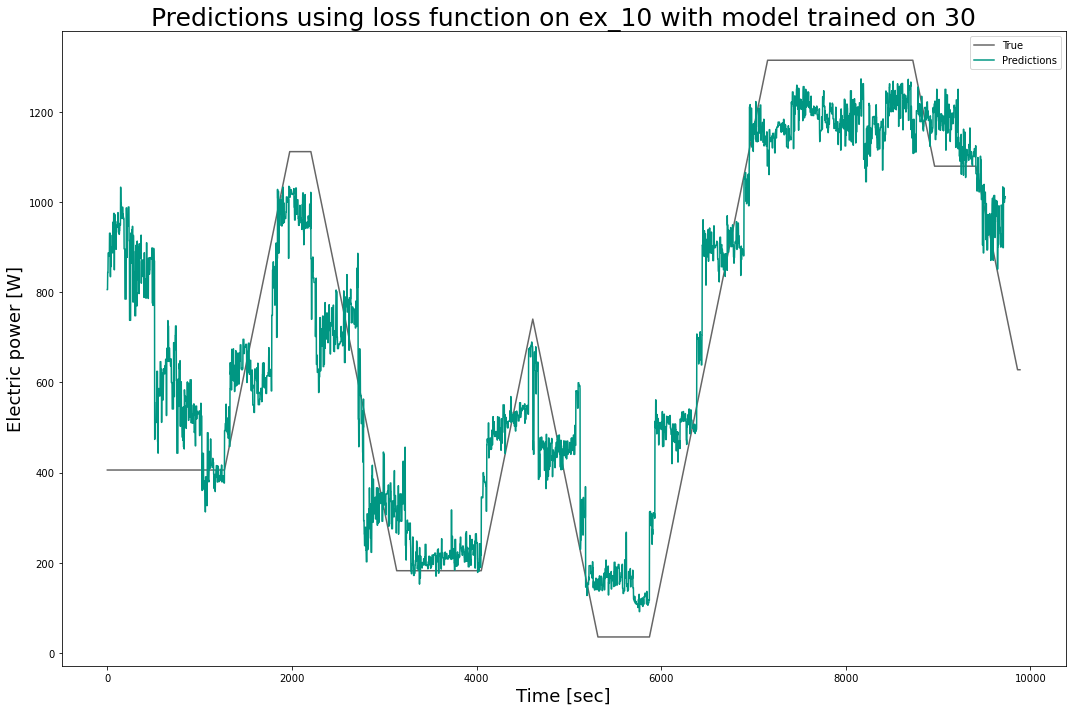

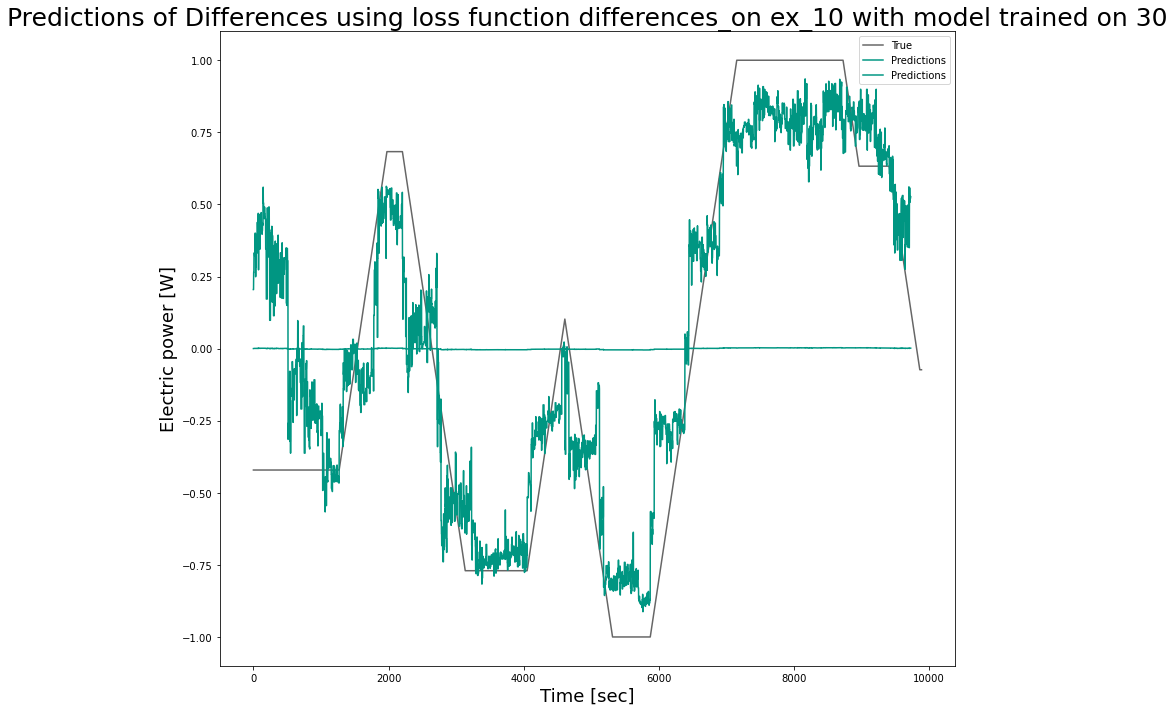

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


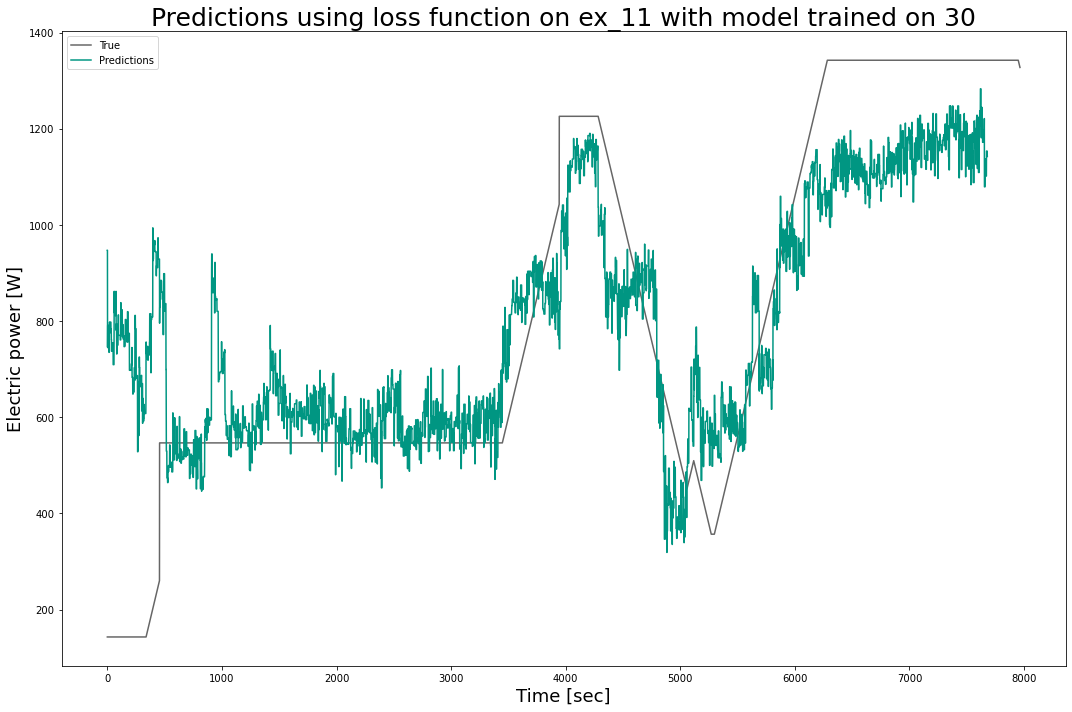

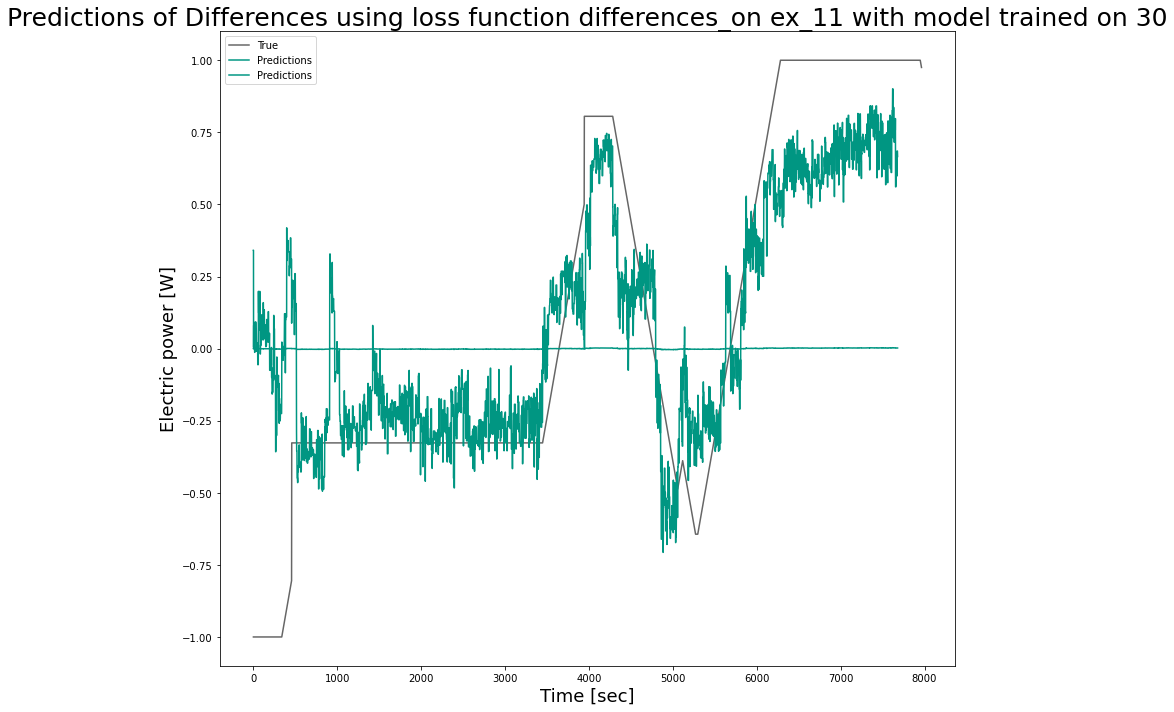

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


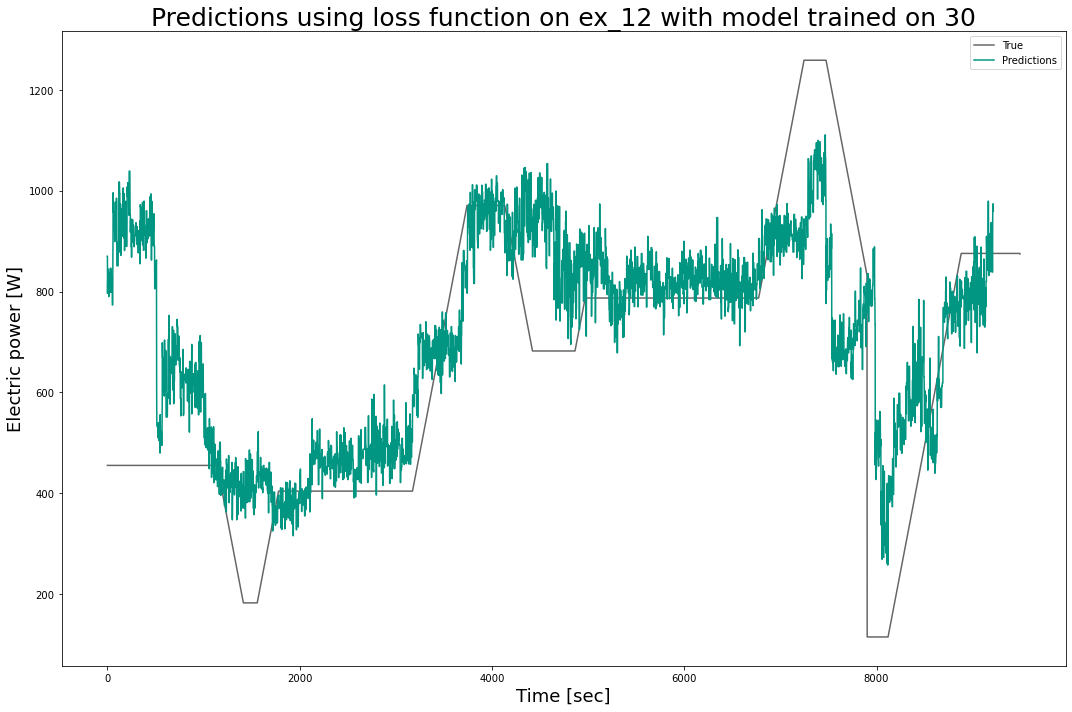

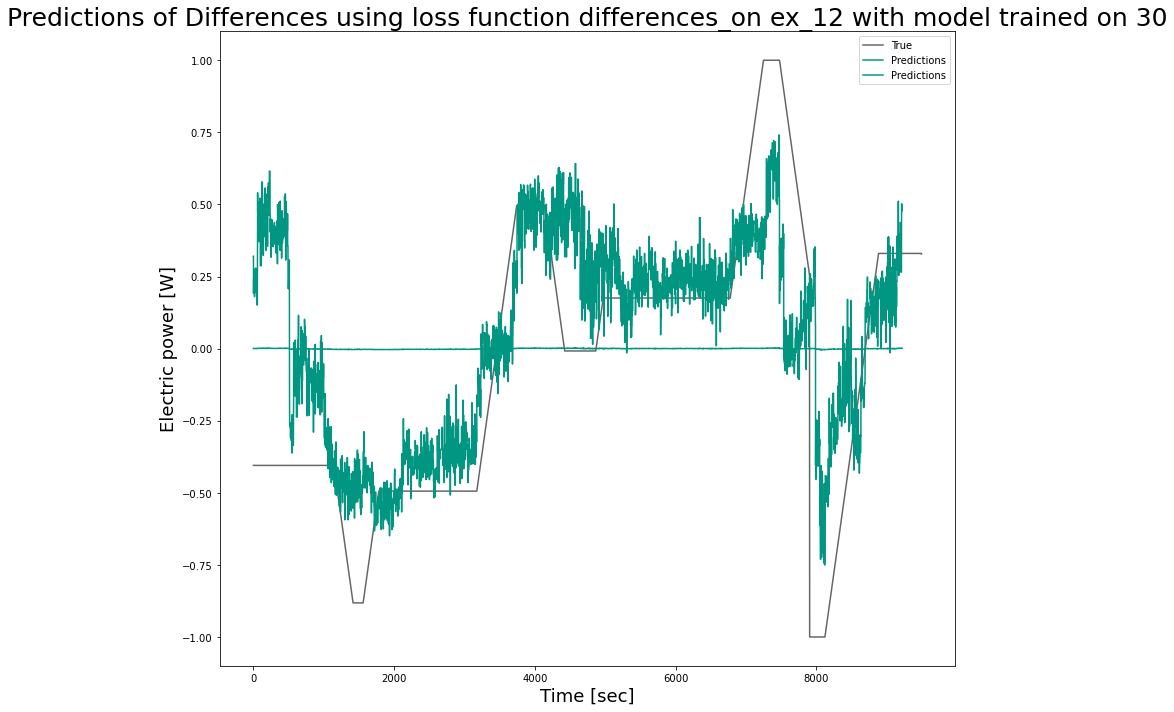

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


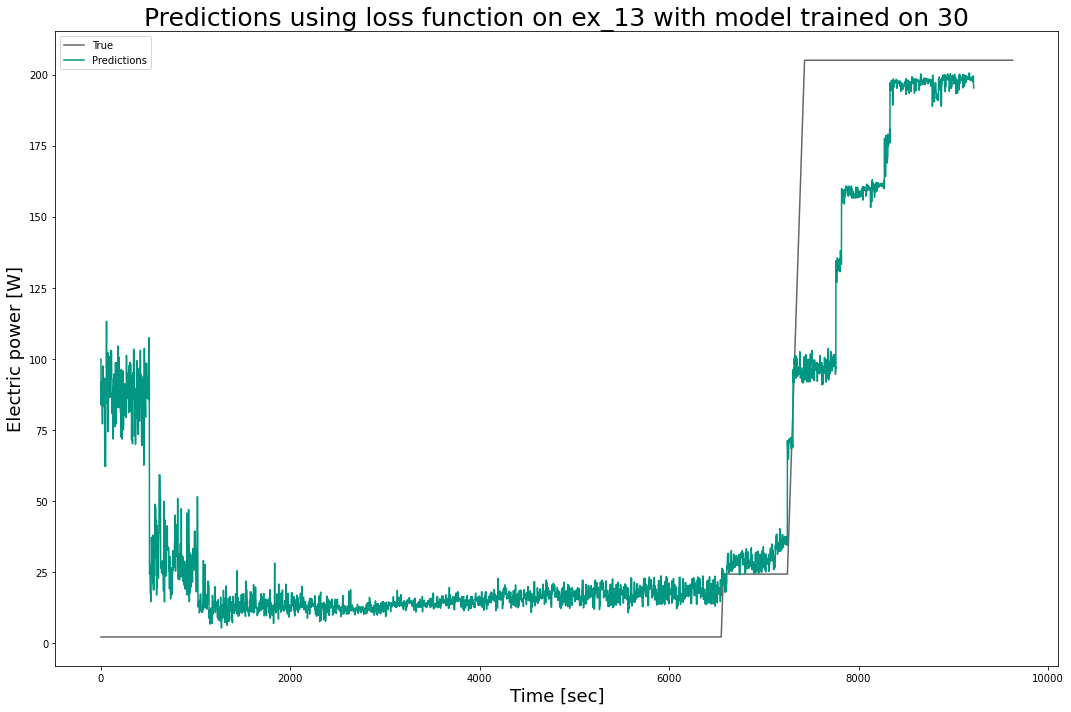

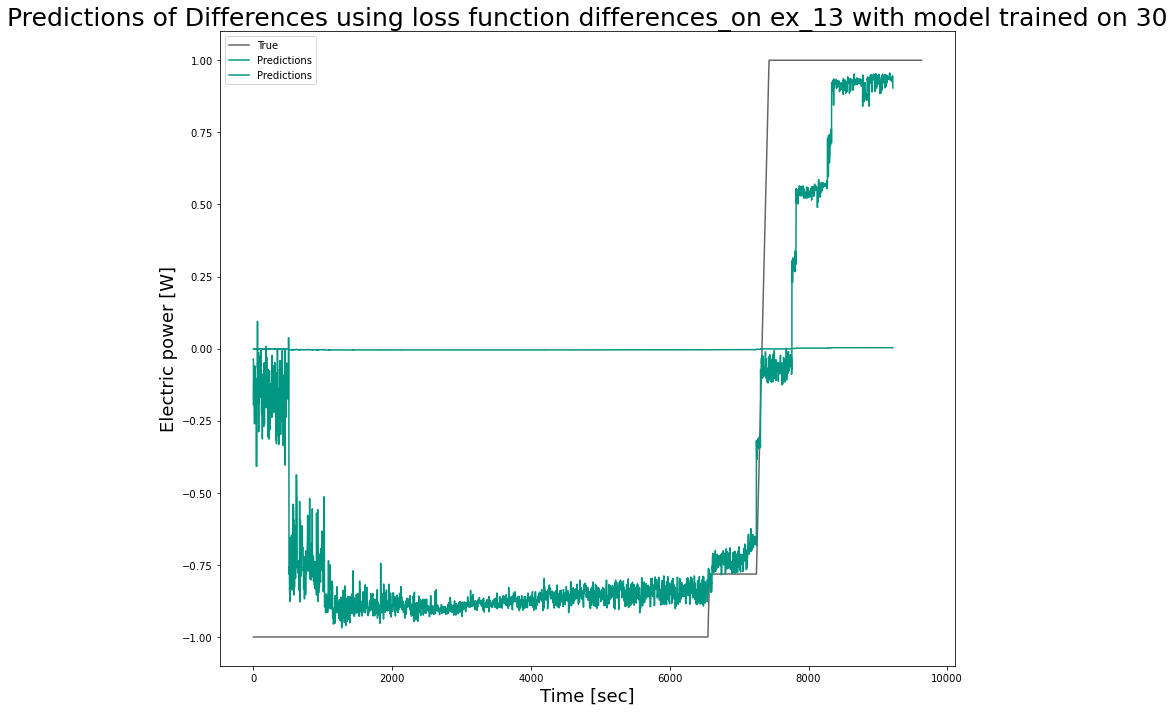

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


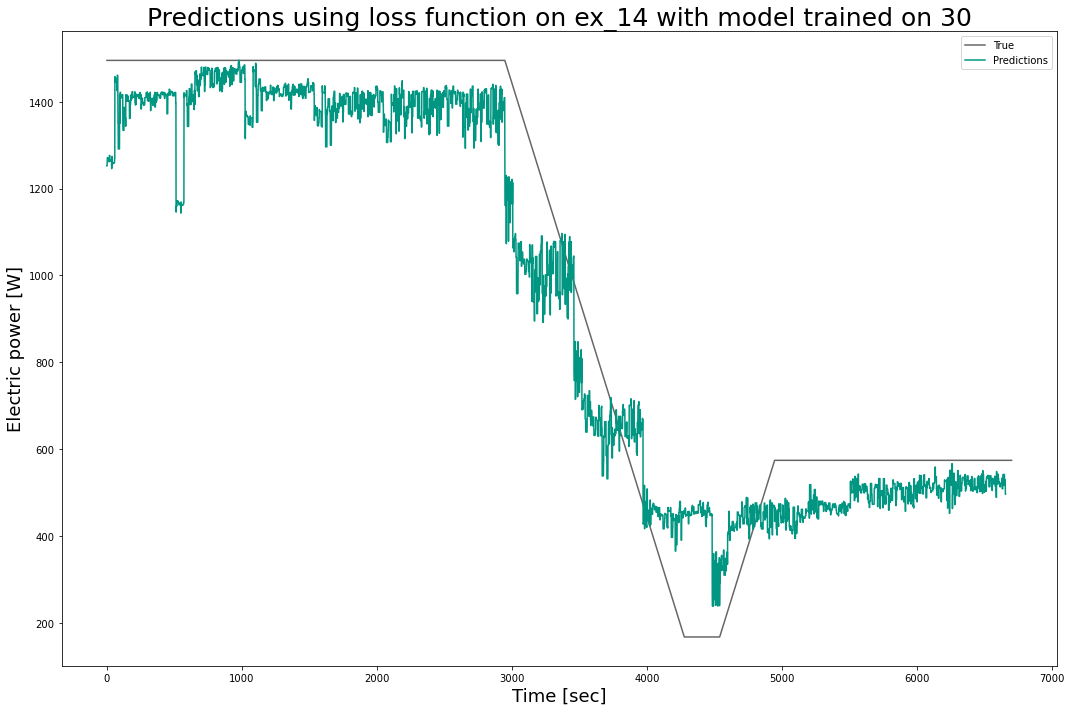

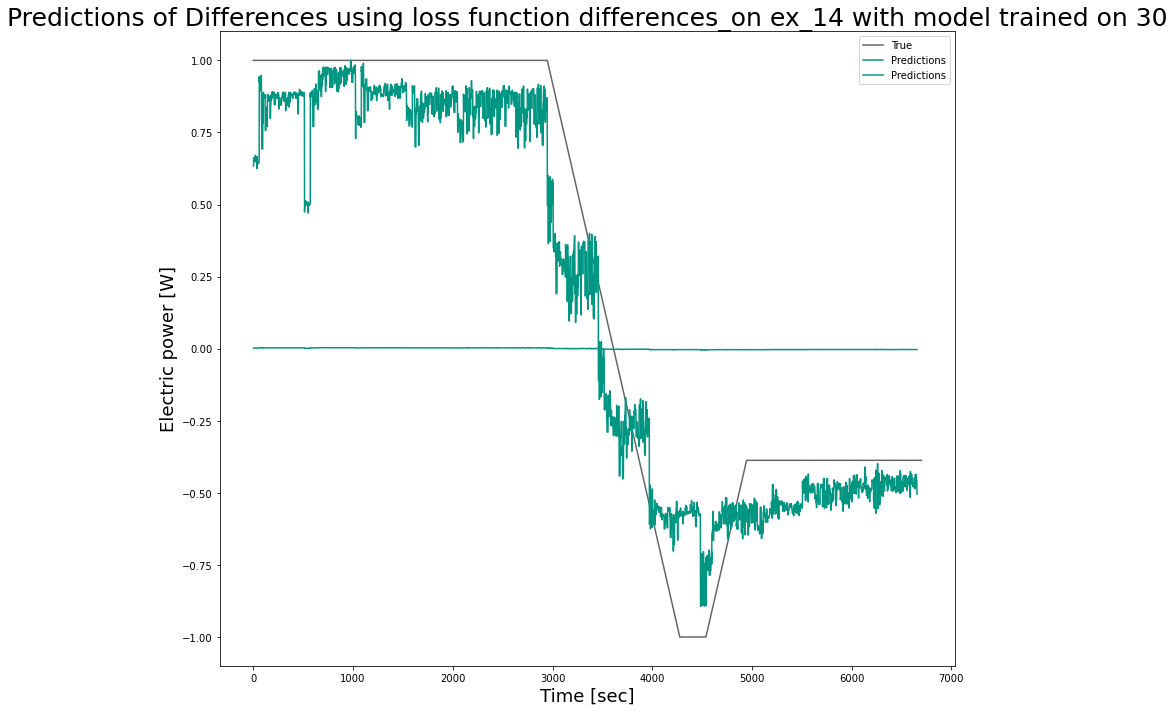

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


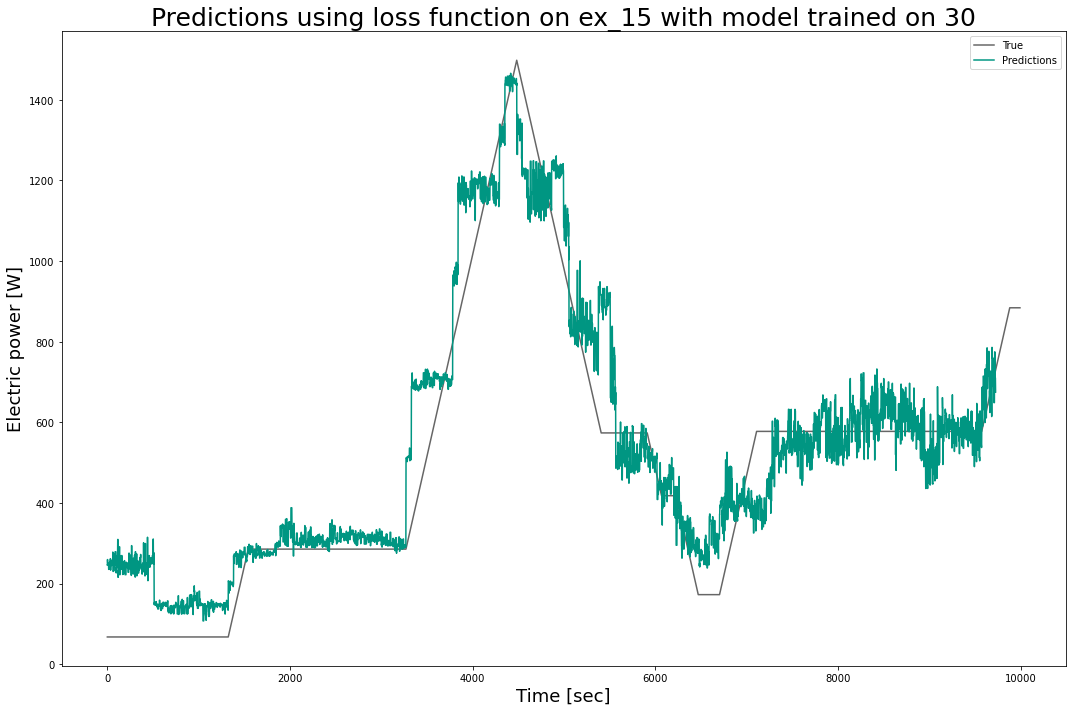

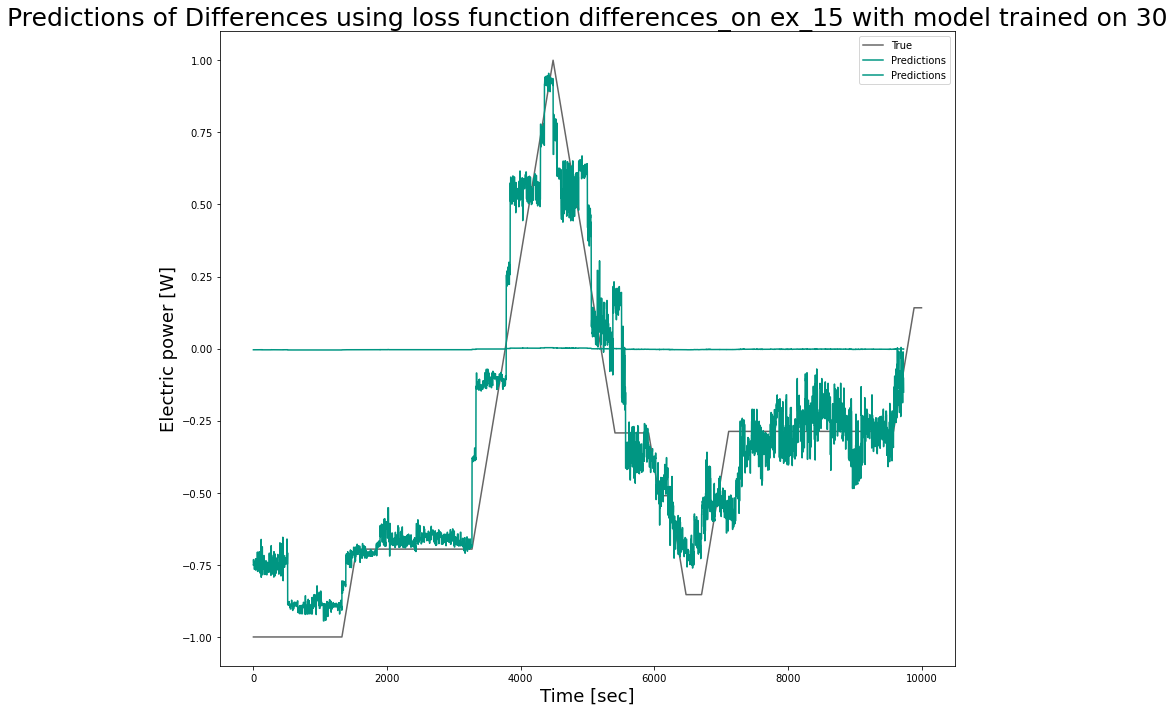

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


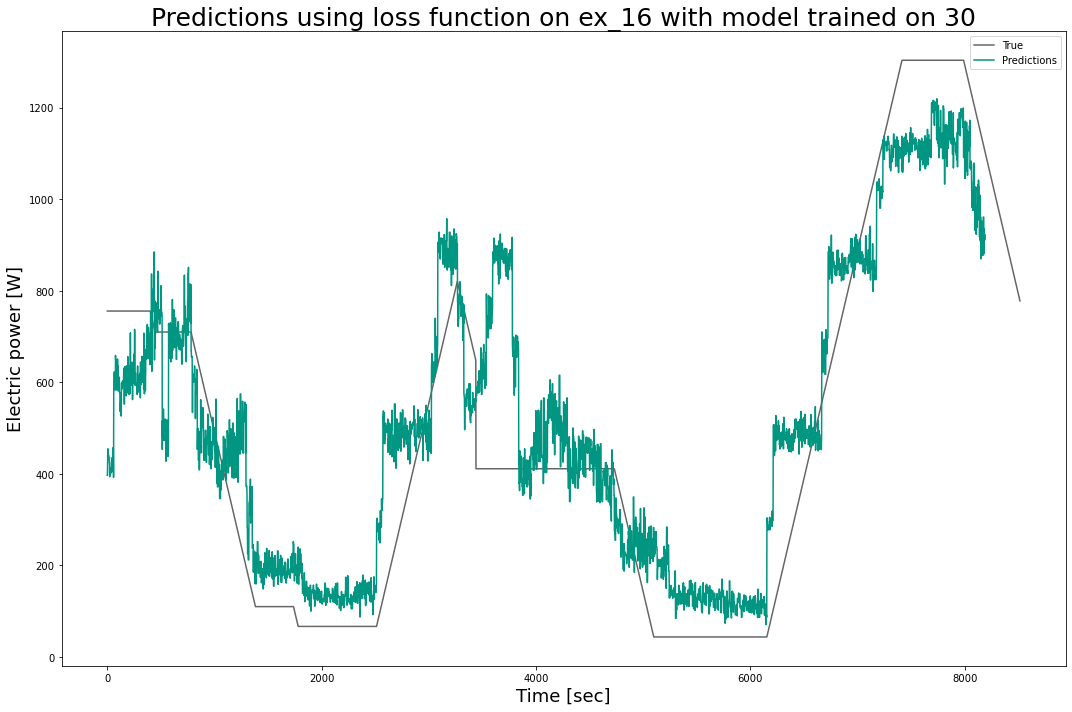

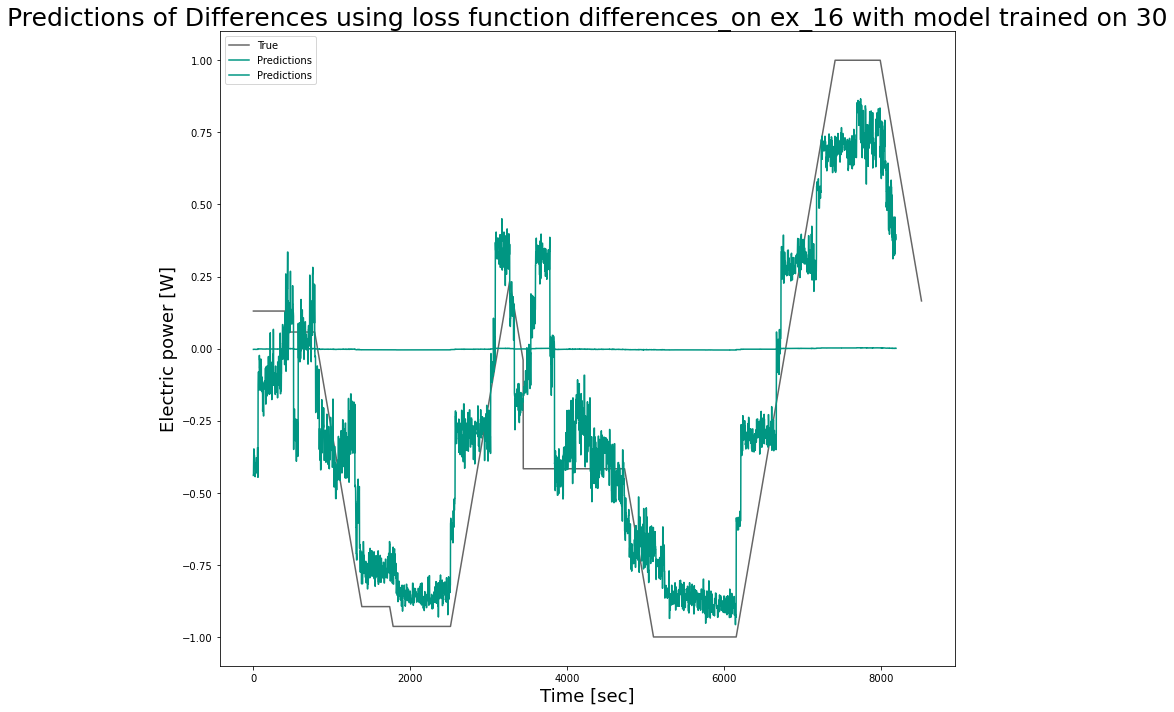

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


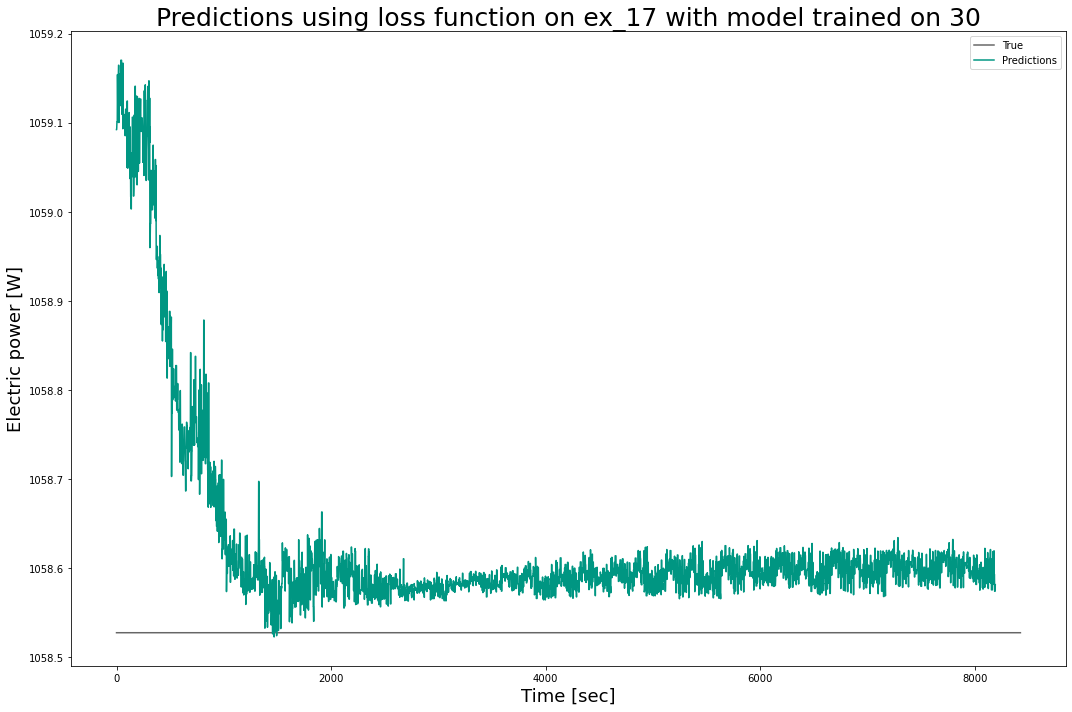

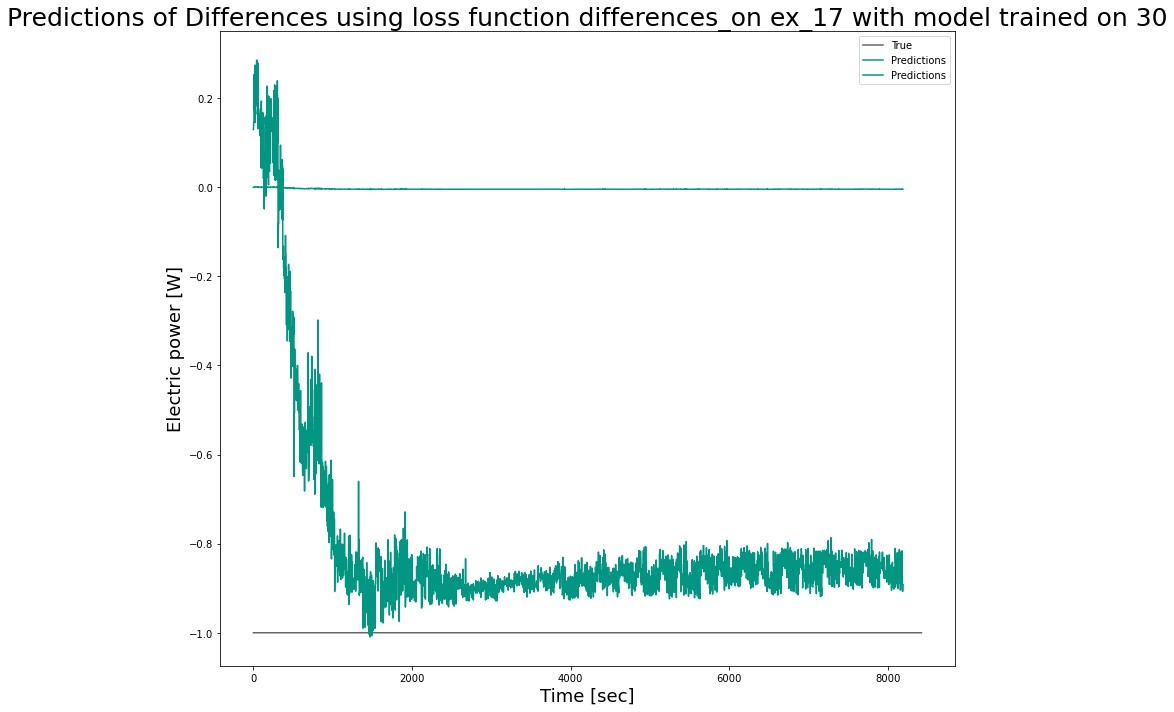

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


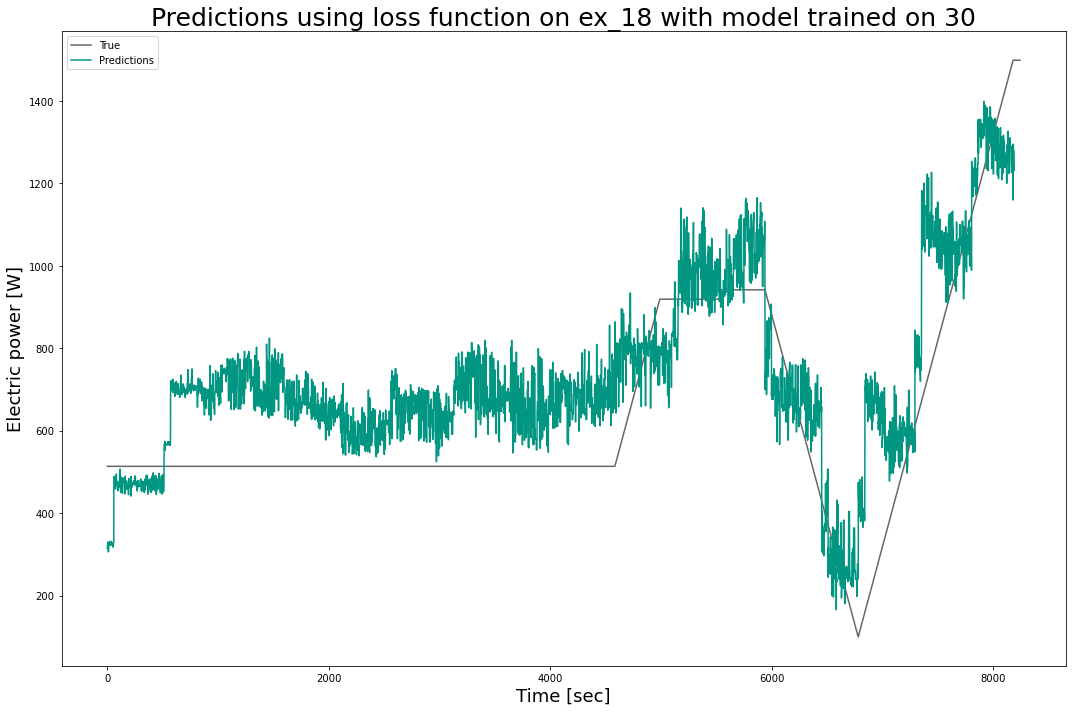

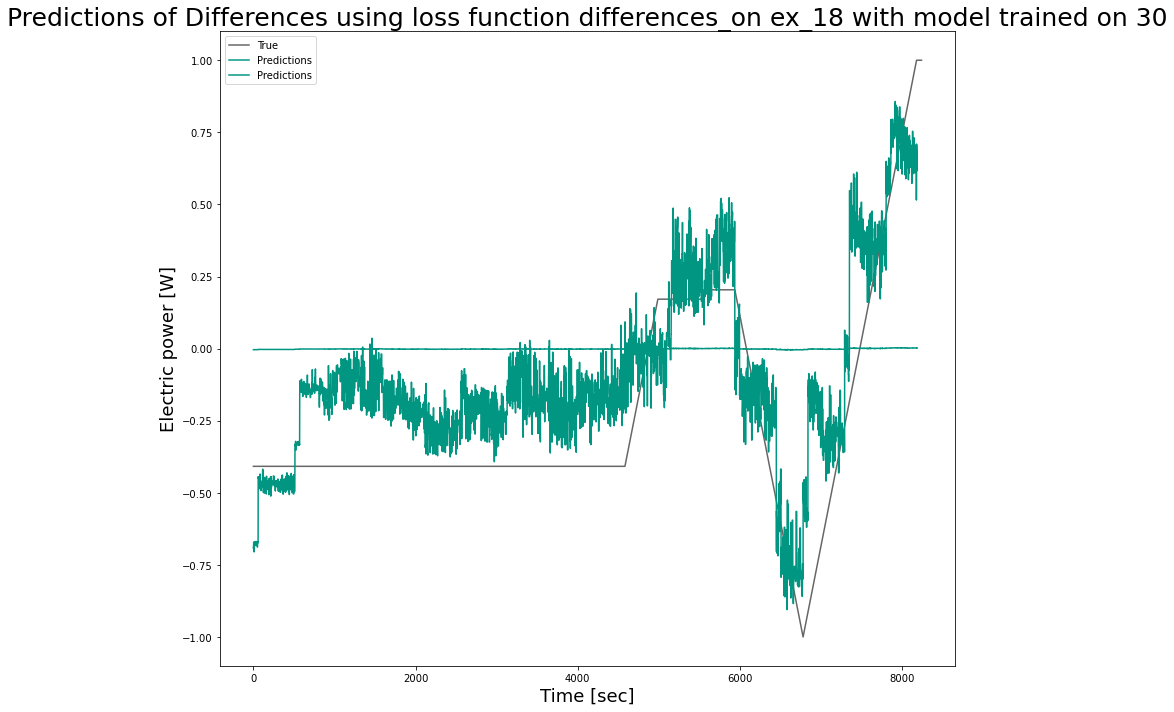

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


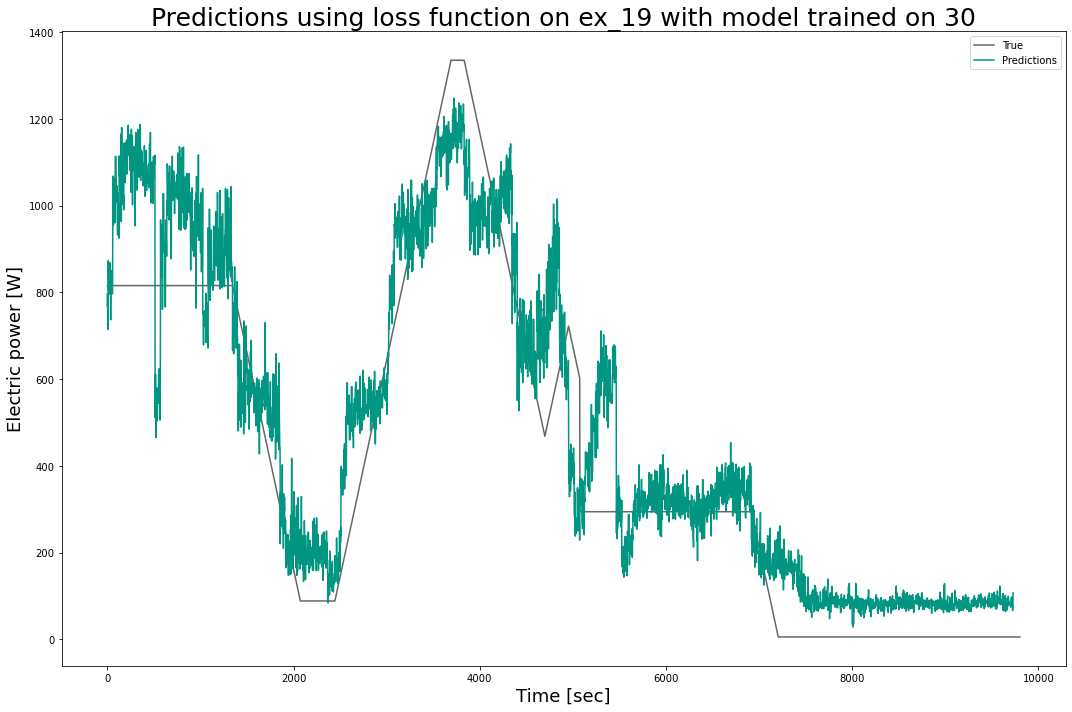

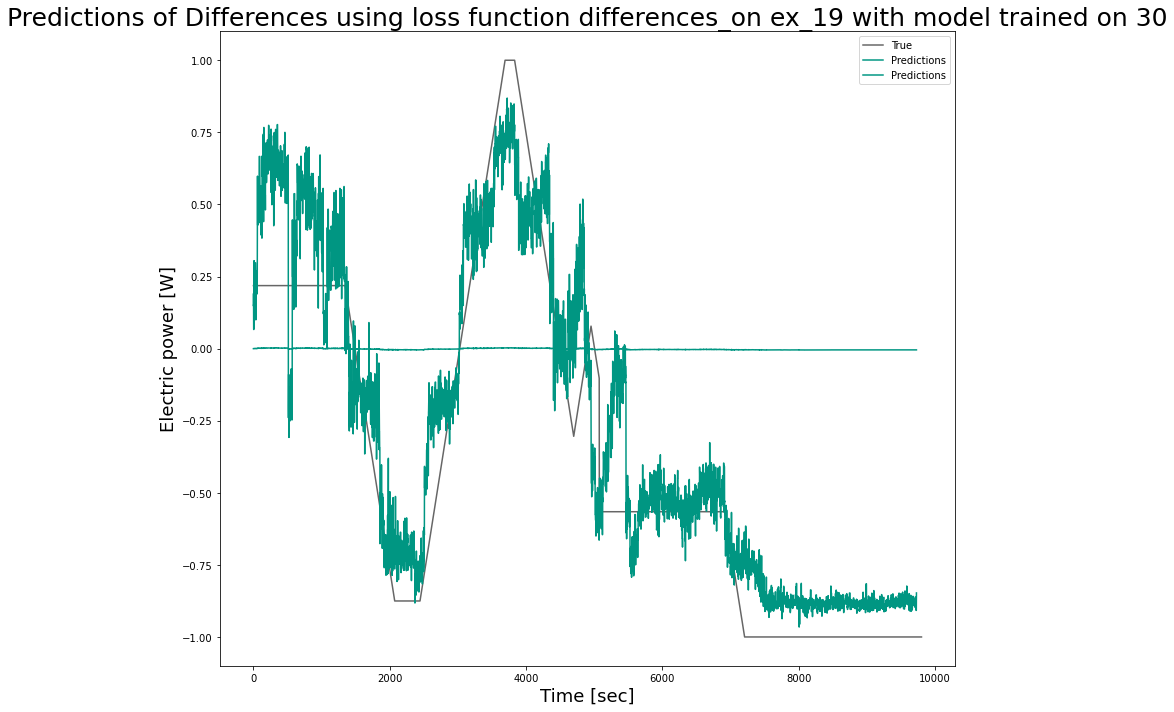

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


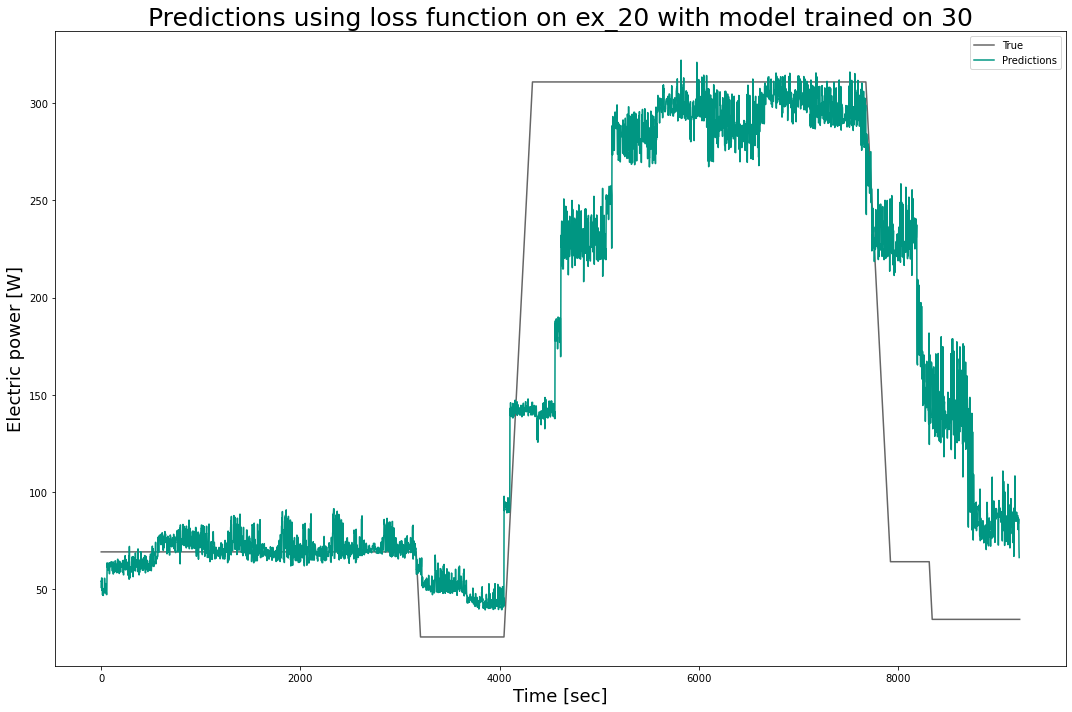

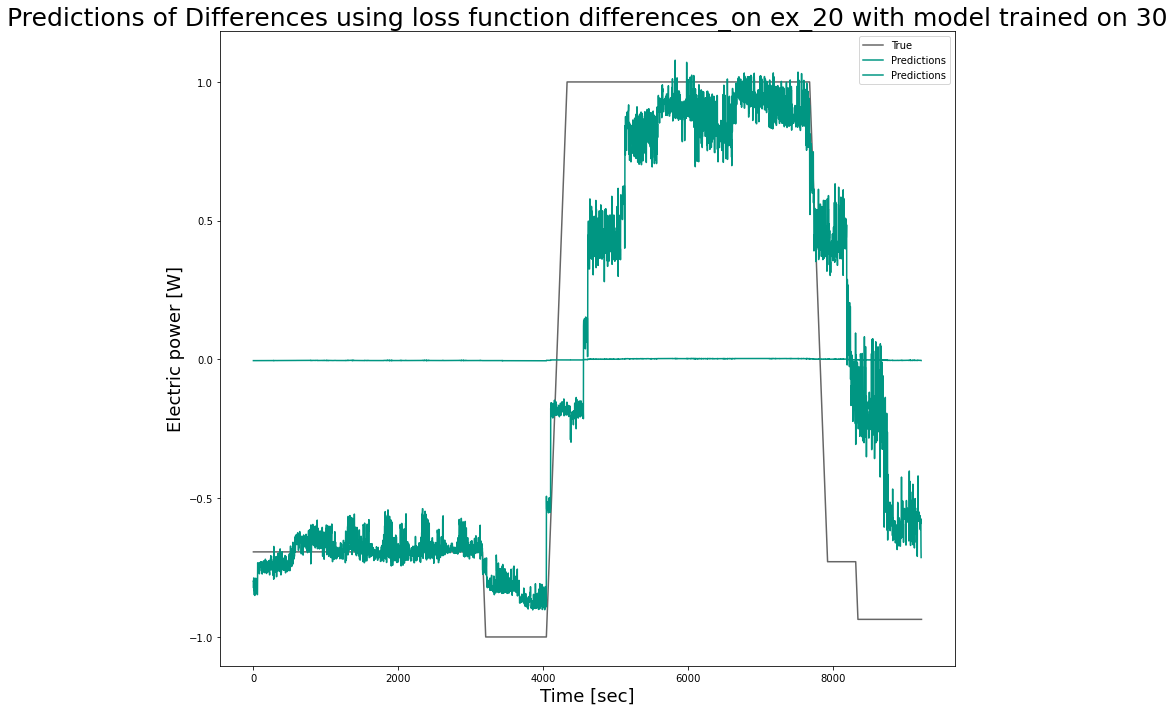

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


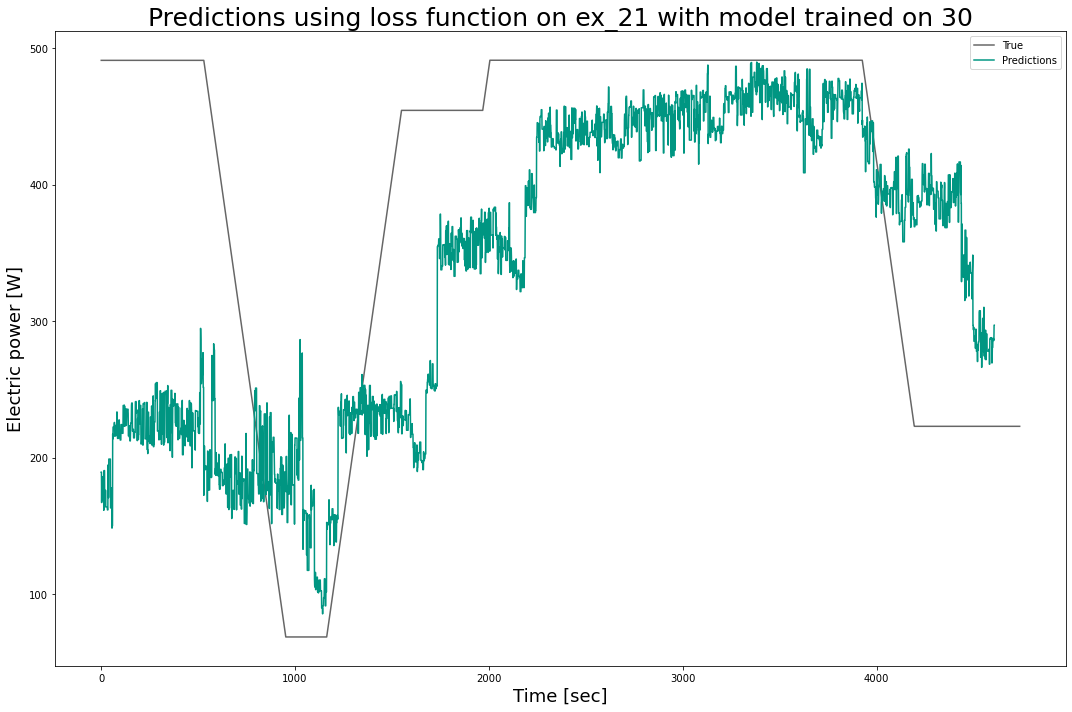

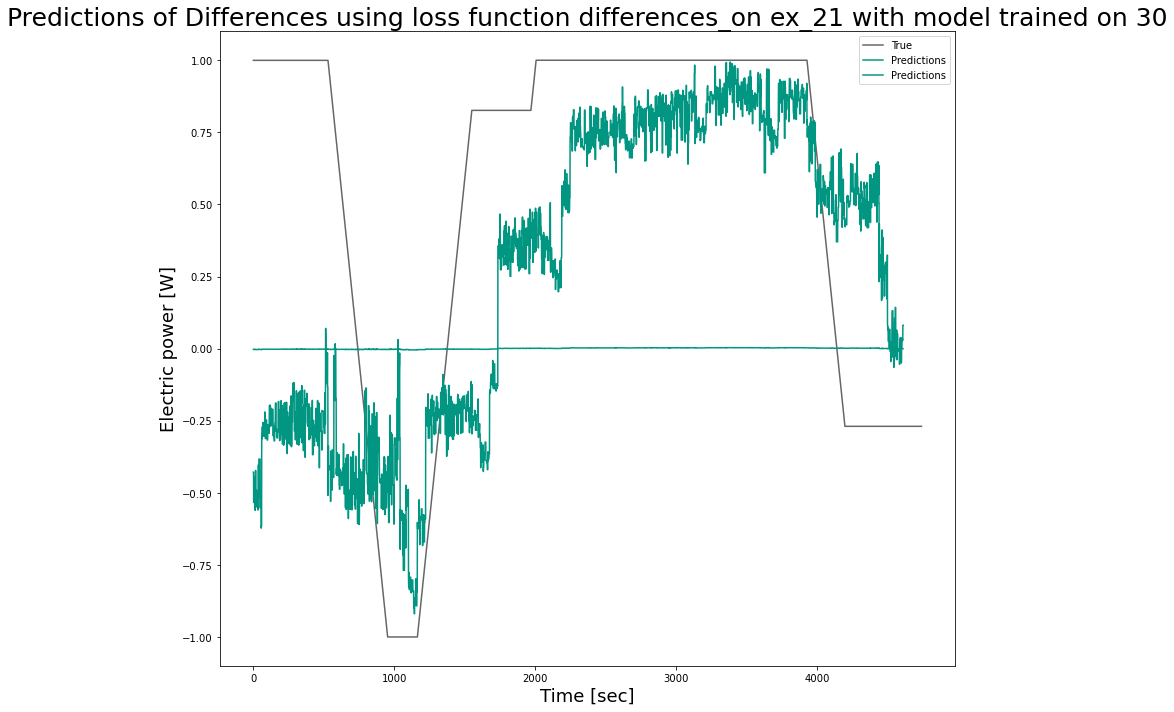

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


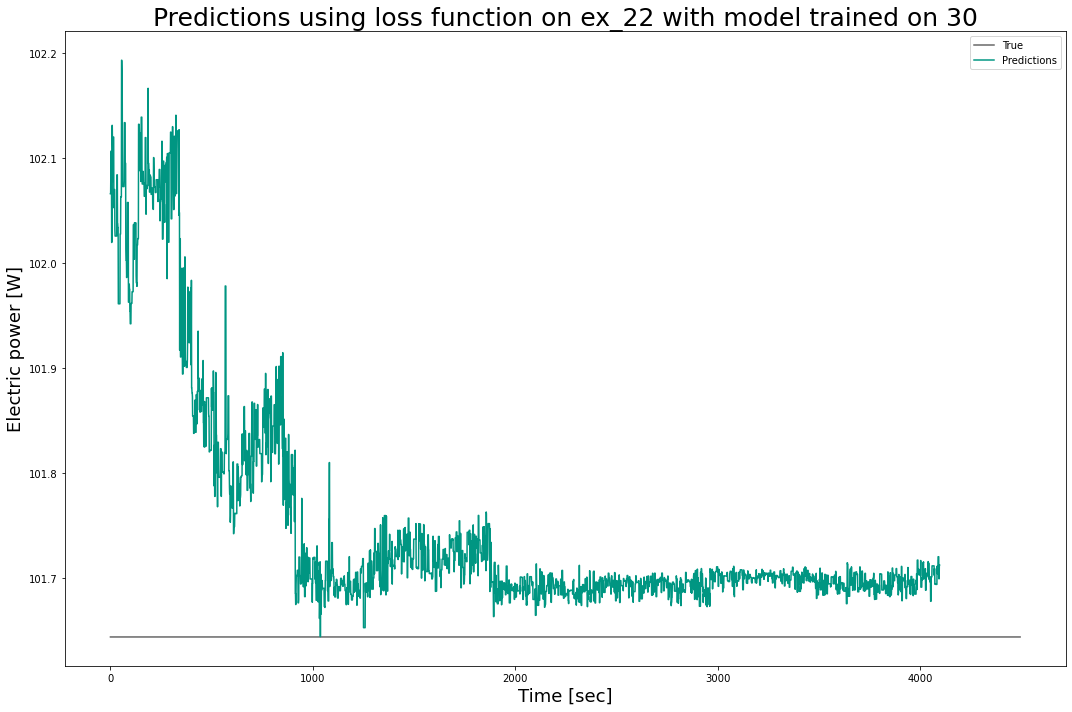

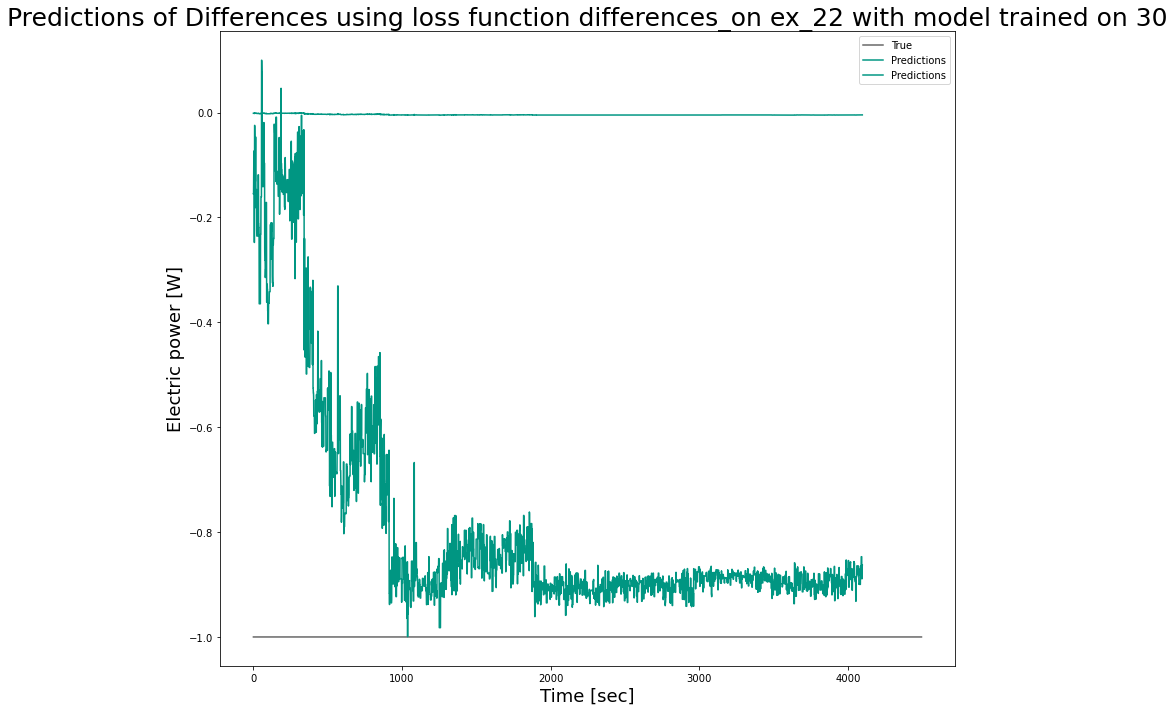

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


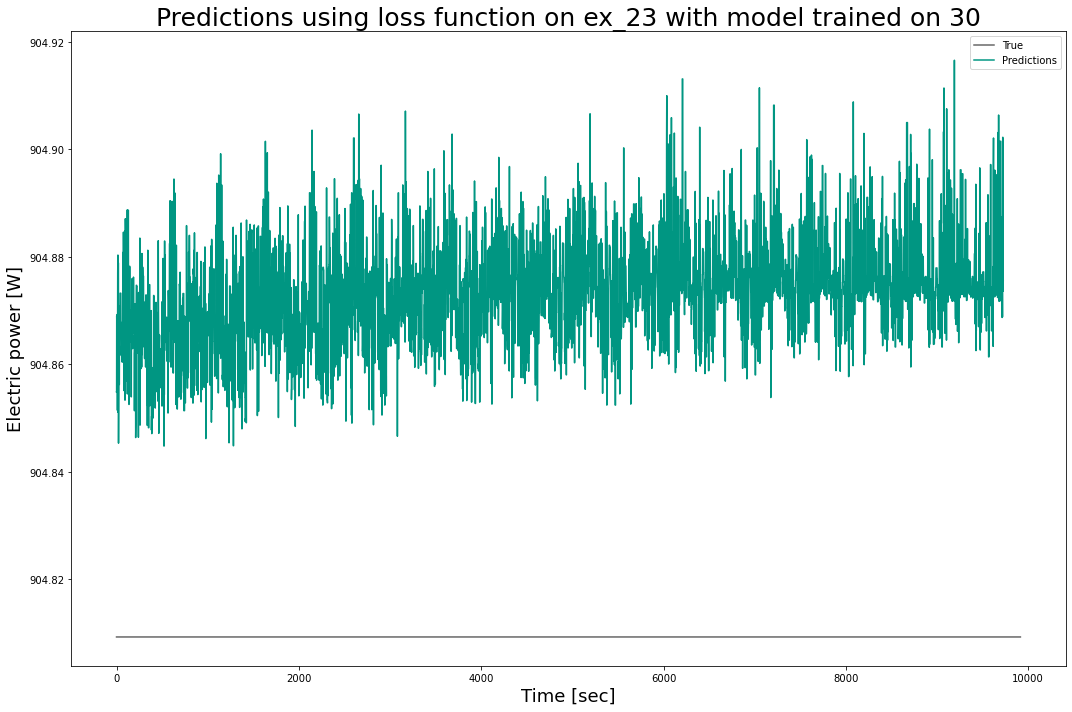

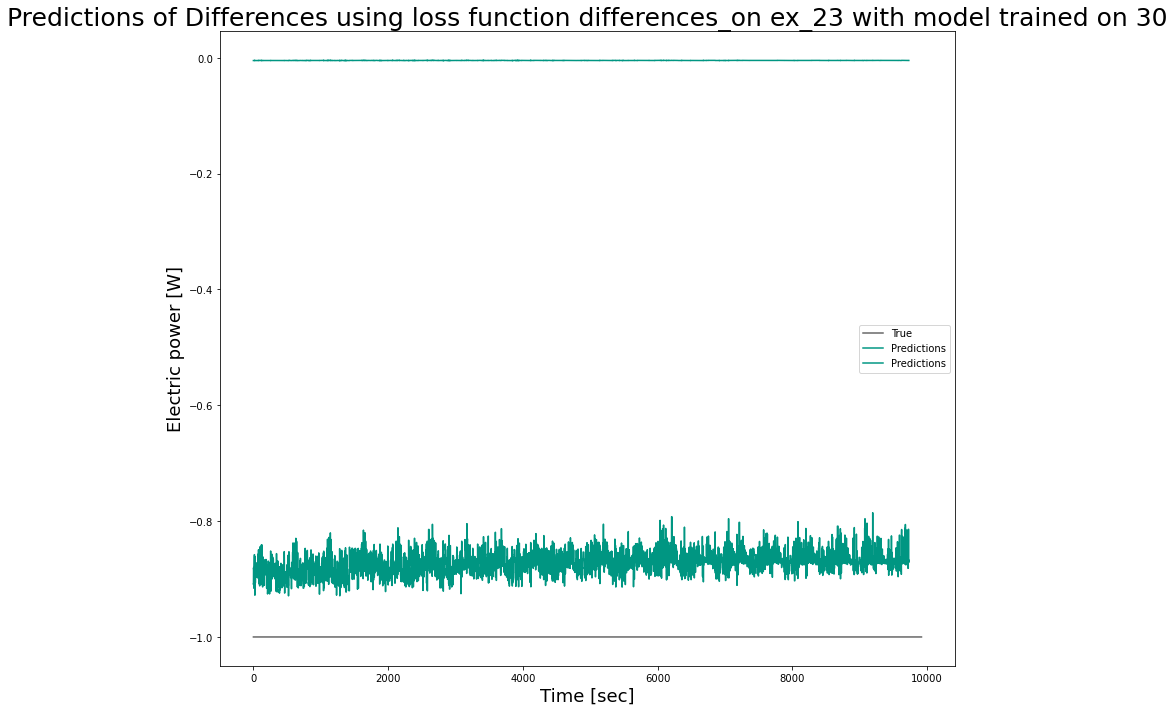

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


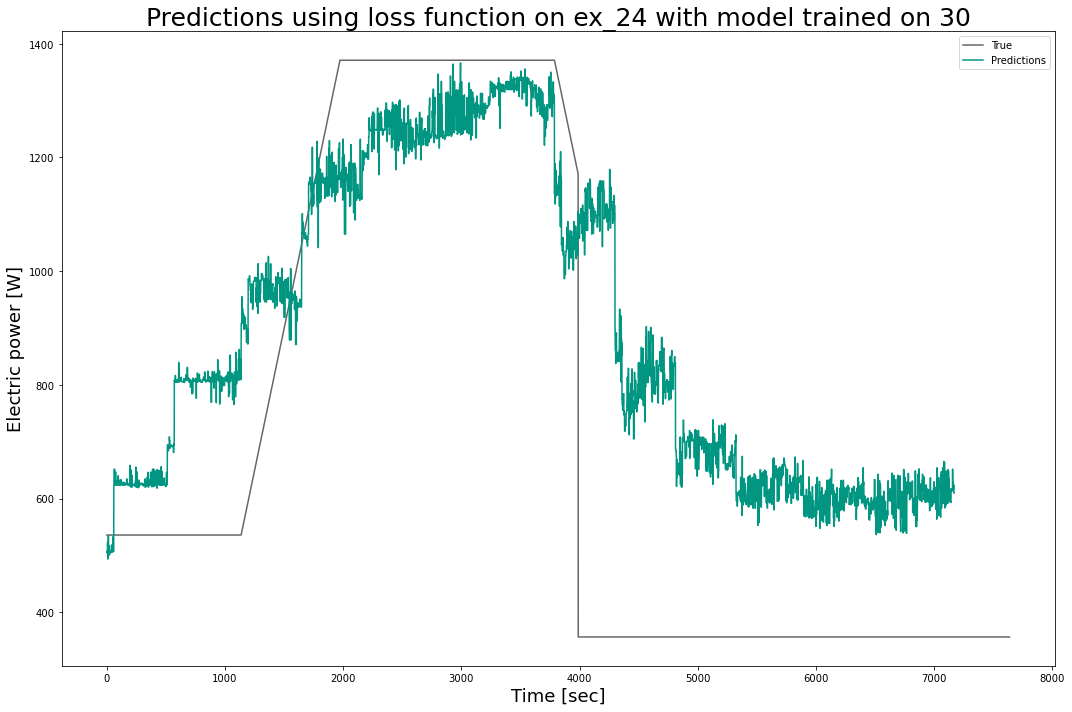

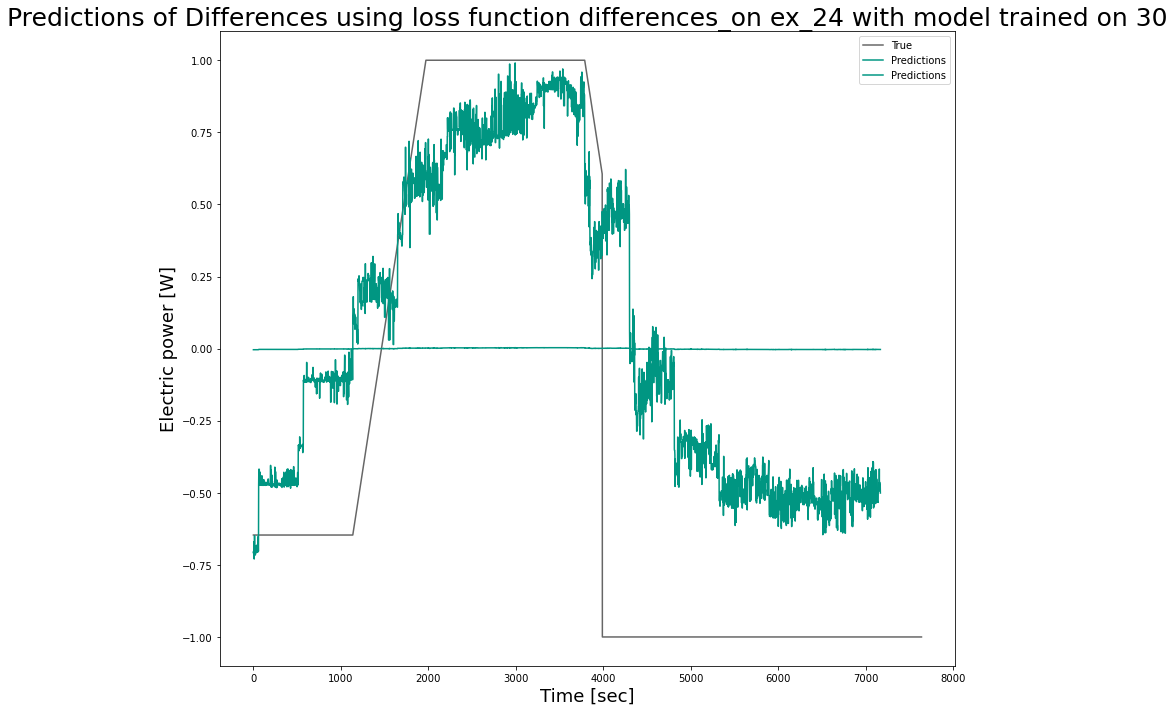

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


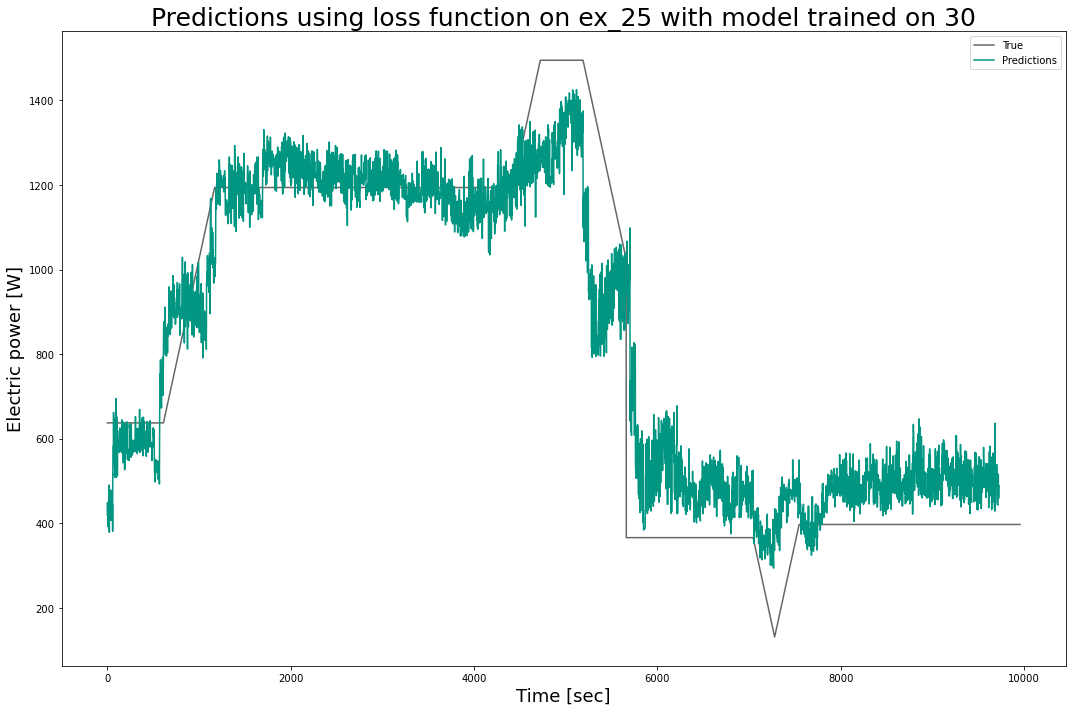

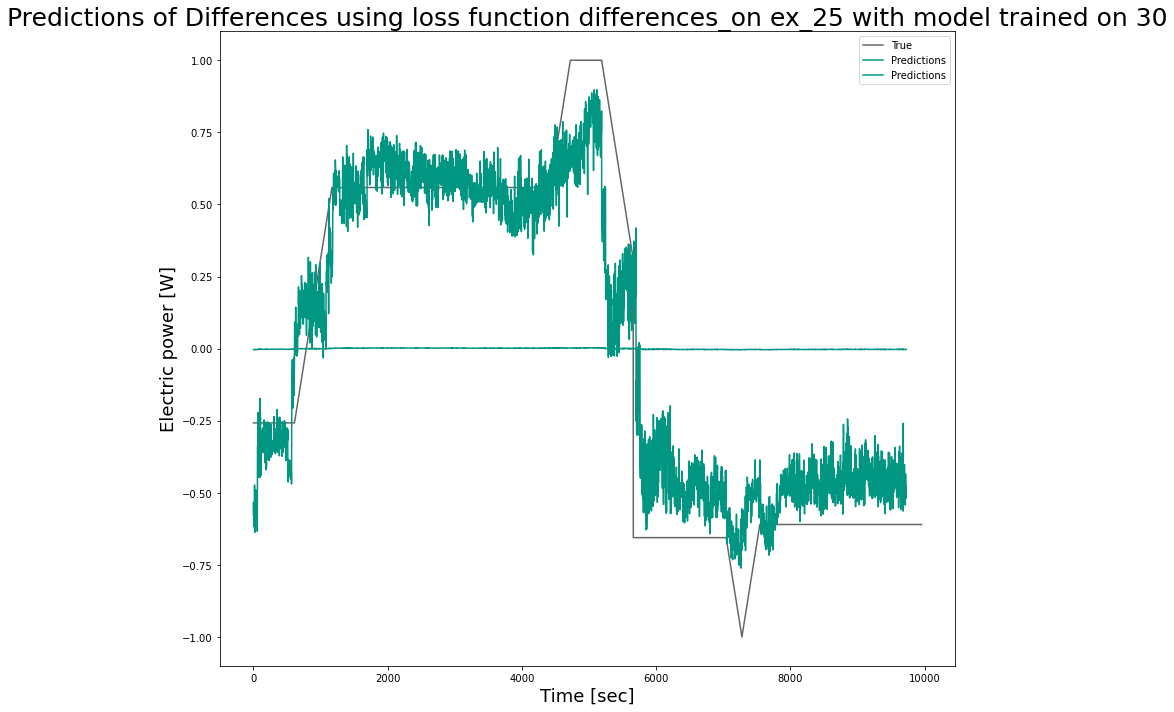

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


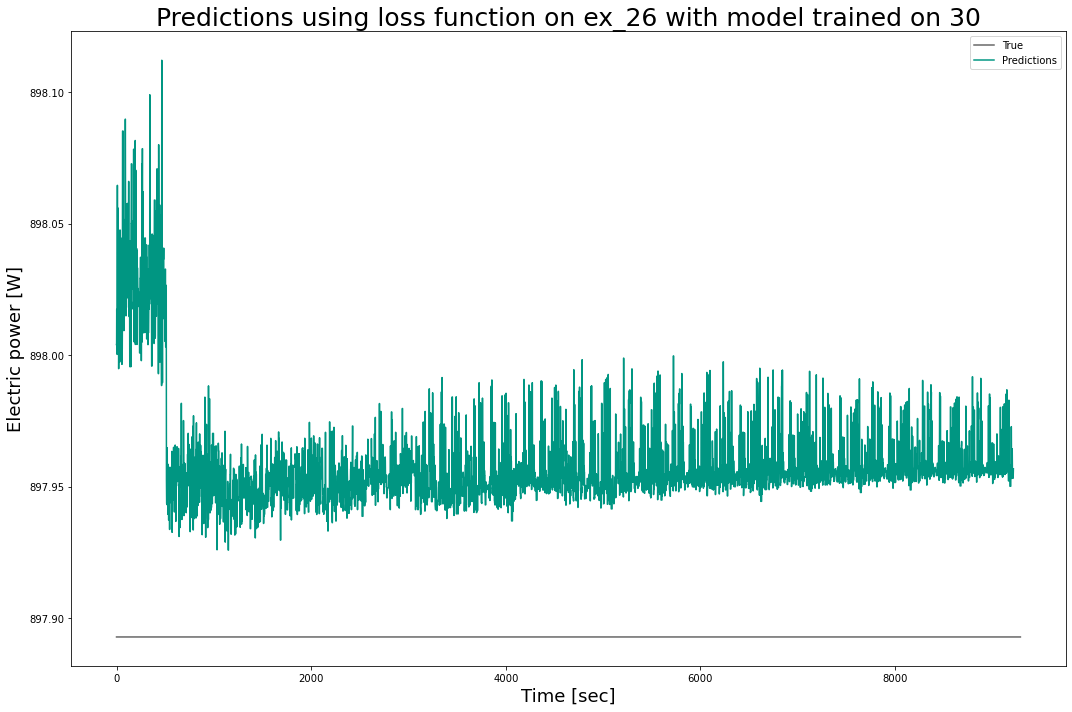

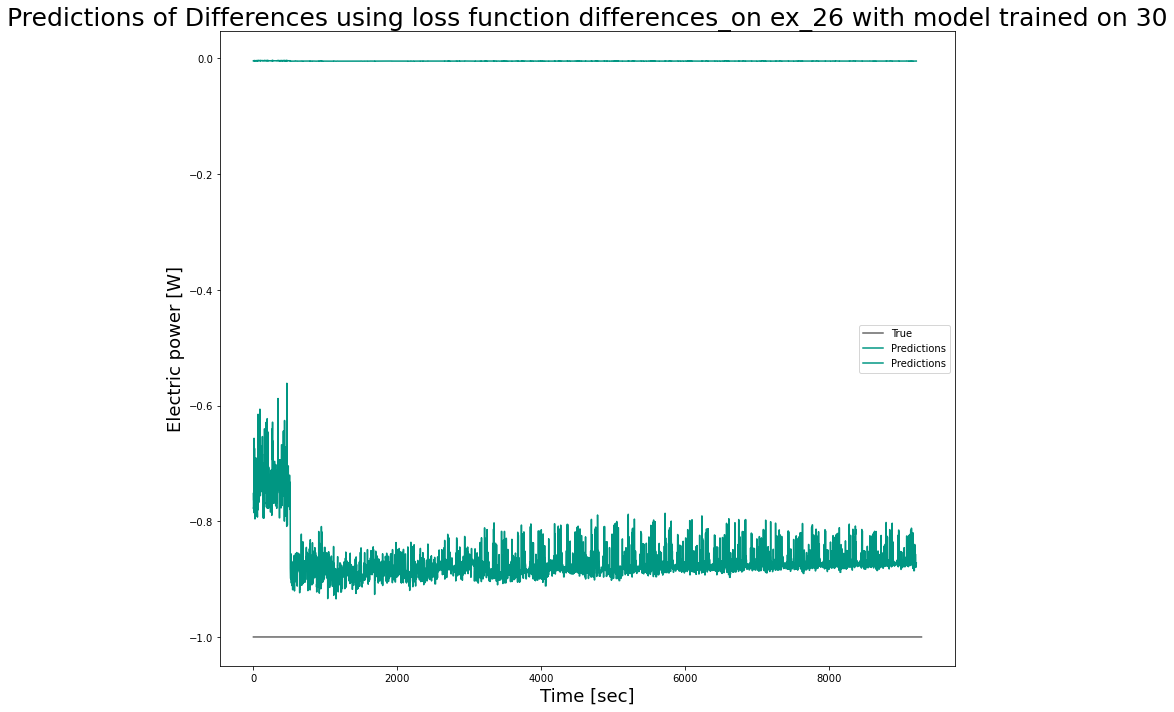

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


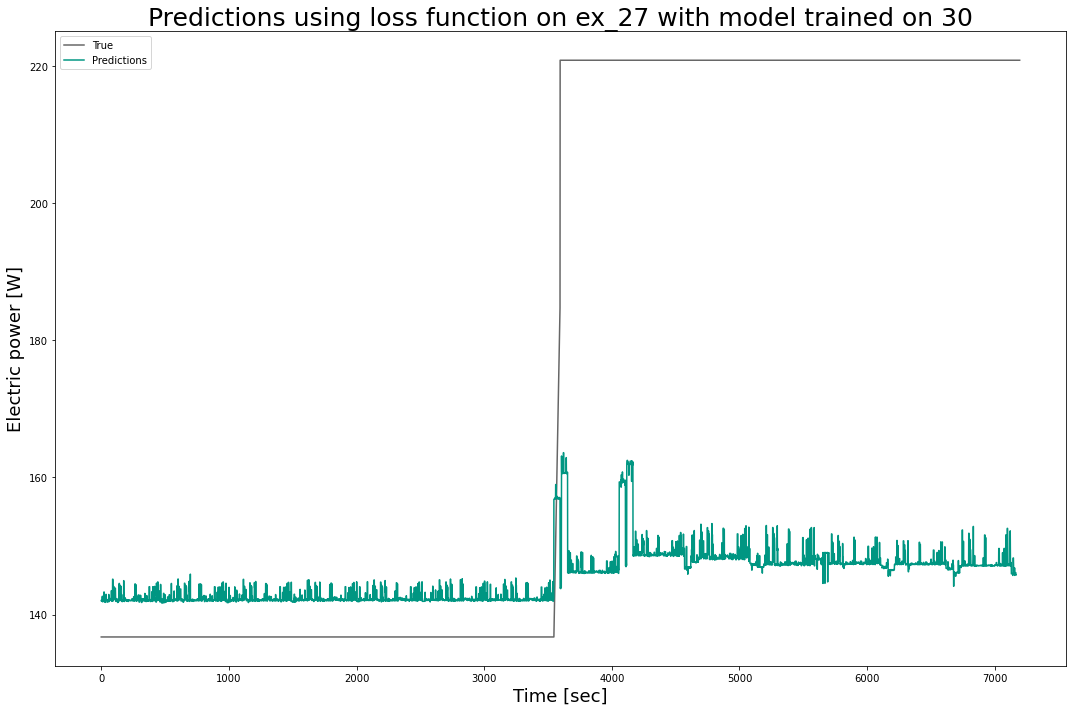

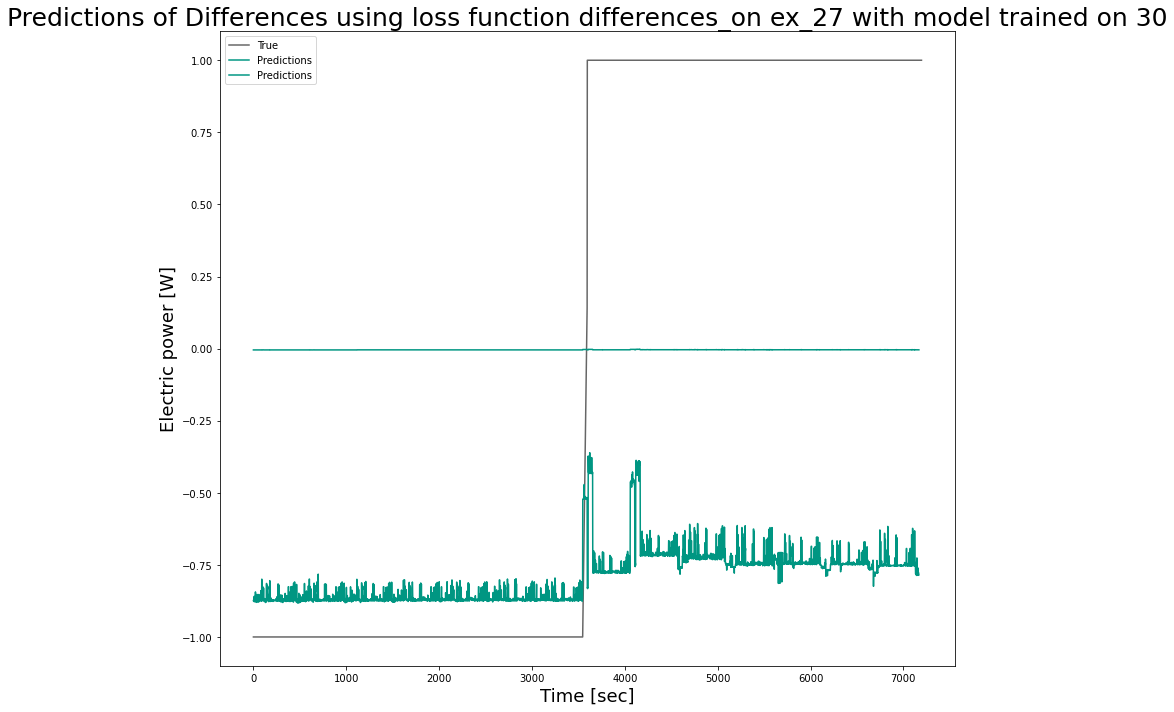

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


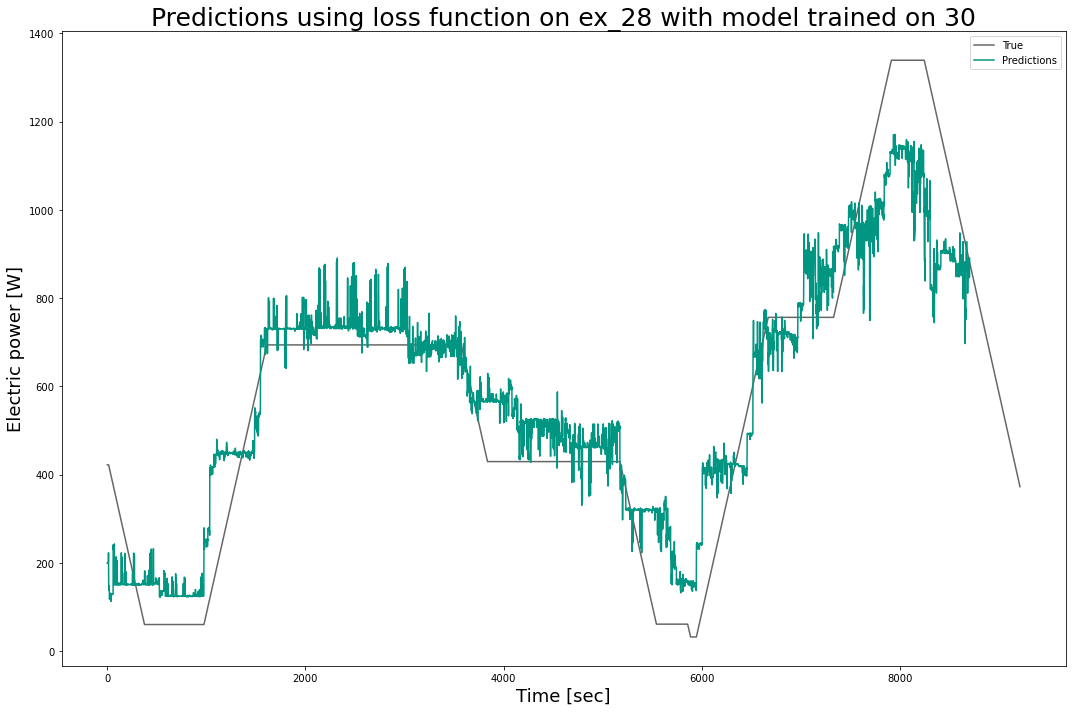

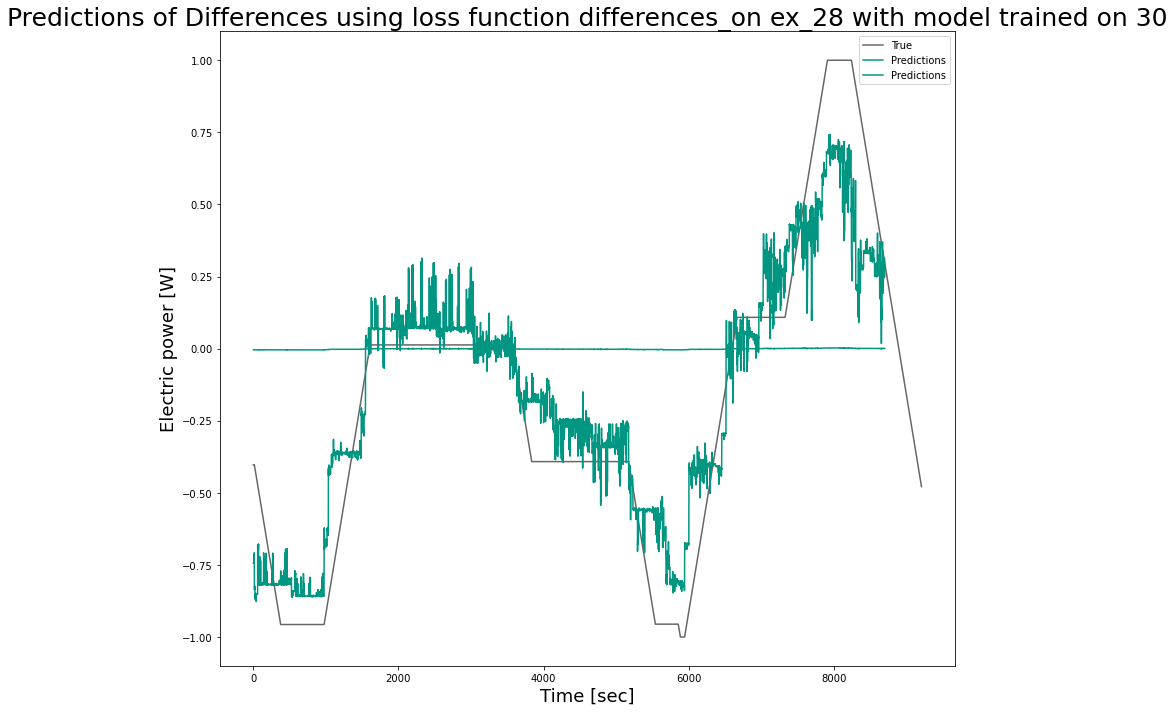

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


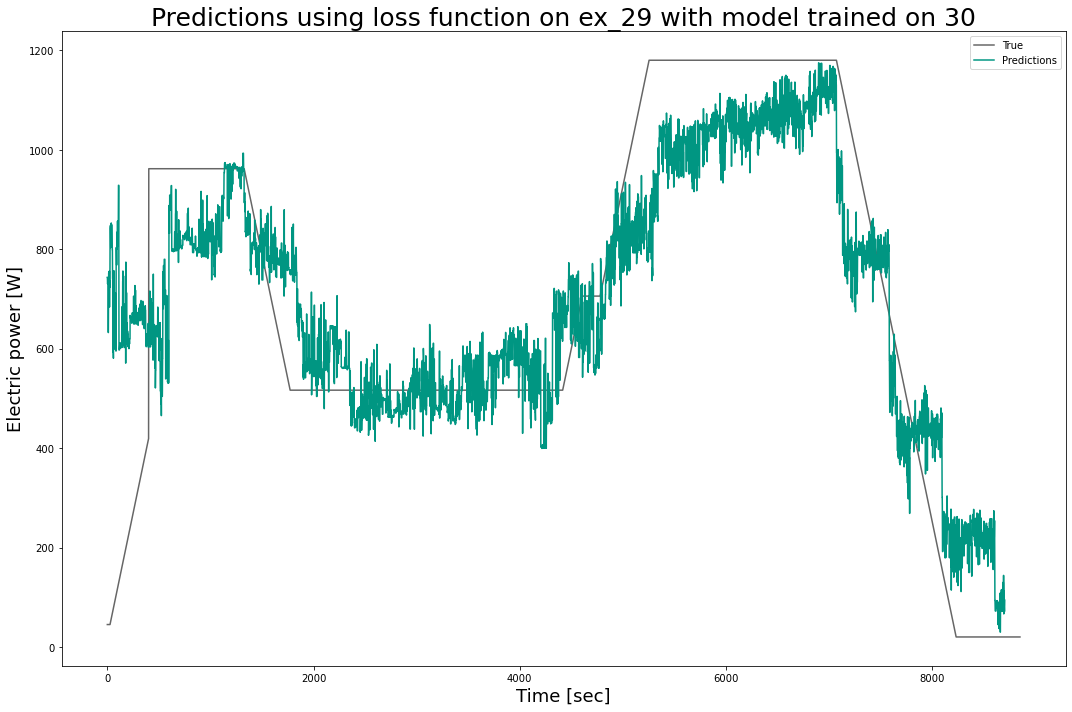

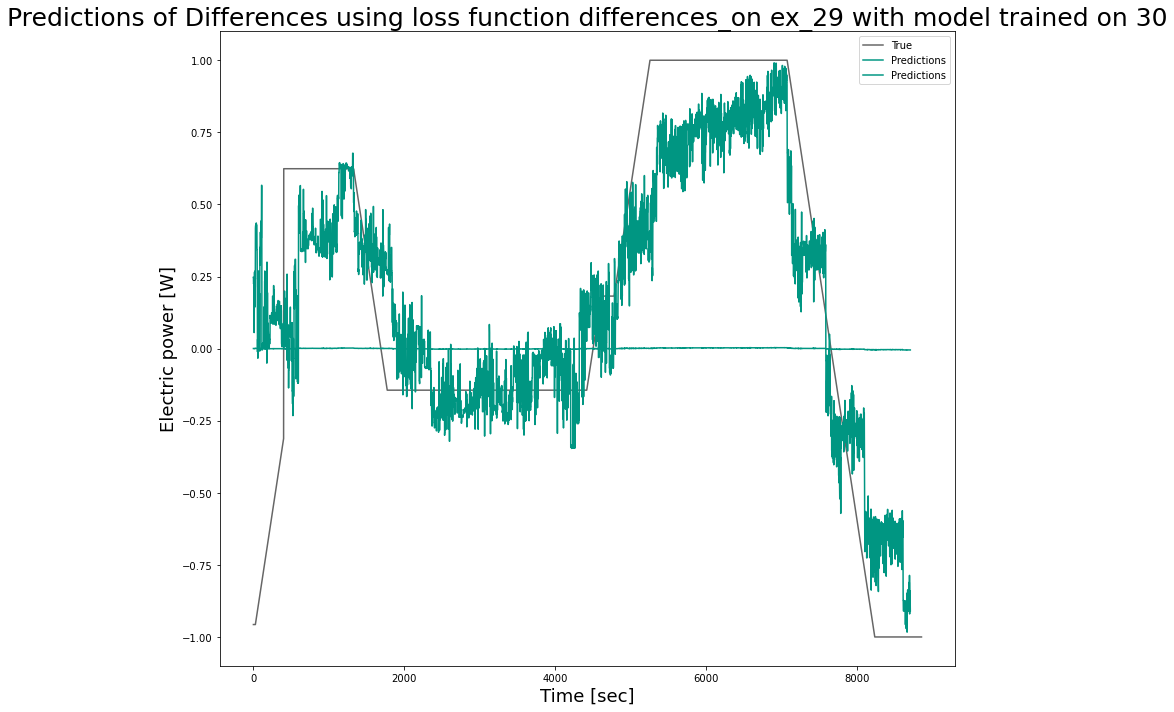

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


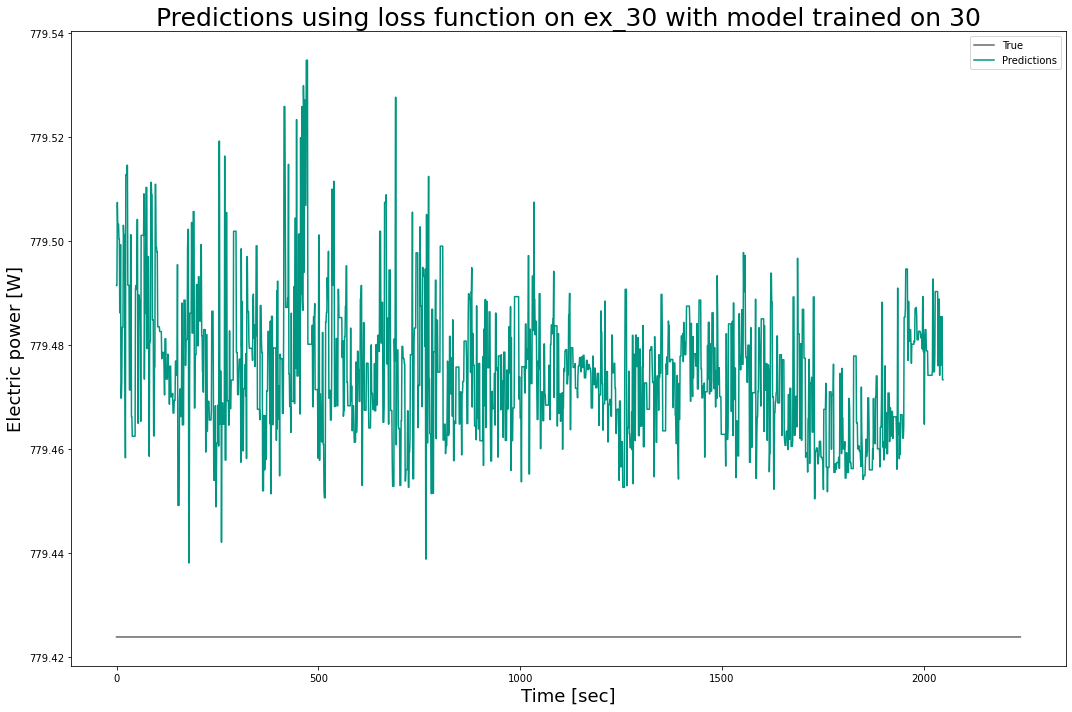

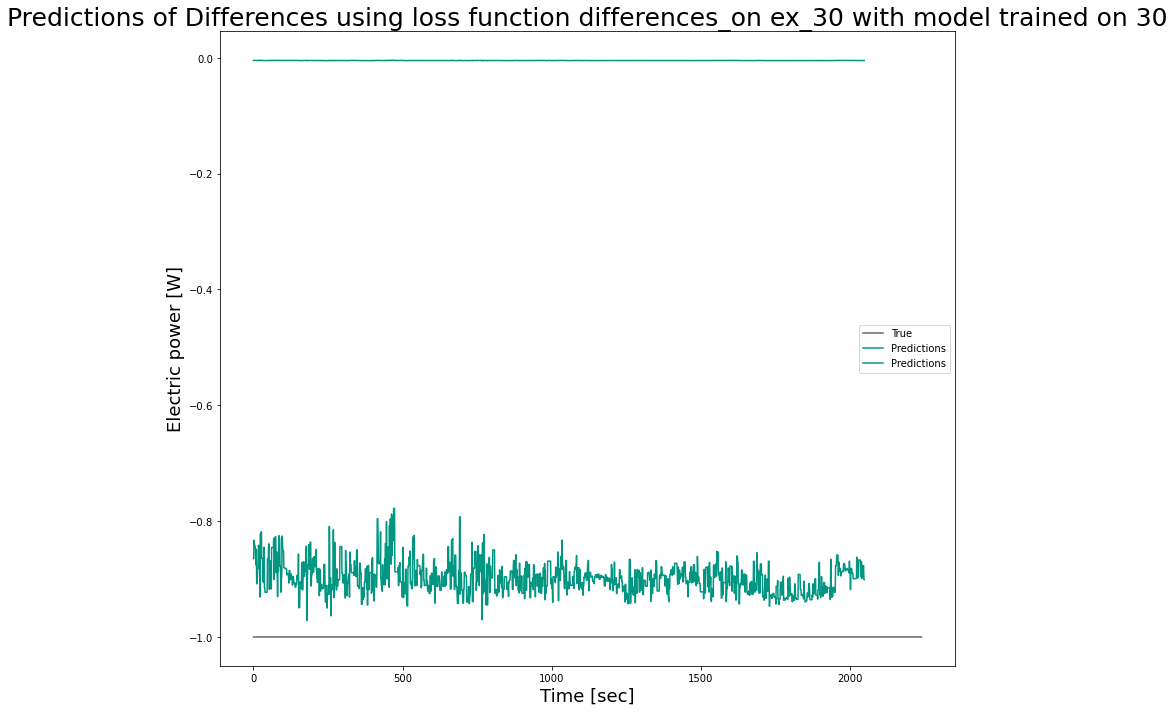

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


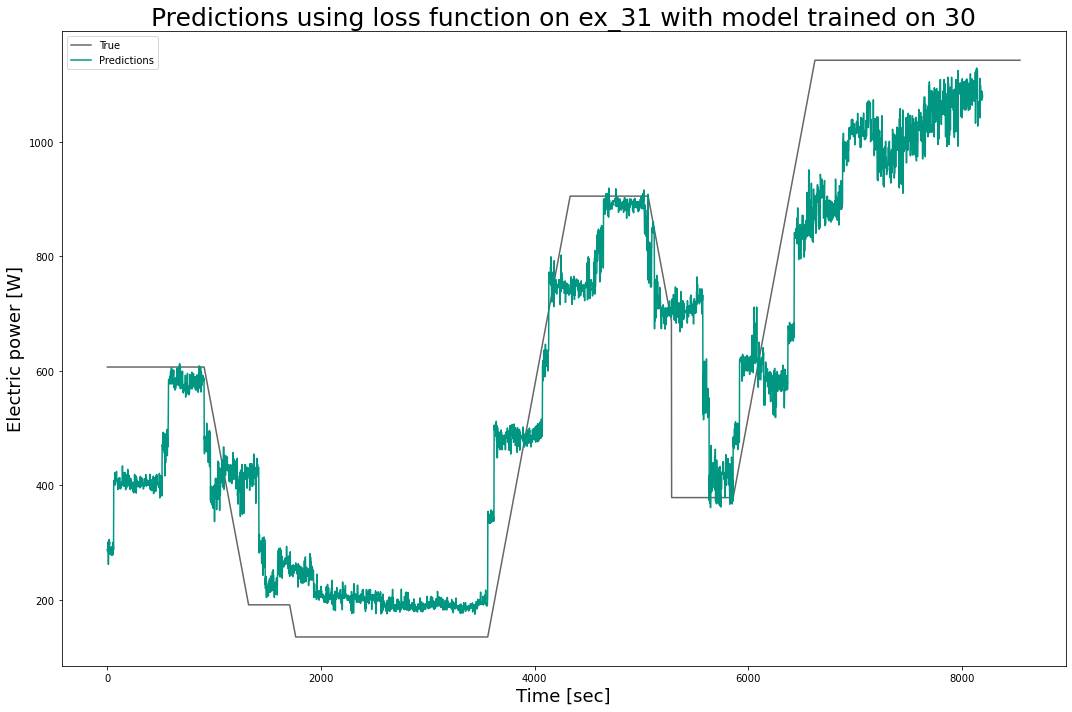

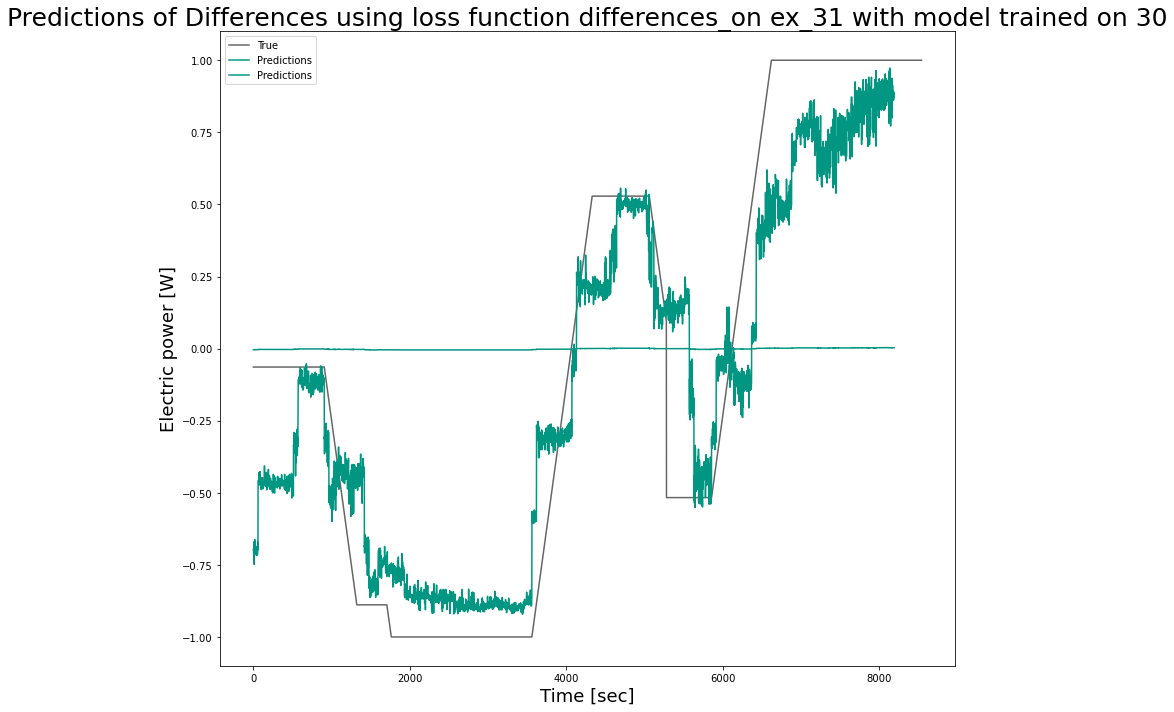

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


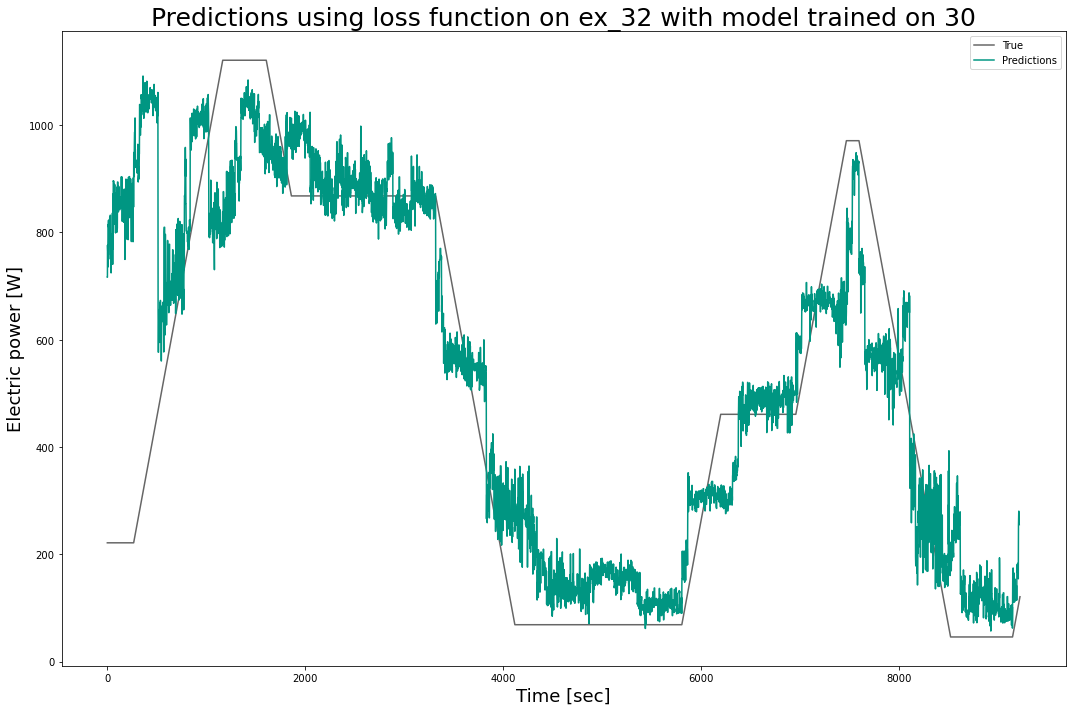

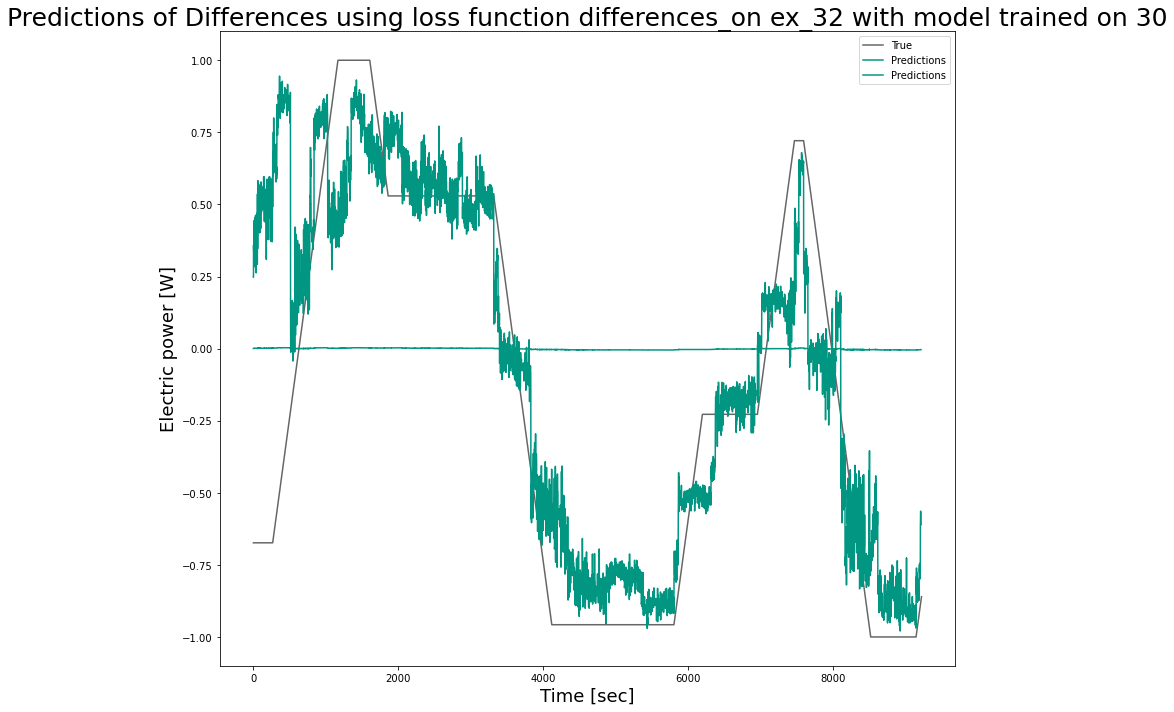

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


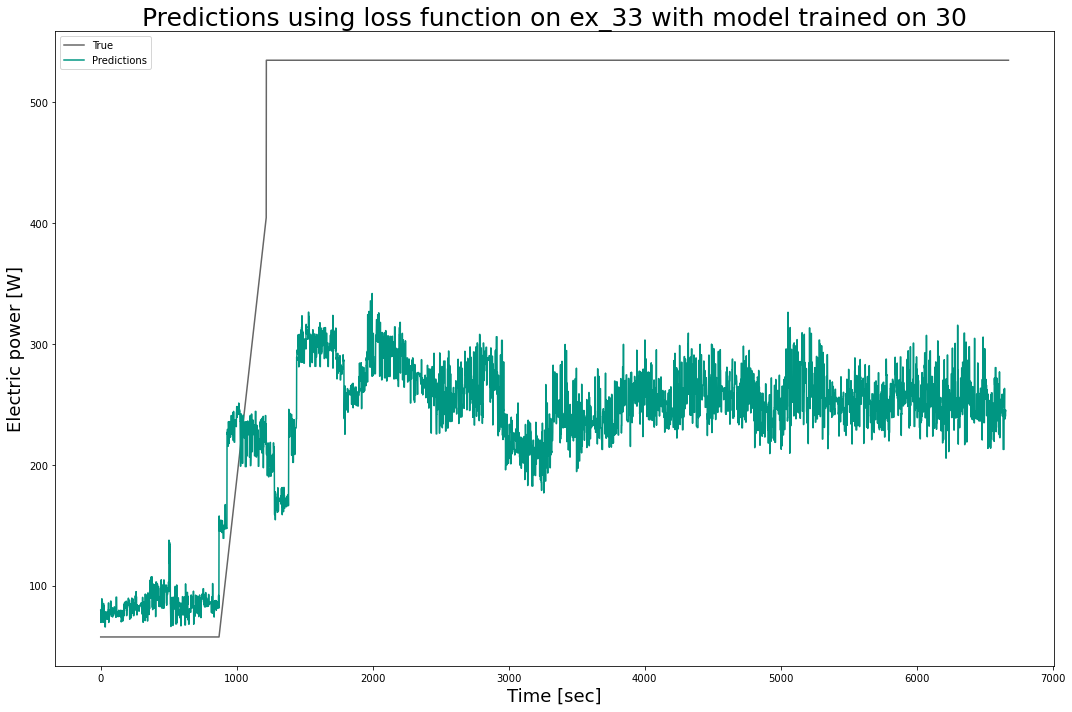

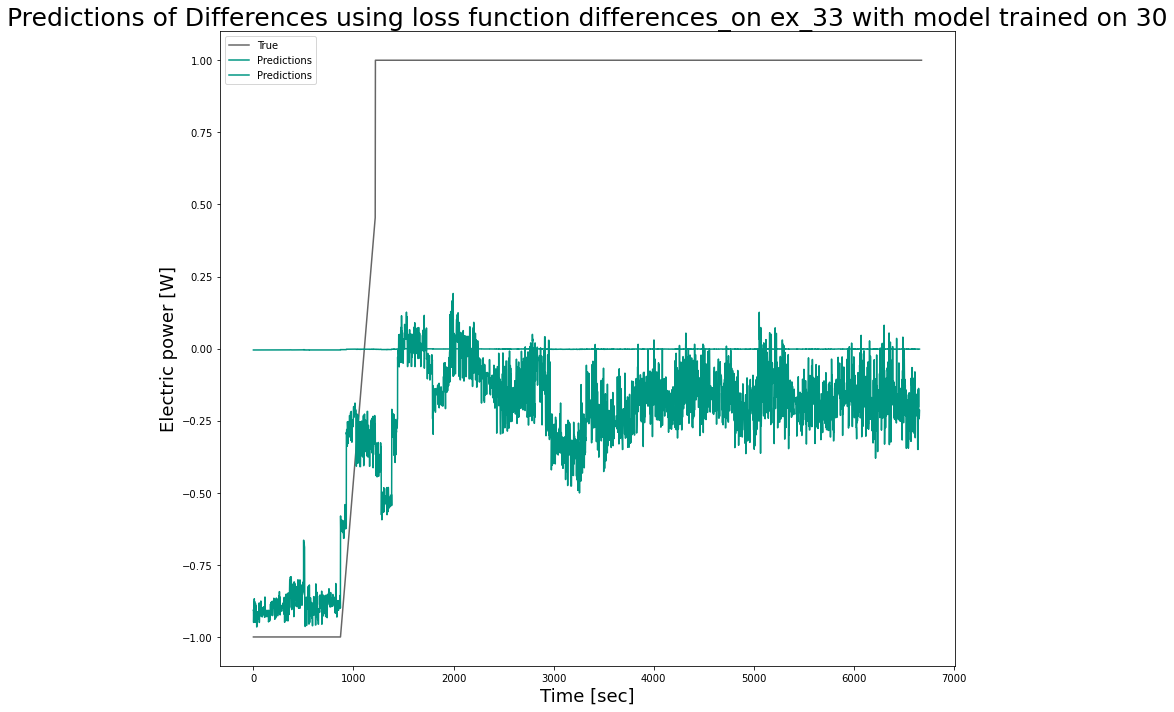

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


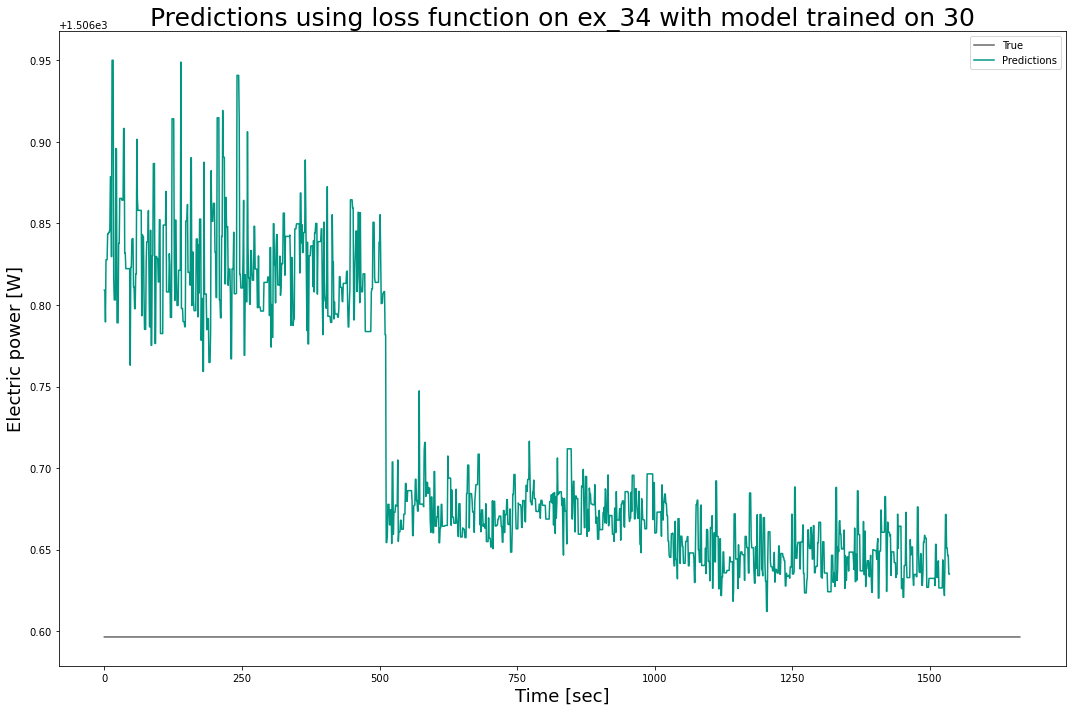

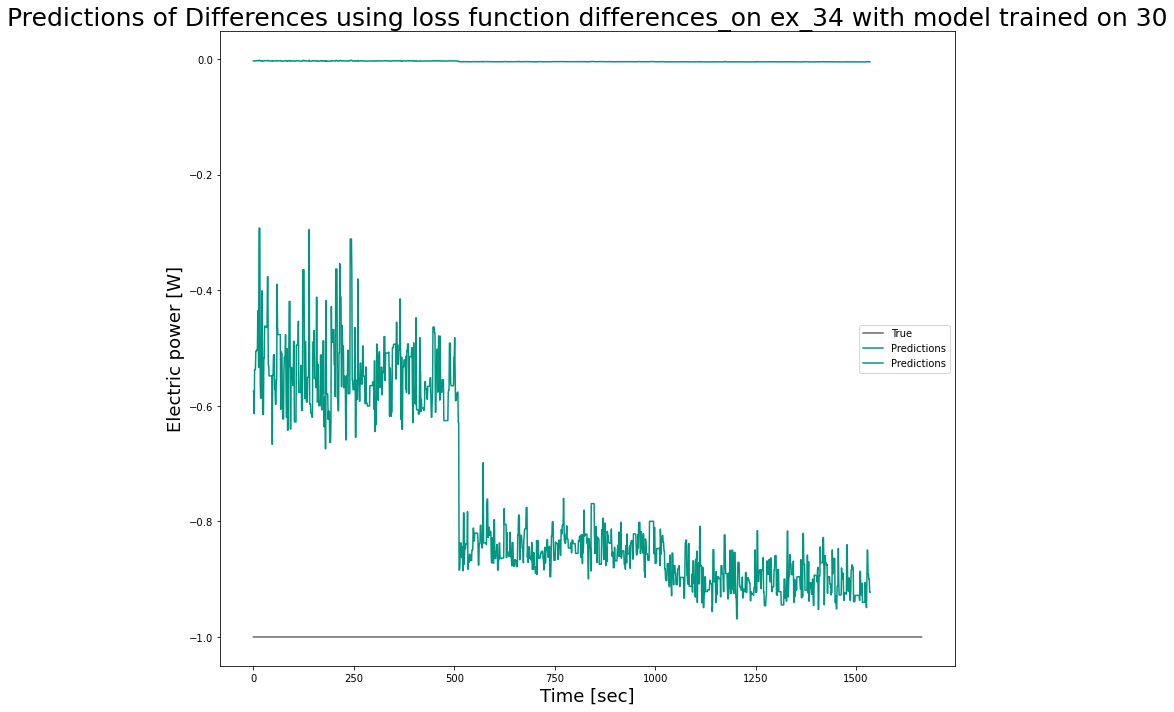

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


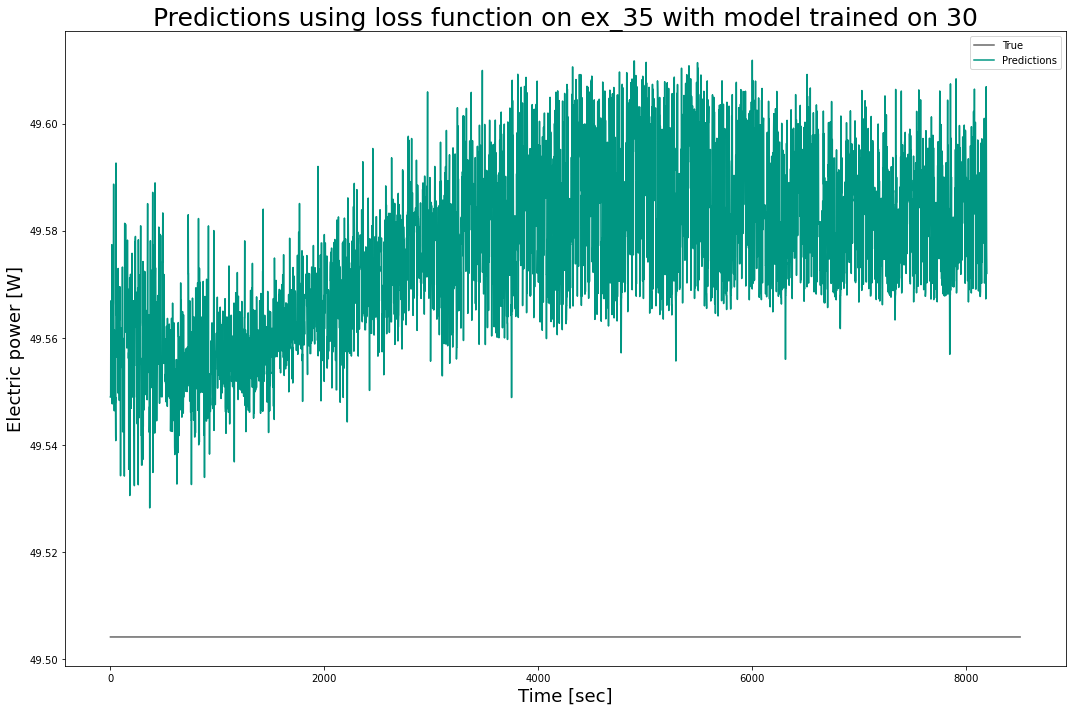

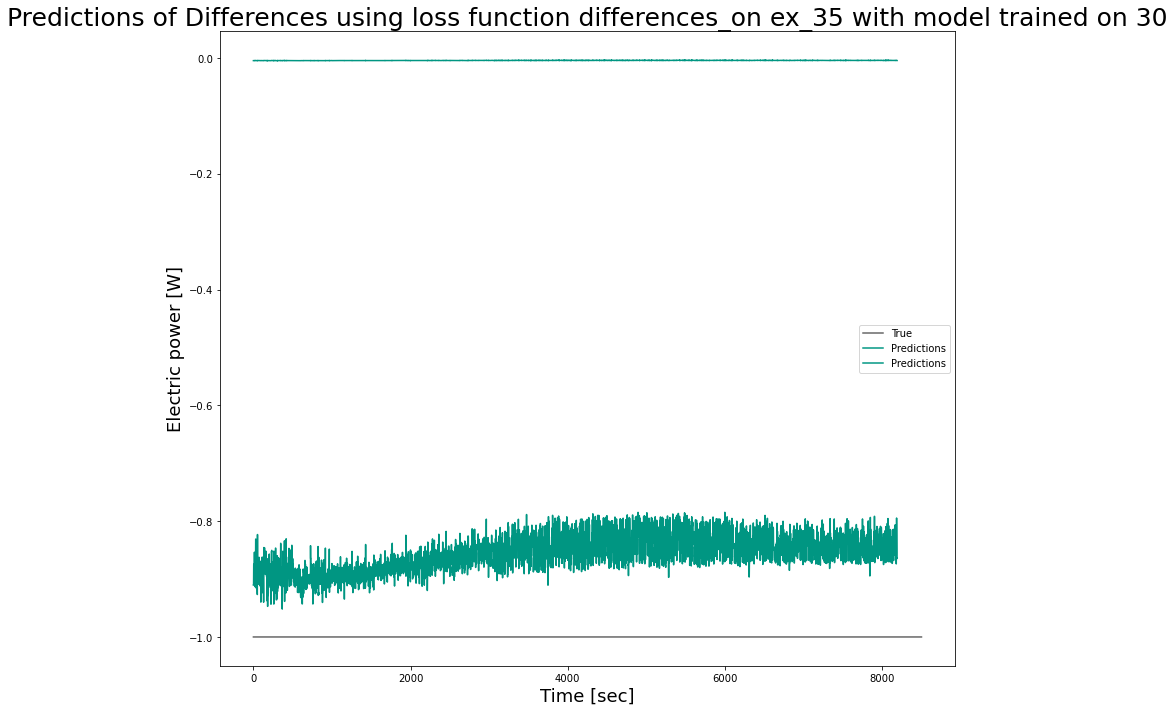

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


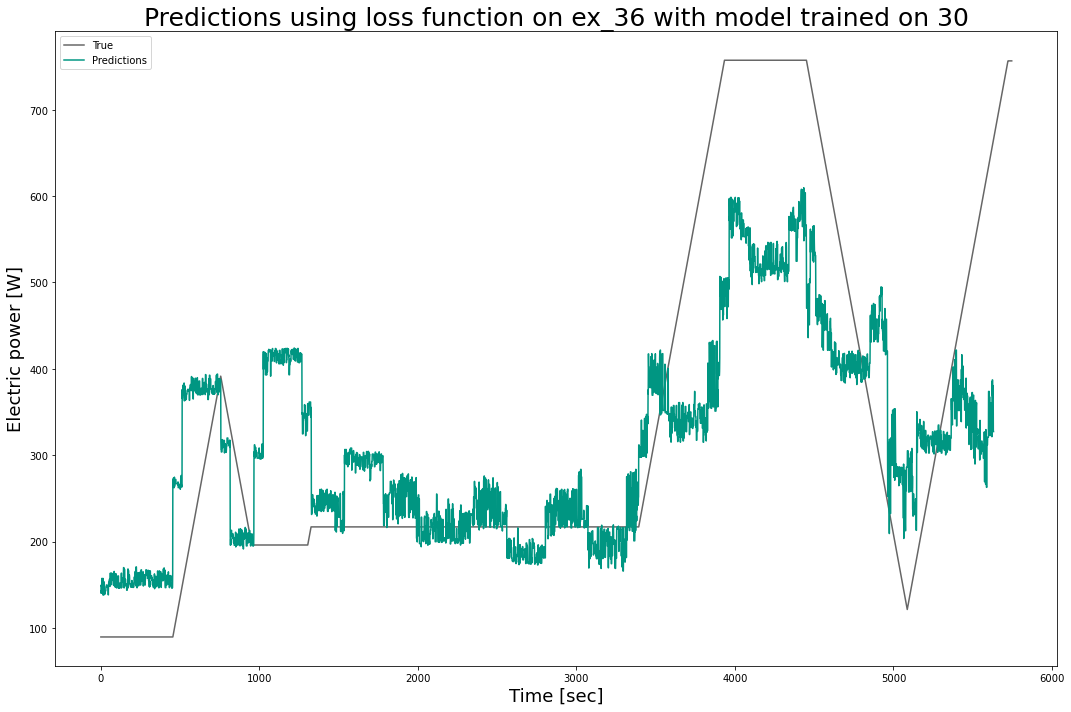

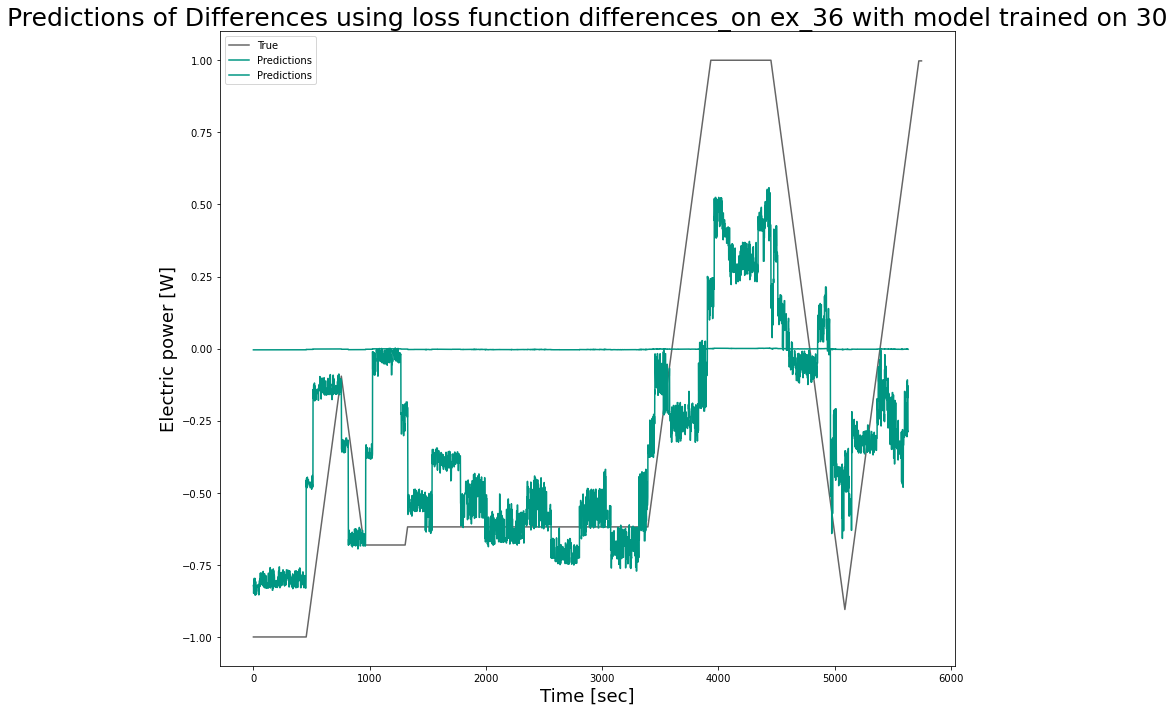

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


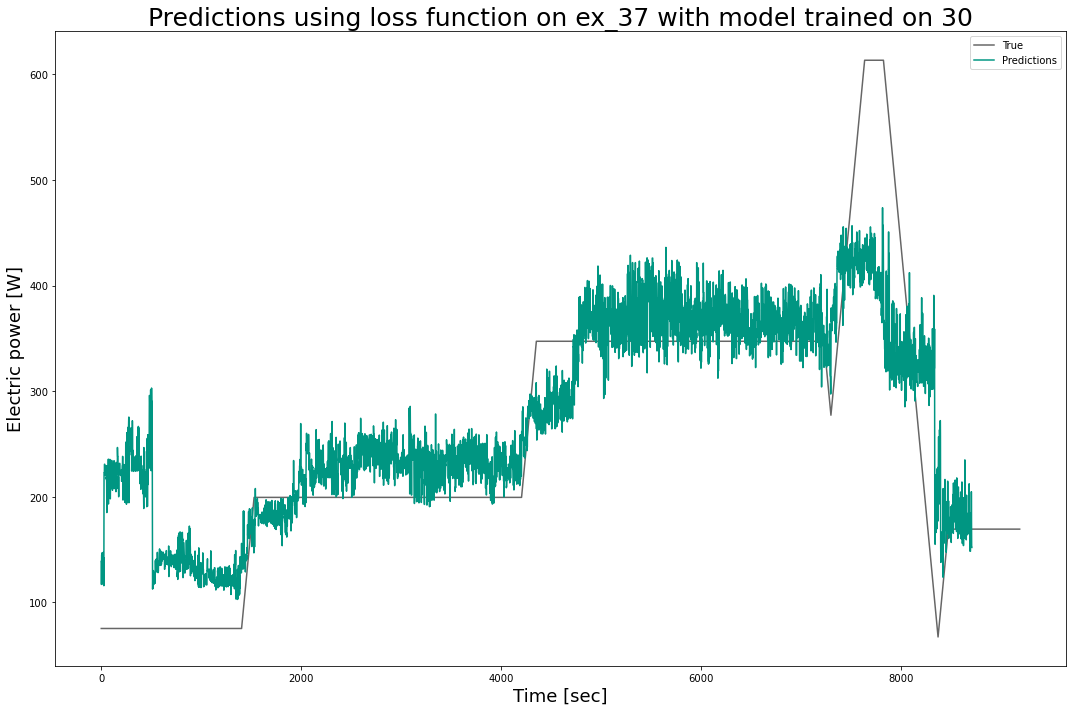

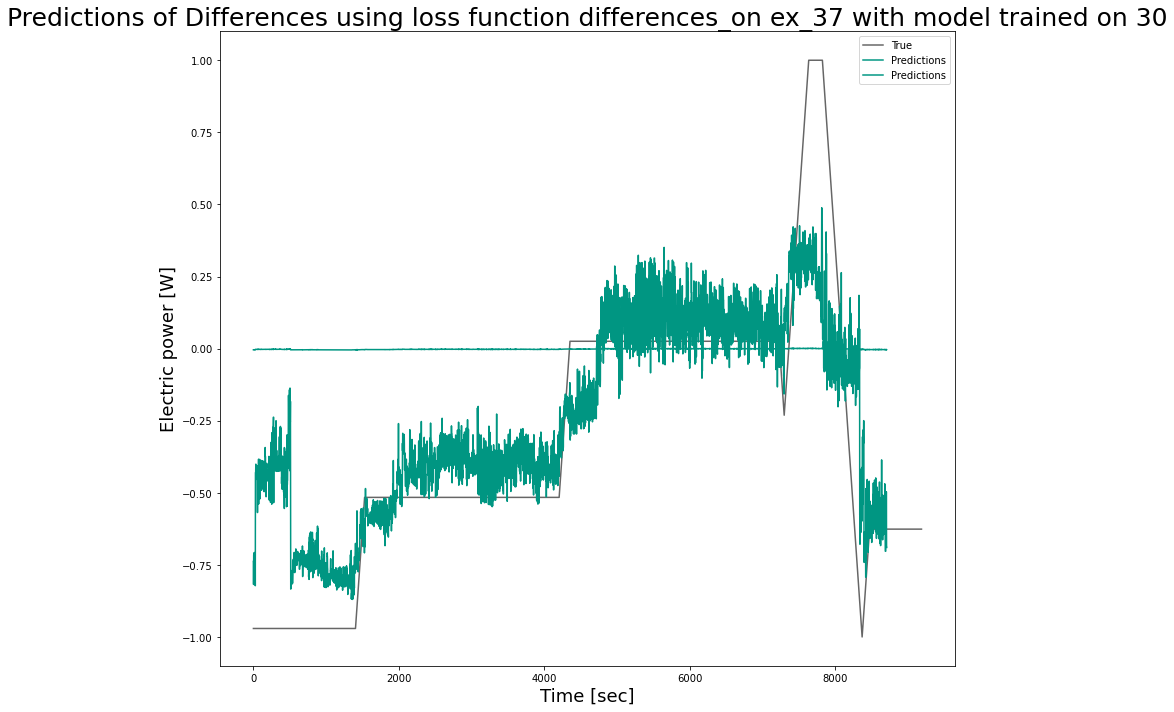

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


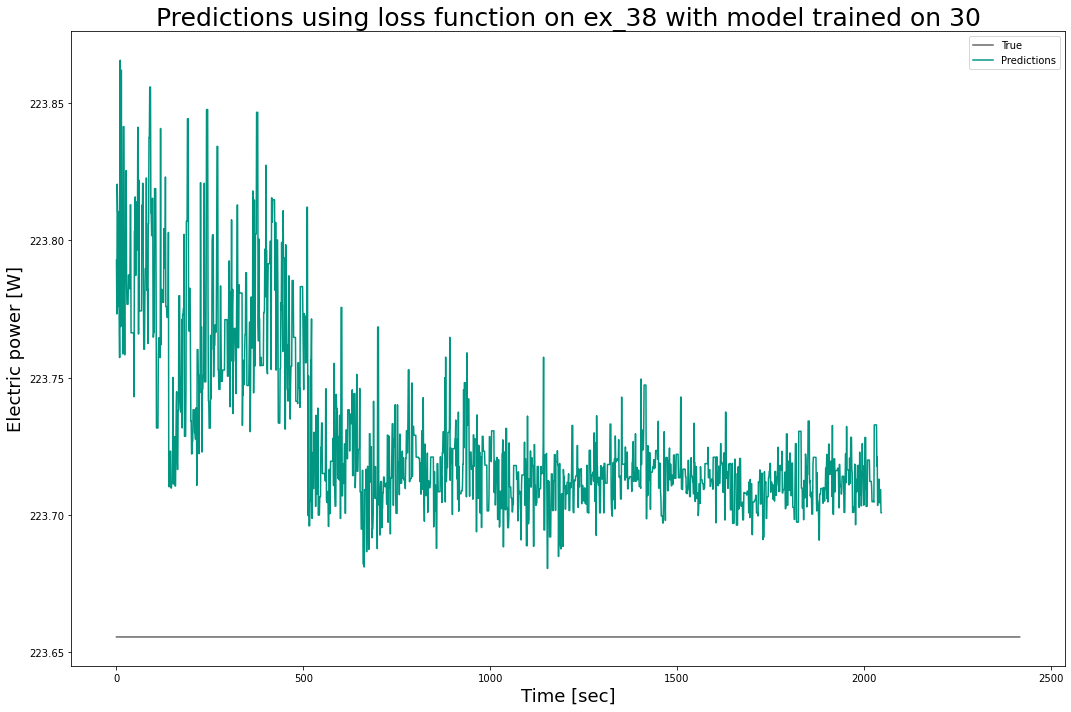

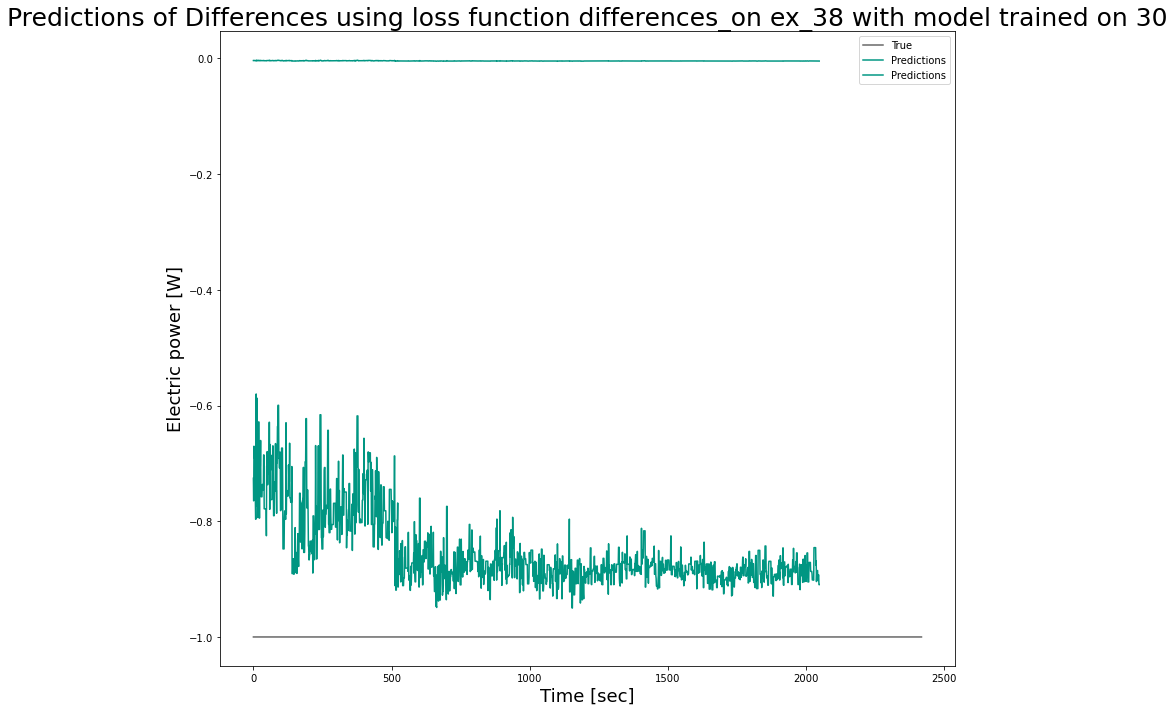

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


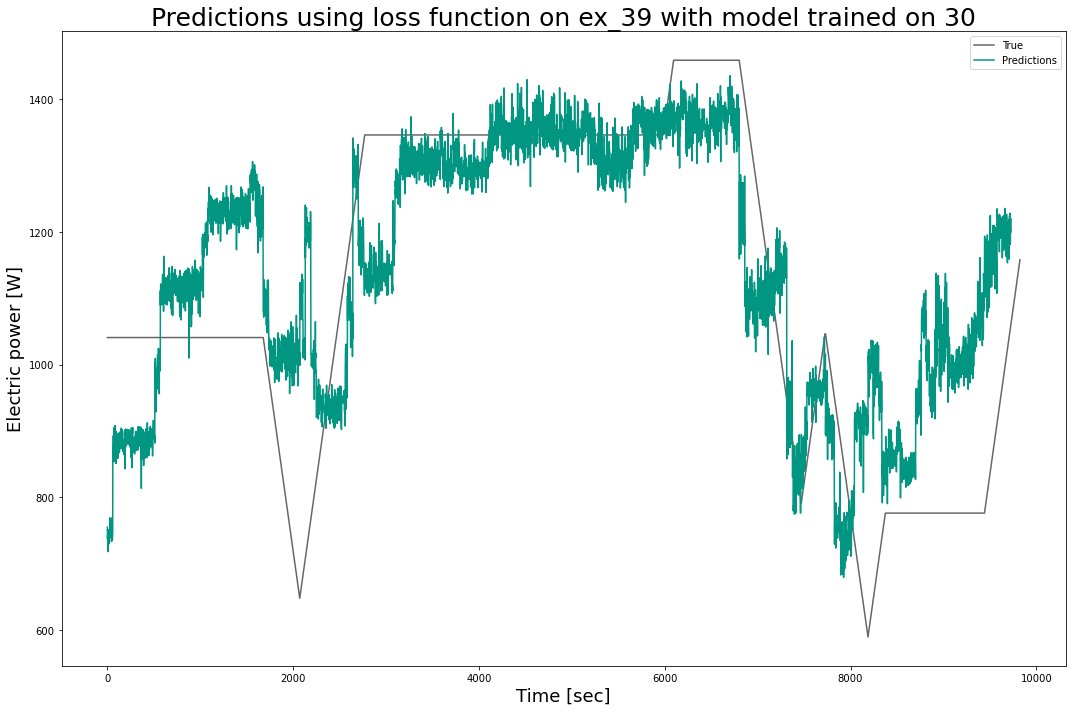

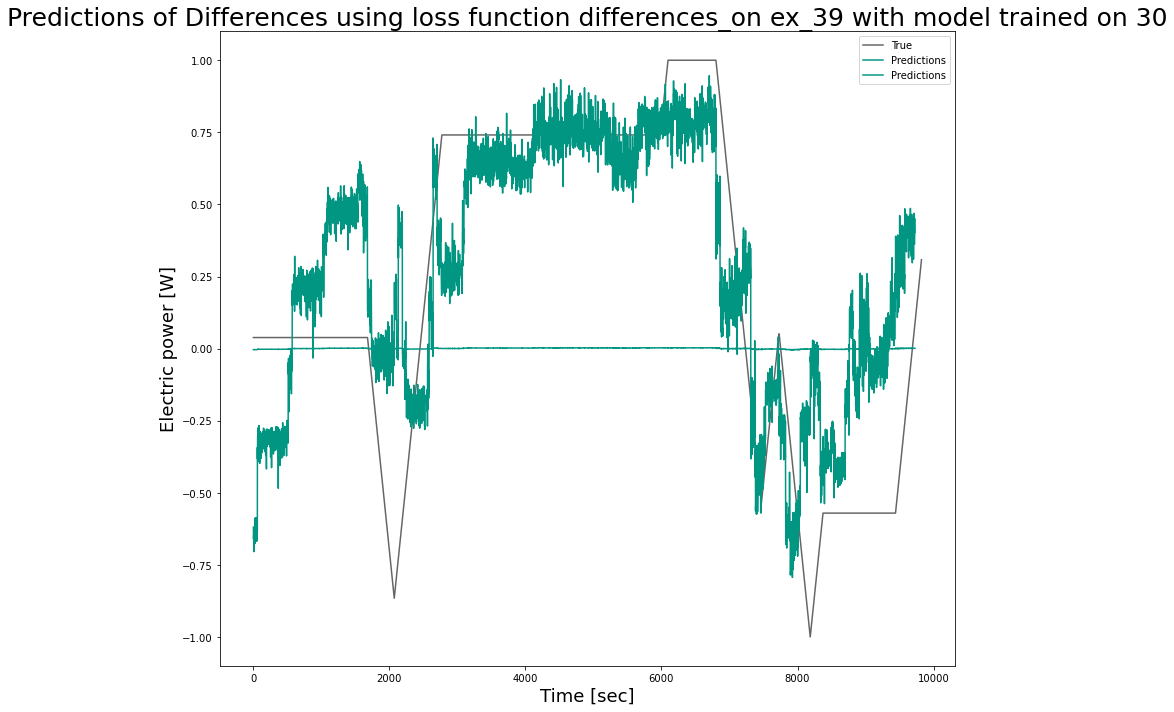

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


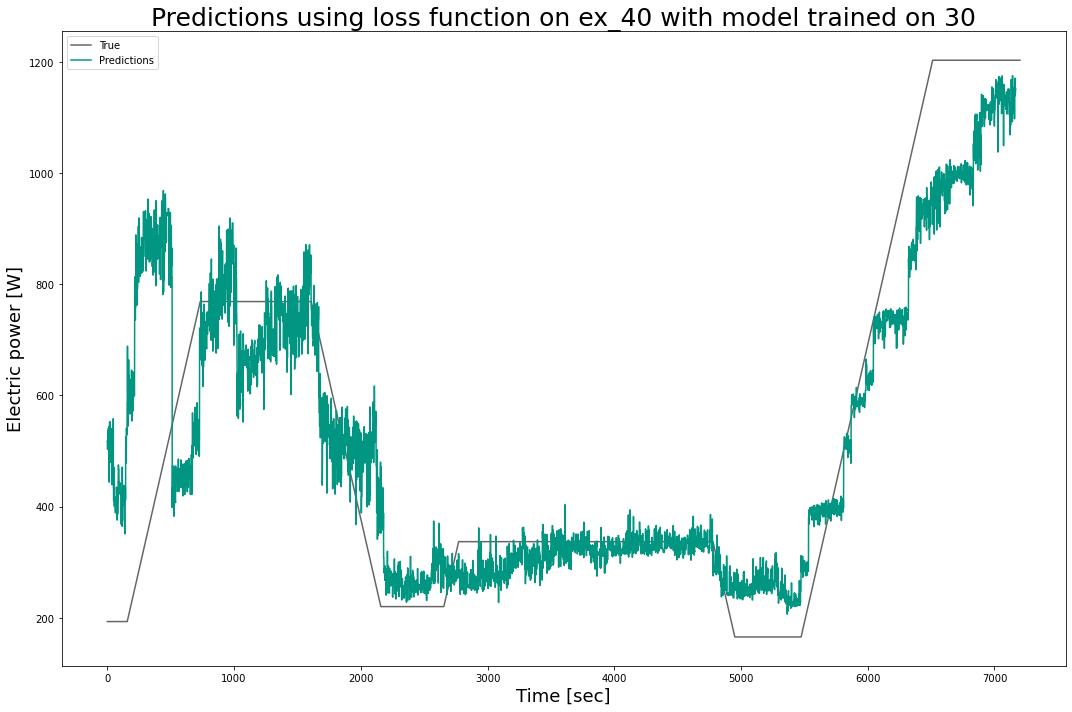

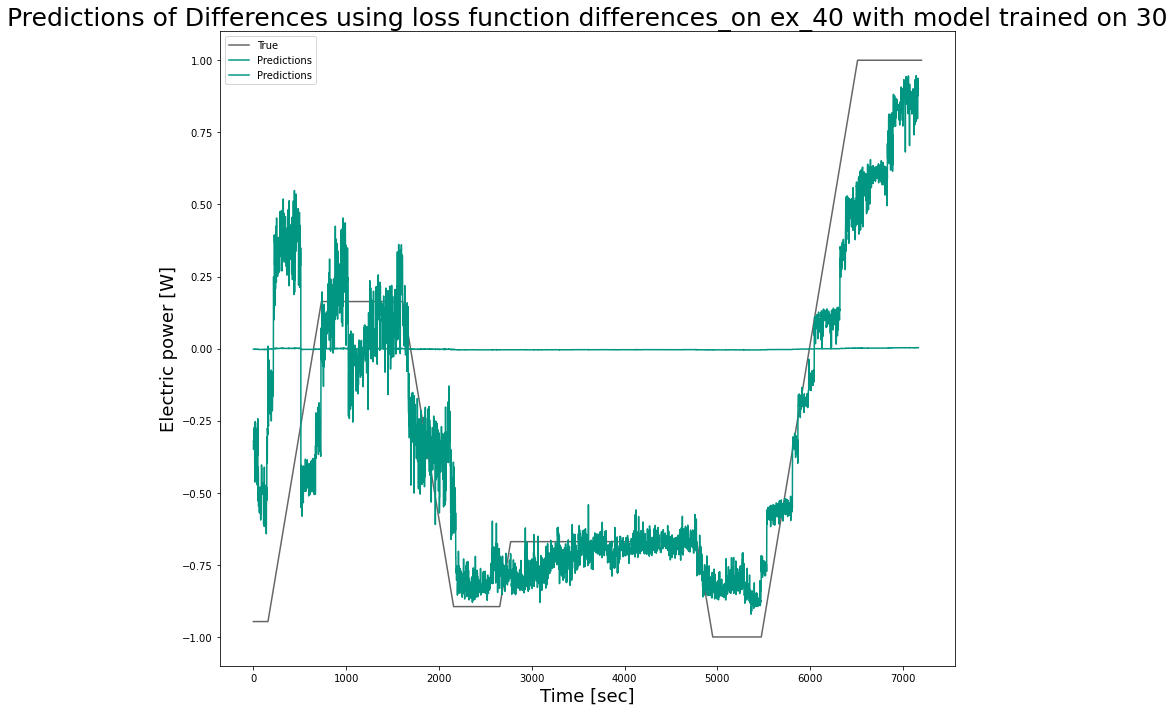

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


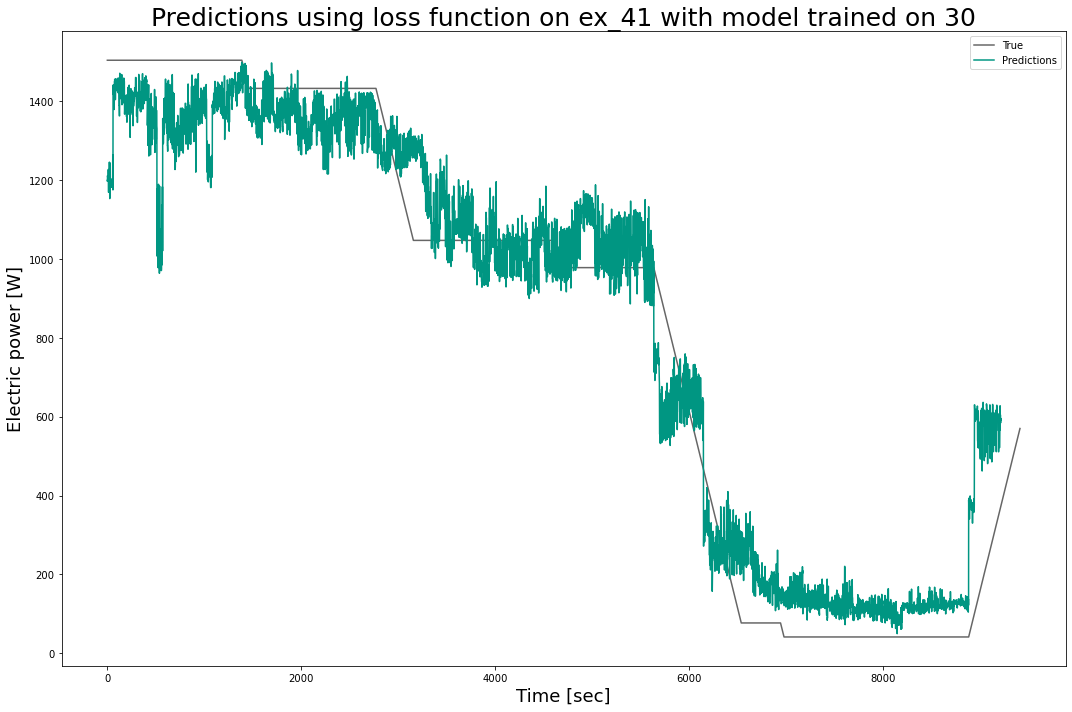

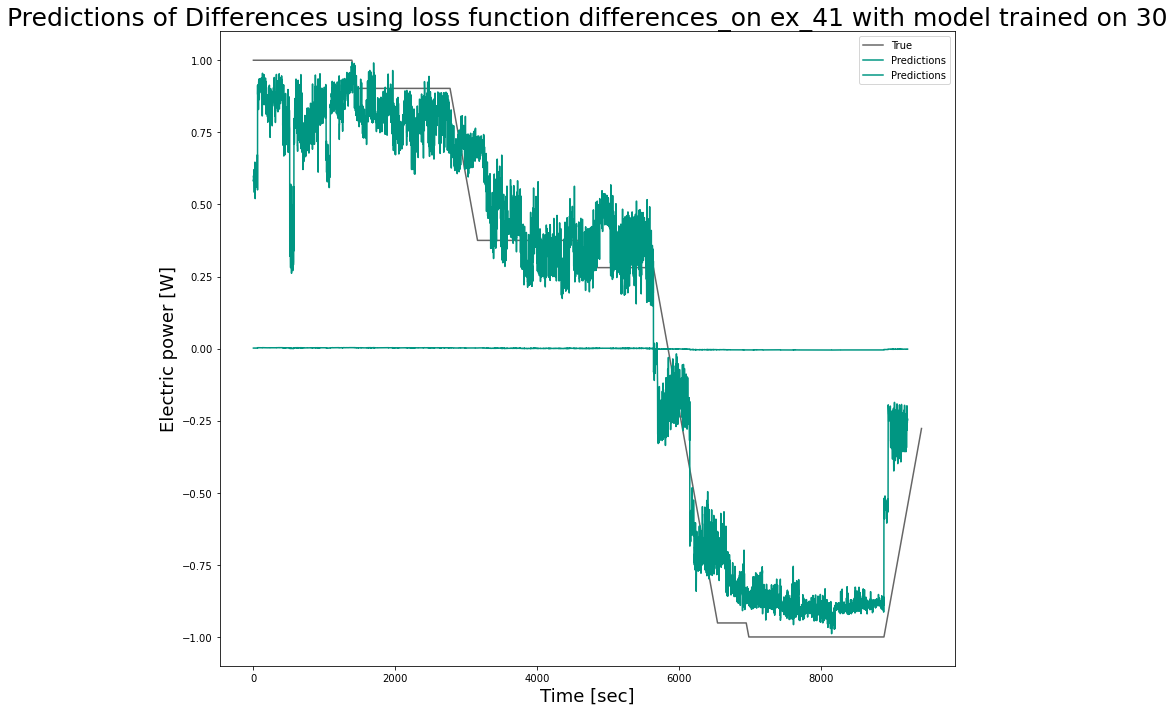

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


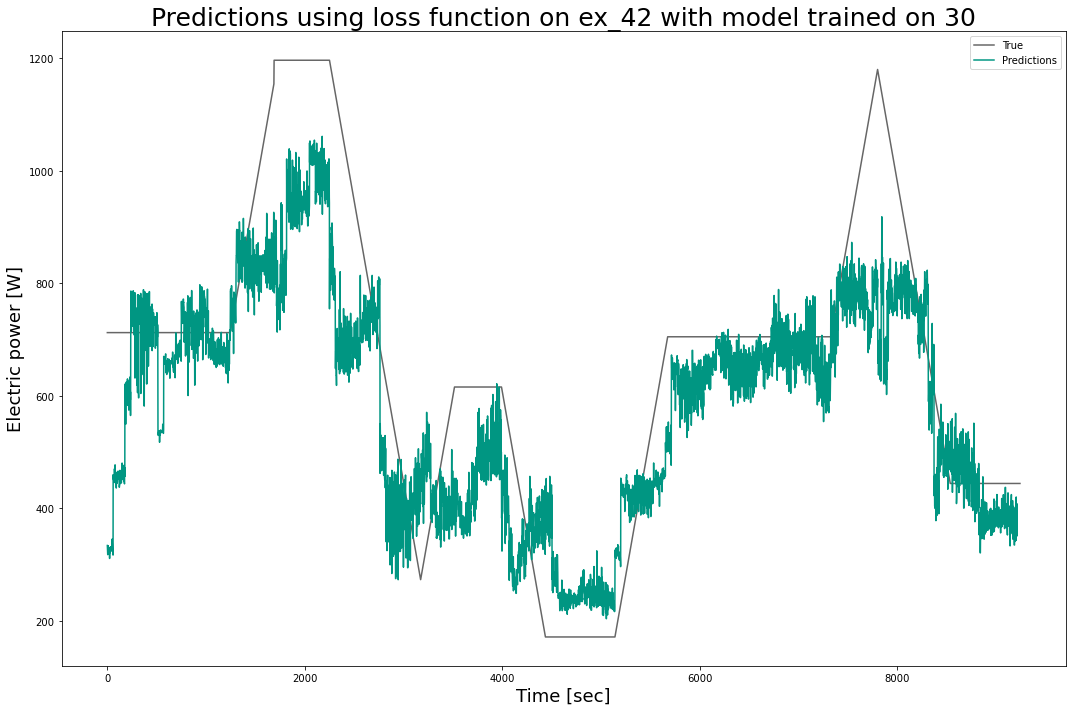

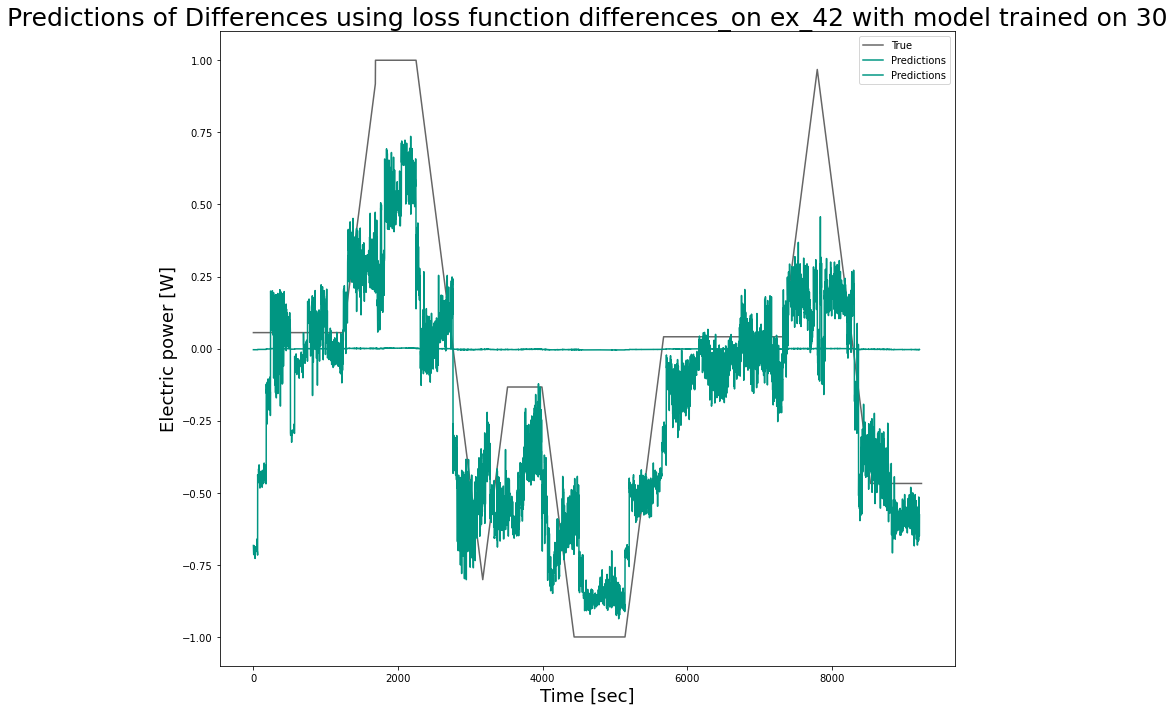

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


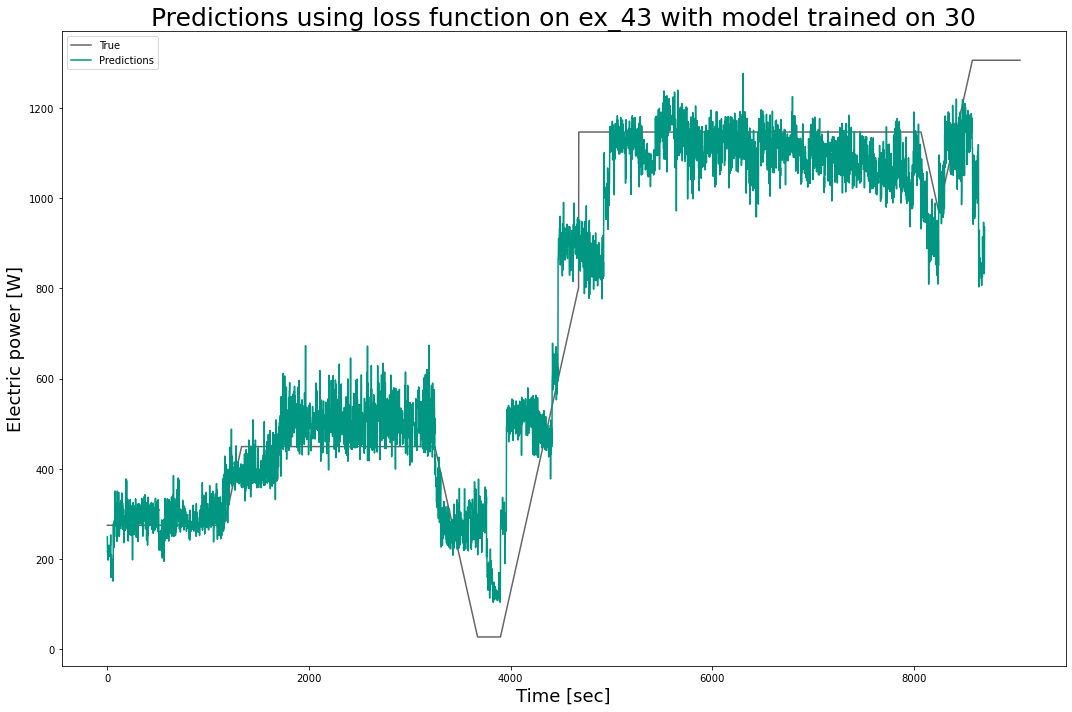

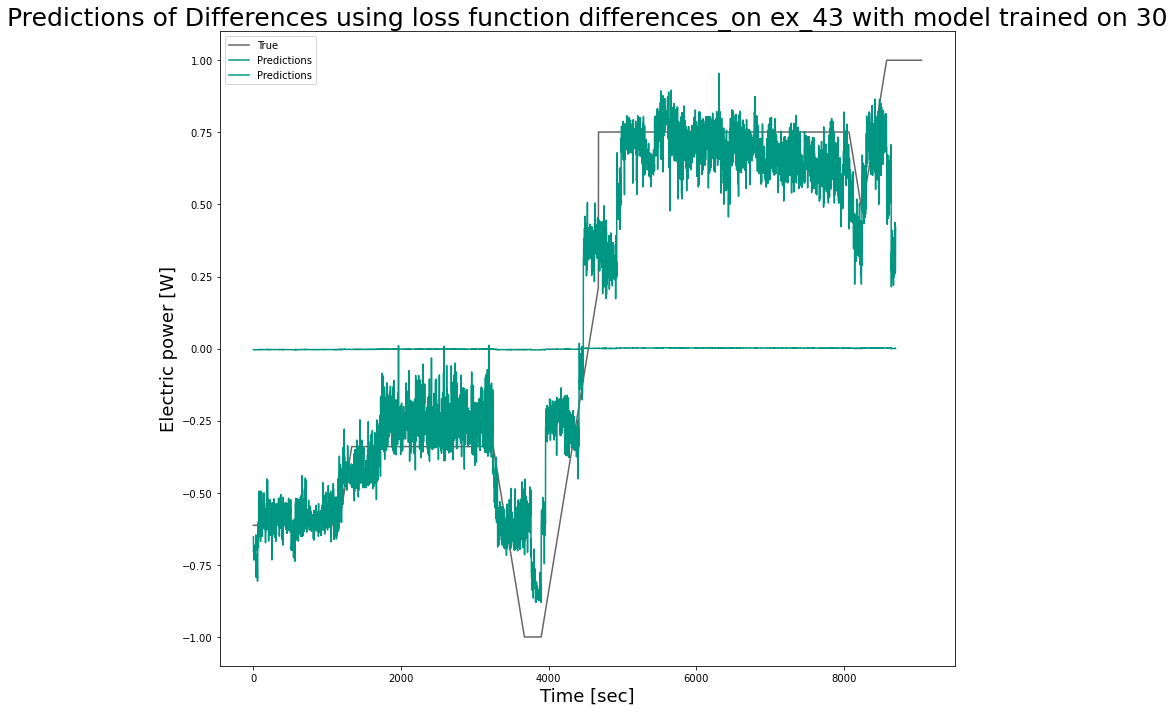

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


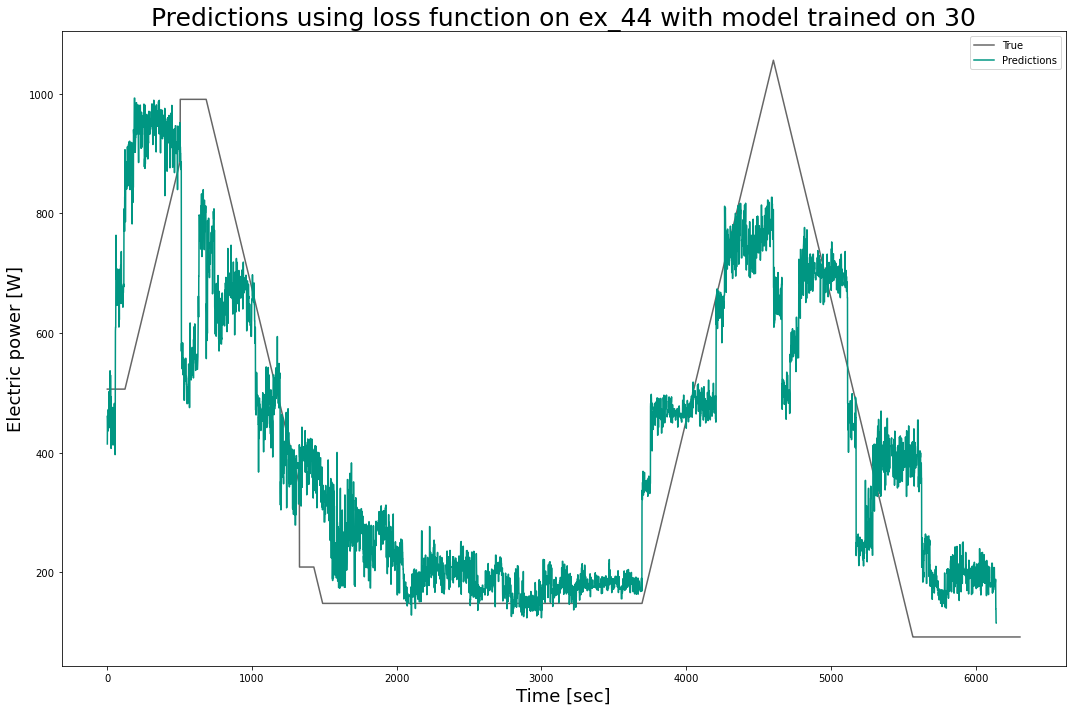

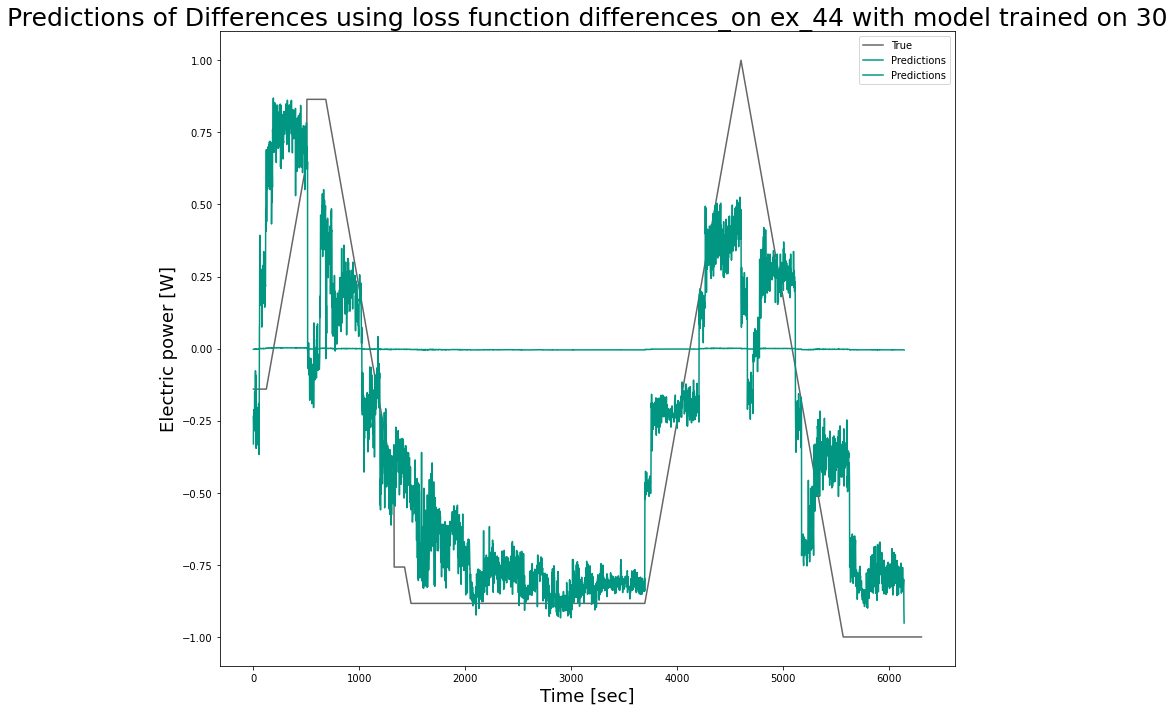

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


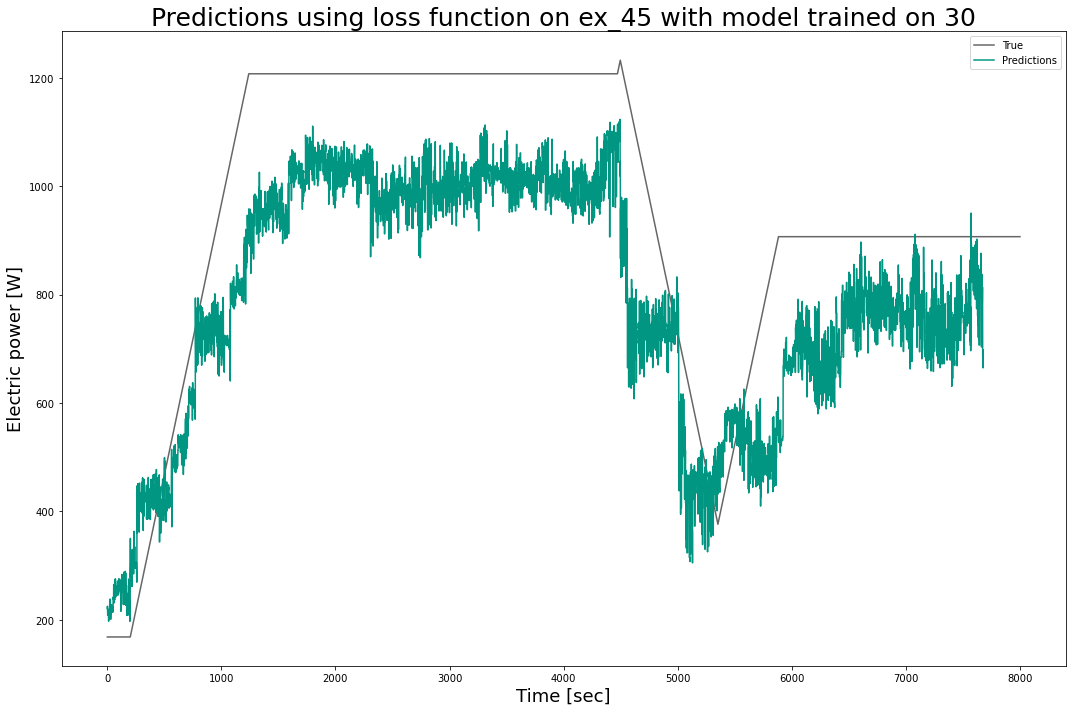

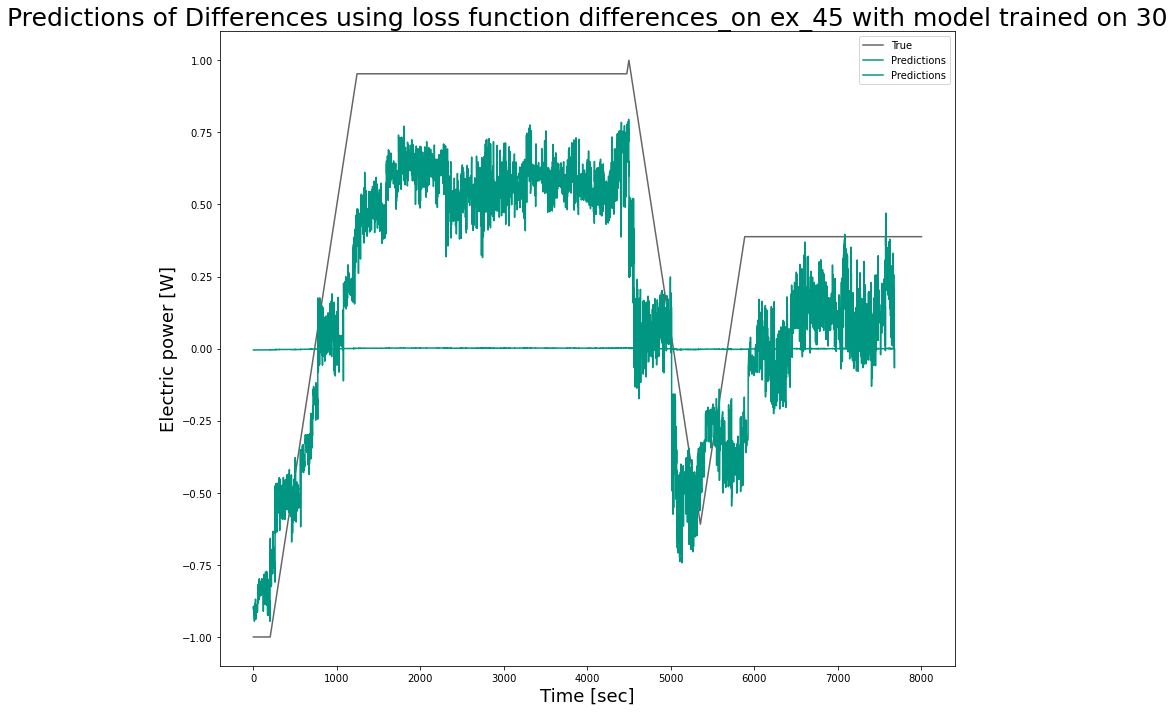

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


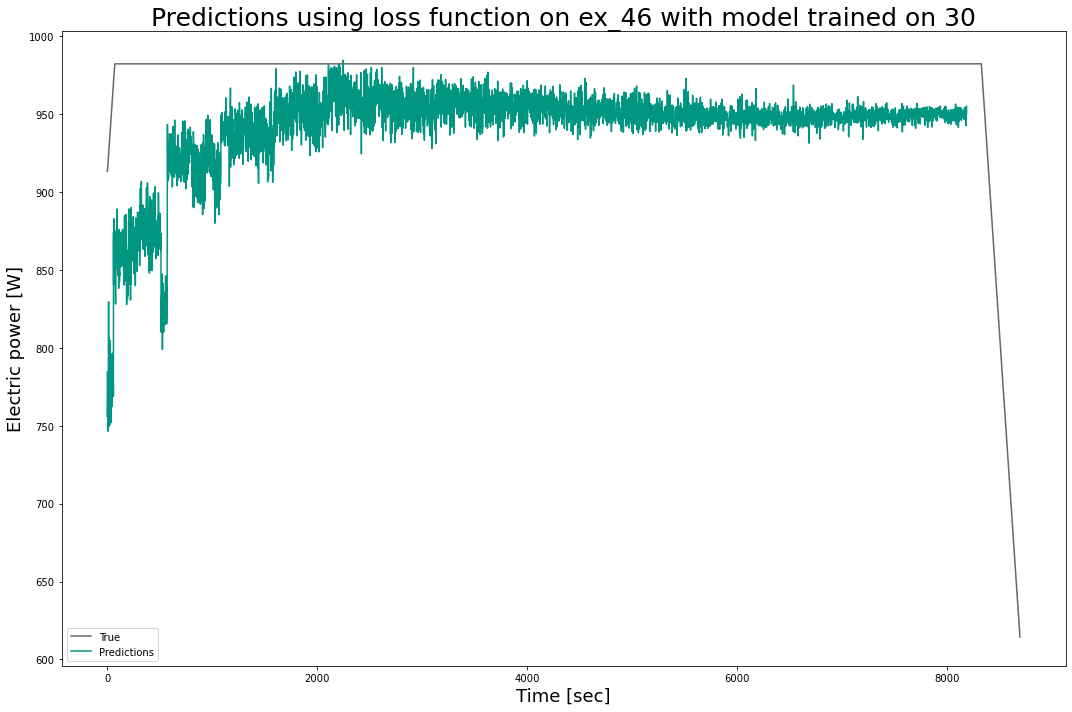

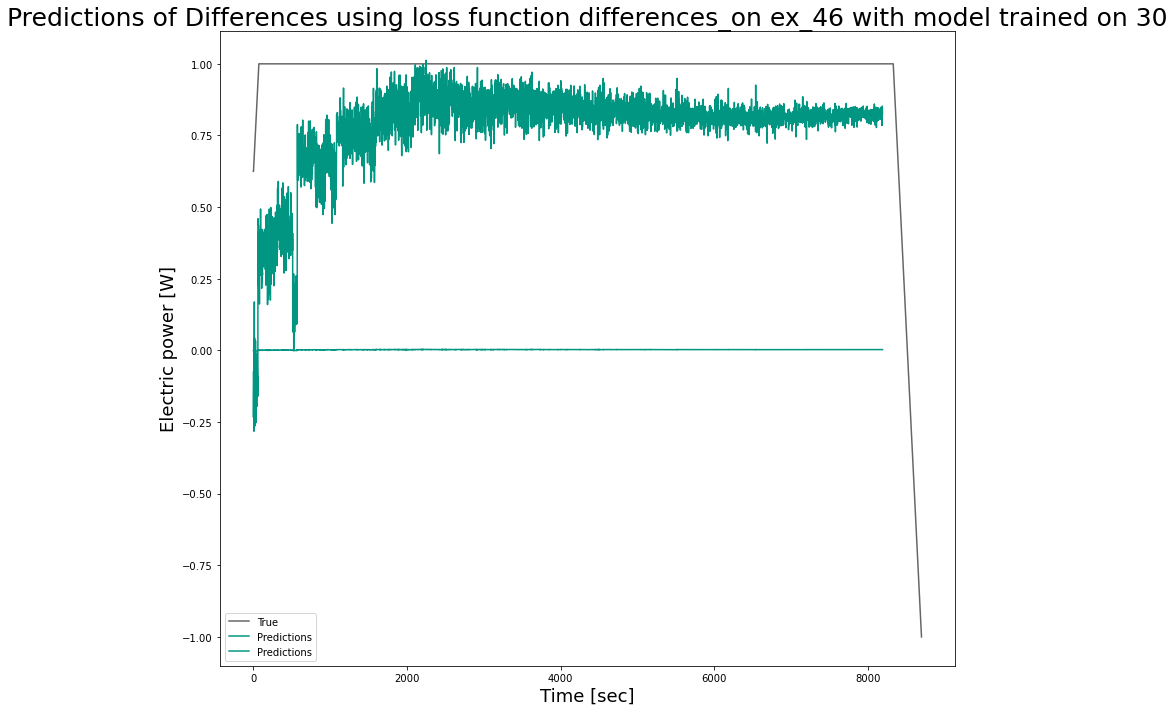

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


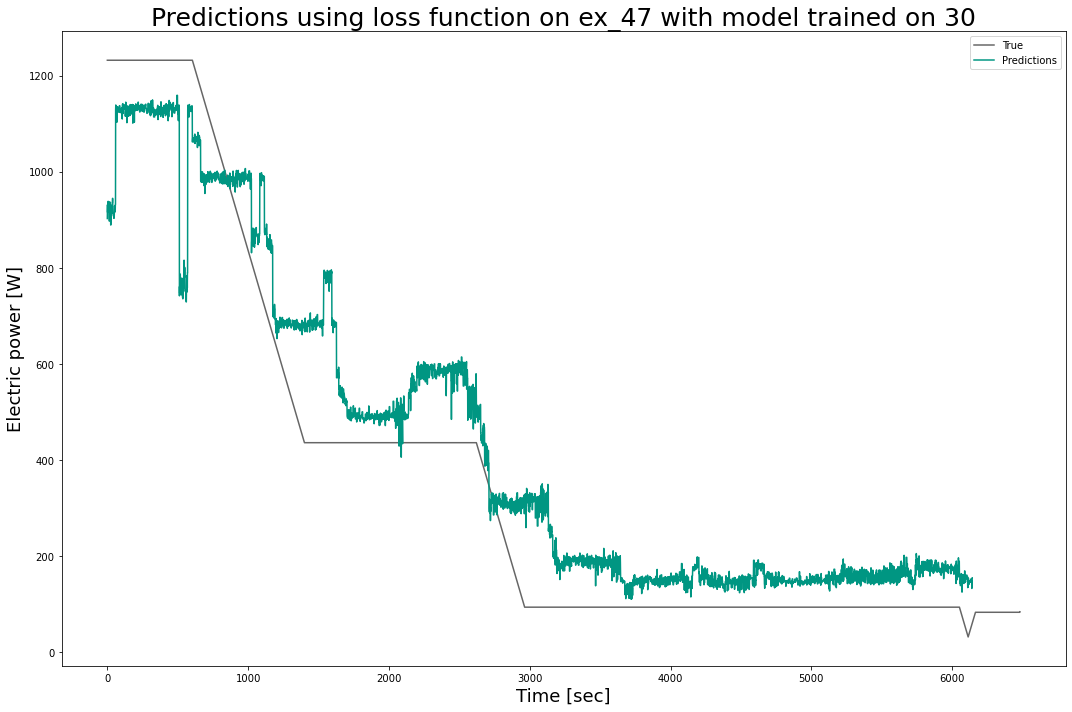

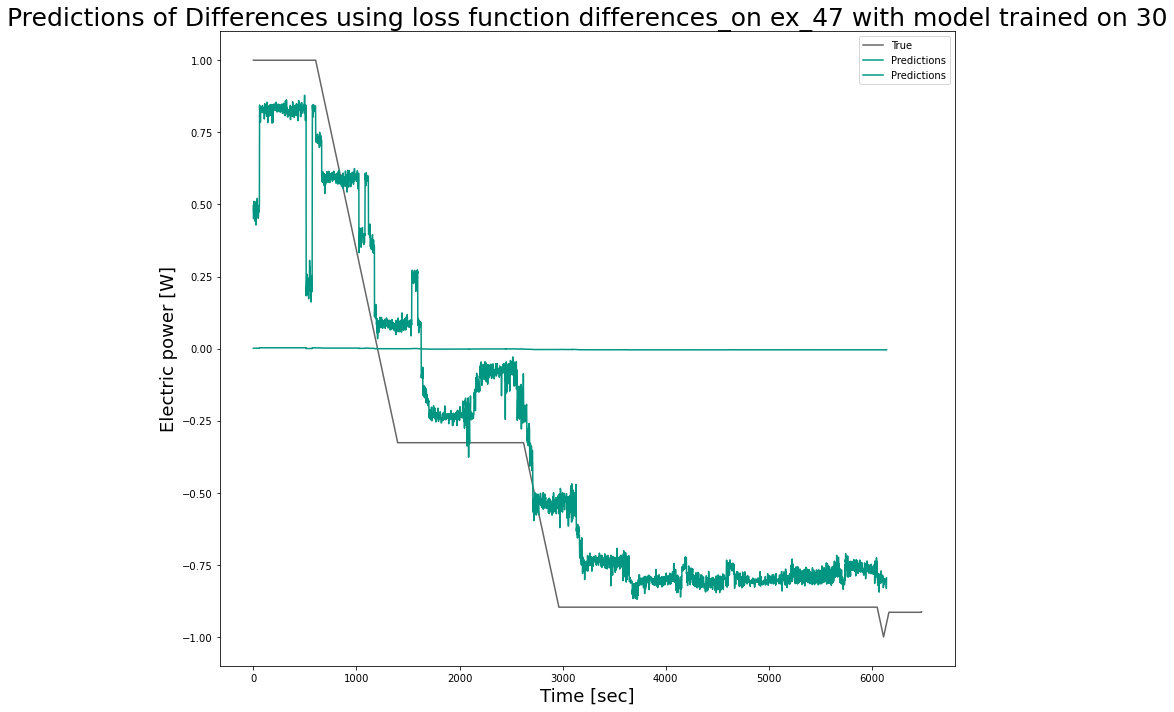

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


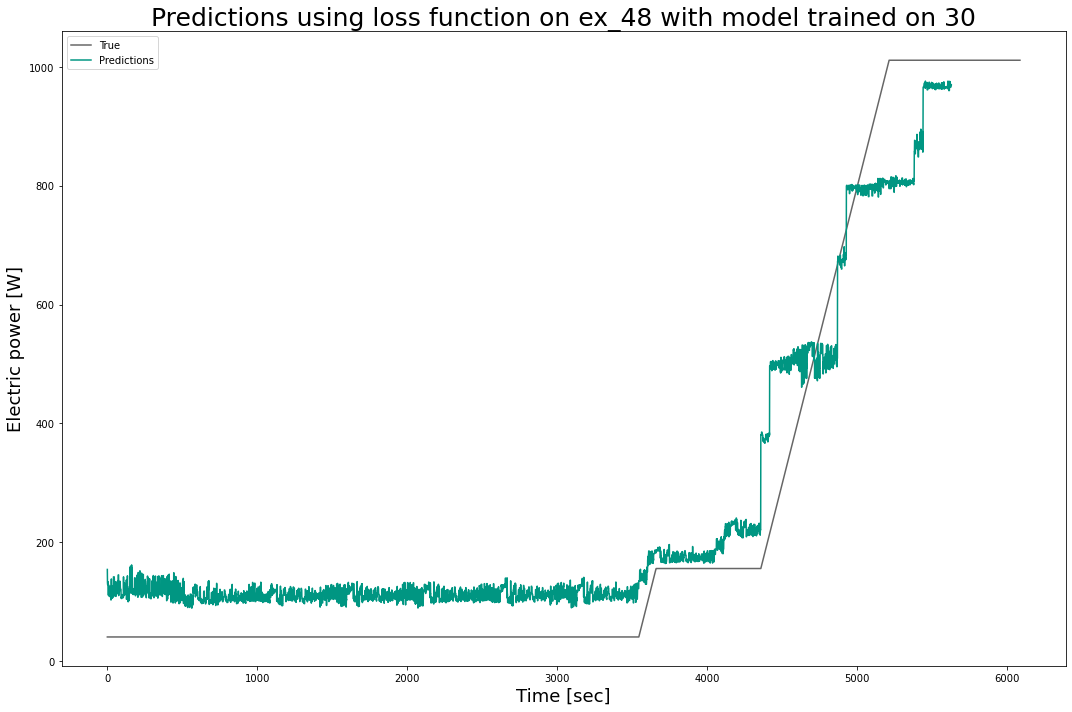

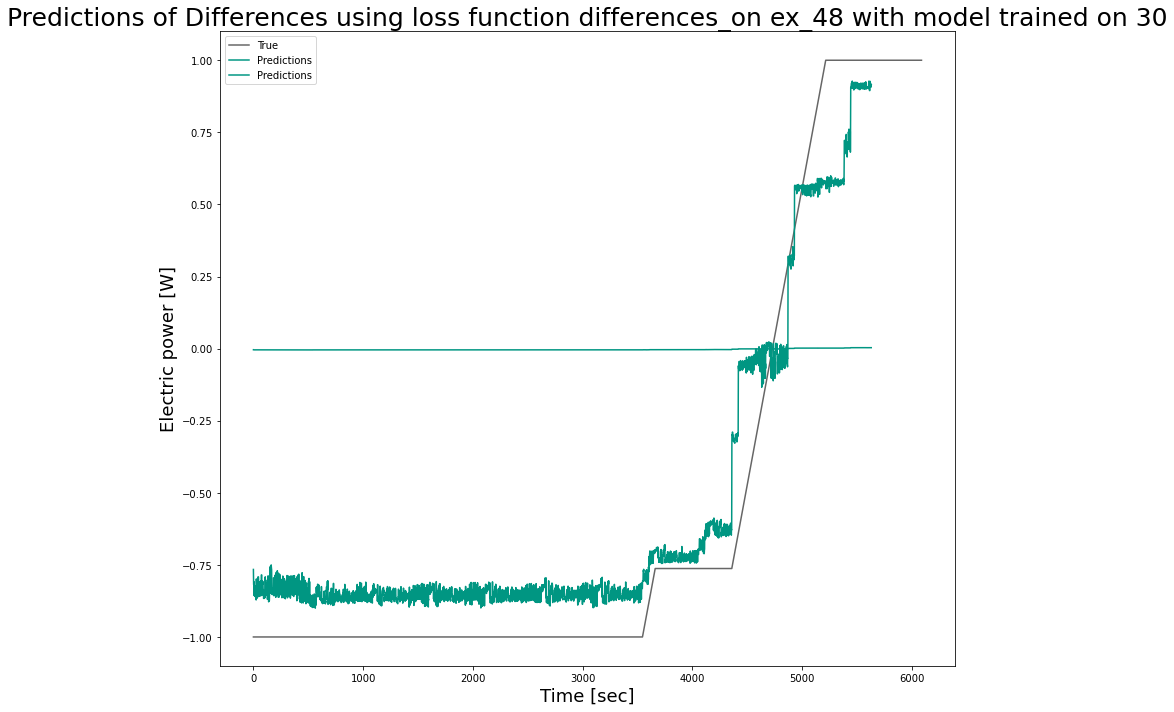

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


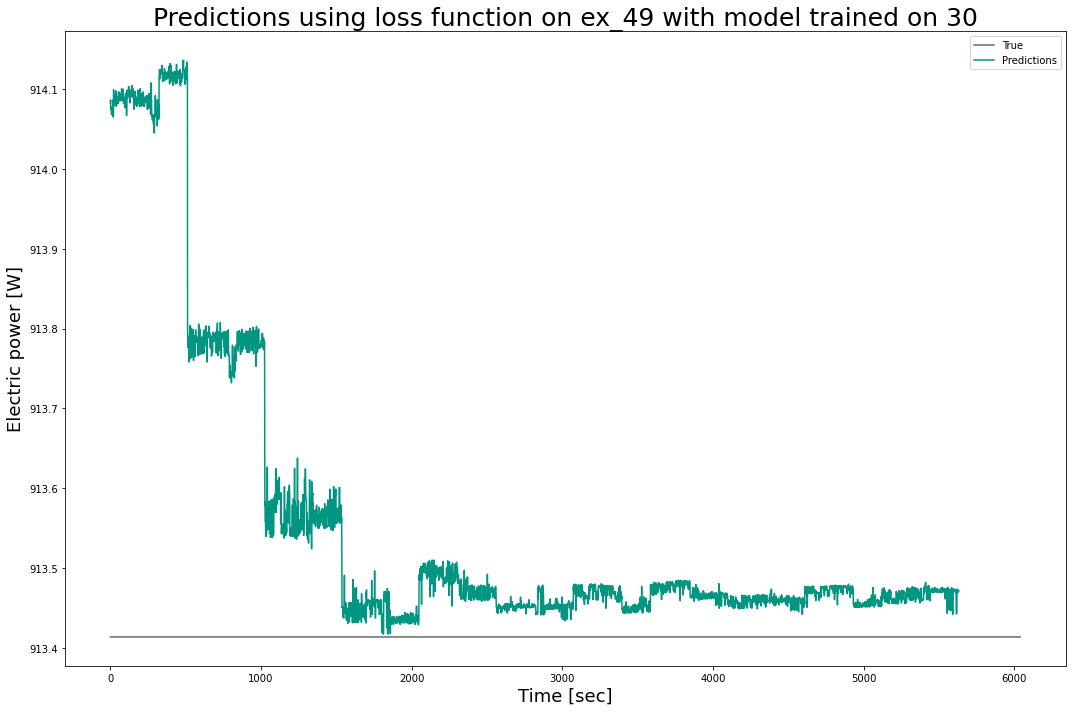

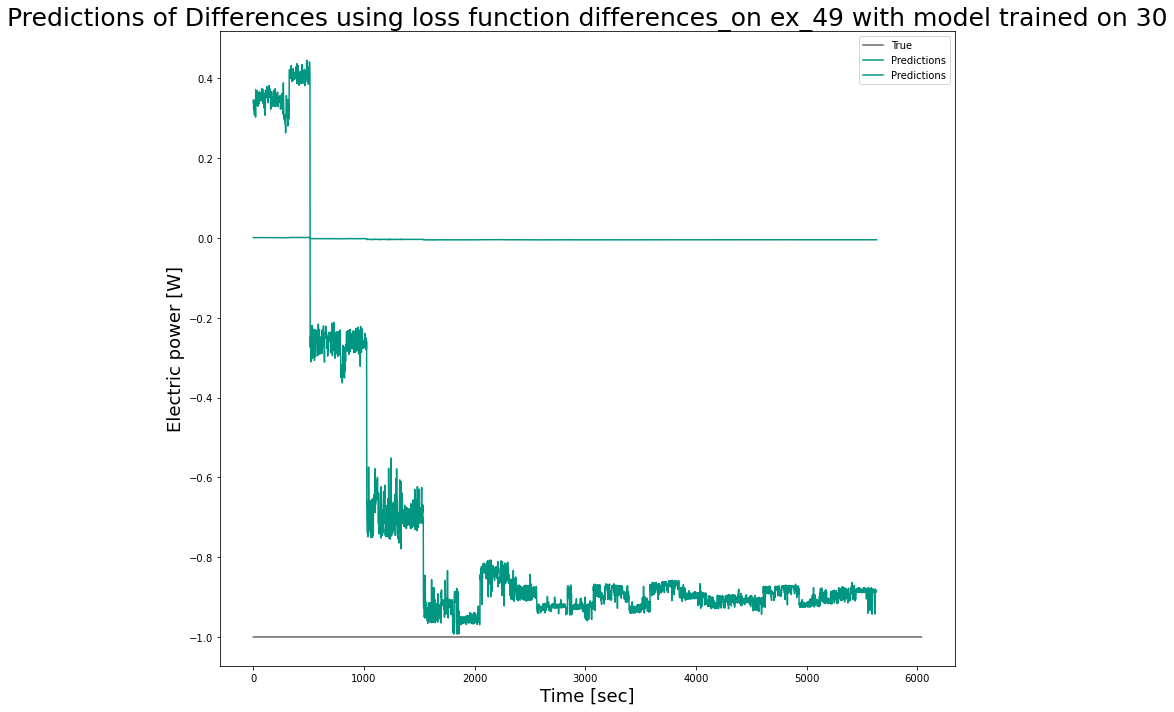

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


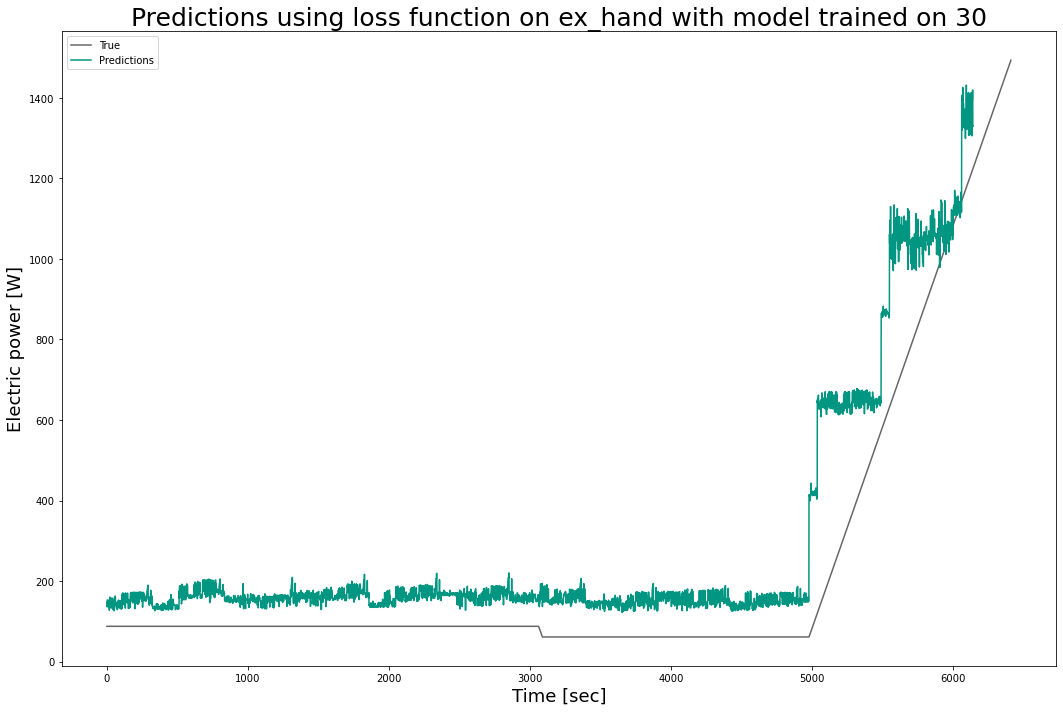

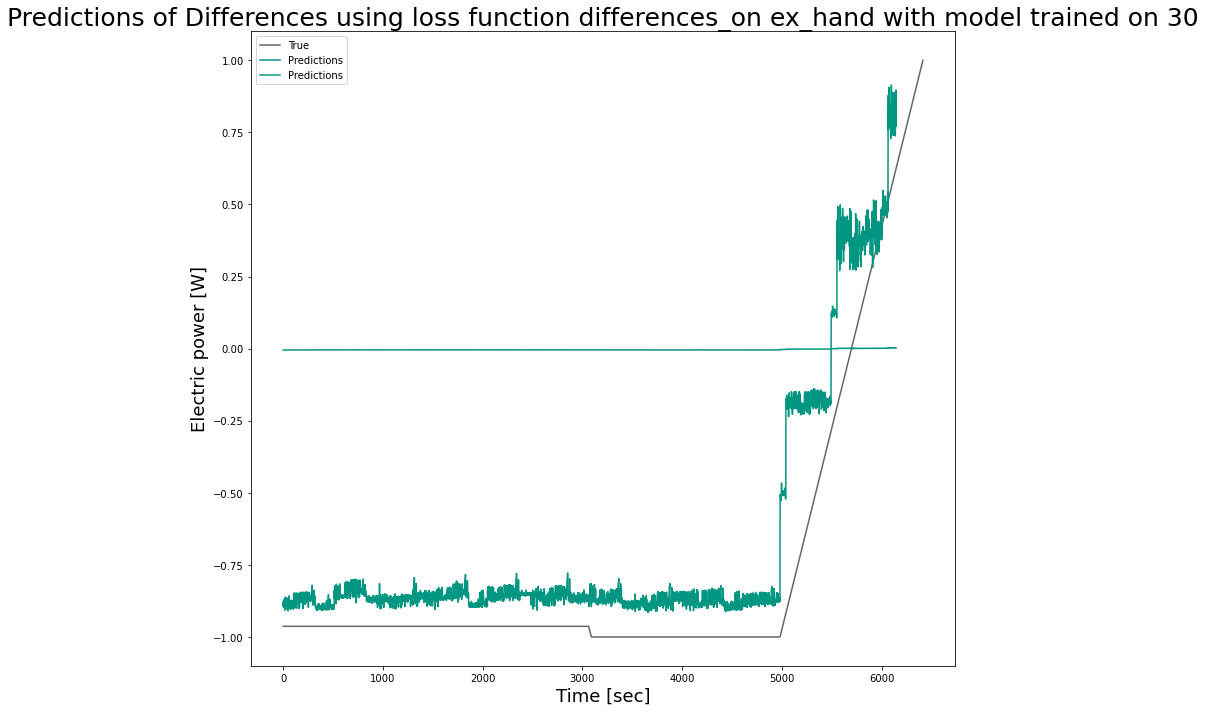

Creation of directory ../Images/Loss_function/2021-05-18_16-58_training_30 val_10 128_neurons__500_epochs__lag_60/Diff_weight_0_TGDS_weight_0.1/ successful.
Creation of directory ../Models/Loss_function/2021-05-18_16-58_training_30 val_10 128_neurons__500_epochs__lag_60/Diff_weight_0_TGDS_weight_0.1/ successful.


C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs
C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Data_Processing.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['diff'] = diffs


Epoch 10 of 500 is done.
Epoch 20 of 500 is done.
Epoch 30 of 500 is done.
Epoch 40 of 500 is done.
Epoch 50 of 500 is done.
Epoch 60 of 500 is done.
Epoch 70 of 500 is done.
Epoch 80 of 500 is done.
Epoch 90 of 500 is done.
Epoch 100 of 500 is done.
Epoch 110 of 500 is done.
Epoch 120 of 500 is done.
Epoch 130 of 500 is done.
Epoch 140 of 500 is done.


In [ ]:
hyperparameter_opt(parameters_diff, parameters_tgds, image_folder)